In [1]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: weikuo38. Use `wandb login --relogin` to force relogin


True

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 

In [3]:
import torch
torch.cuda.is_available()


True

In [4]:
class Configuration:
    preprocess=False
    split = [0]
    load_path = './chess-policy-output'
    df_path = './chess-evaluations/tactic_evals.csv'
cfg = Configuration()

In [5]:
cfg_dict = {k: v for k, v in Configuration.__dict__.items() if not k.startswith('__')}
cfg_dict

{'preprocess': False,
 'split': [0],
 'load_path': './chess-policy-output',
 'df_path': './chess-evaluations/tactic_evals.csv'}

In [6]:
'''
run = wandb.init(
    # Set the project where this run will be logged
    project="chess-policy-network",
    # Track hyperparameters and run metadata
    config=cfg_dict
)
'''

'\nrun = wandb.init(\n    # Set the project where this run will be logged\n    project="chess-policy-network",\n    # Track hyperparameters and run metadata\n    config=cfg_dict\n)\n'

In [7]:
!pip install -qqq chessnut

In [8]:
#df_eval = pd.read_csv('/kaggle/input/chess-evaluations/chessData.csv')
#df_random_eval = pd.read_csv('/kaggle/input/chess-evaluations/random_evals.csv')
df = pd.read_csv(cfg.df_path)
df=df[['FEN', 'Move']]
df = df.dropna()  # Remove rows with NaN values

In [9]:
df.head()

,FEN,Move
0,r2qkbr1/pb1nn3/1ppp3p/8/3P1p2/2PB1N1P/PPQN1PP1...,d3g6
1,r2qkb2/pb1nn3/1ppp2rp/8/3P1p2/2P2N1P/PPQN1PP1/...,c2g6
2,r2qkbr1/pb1nn3/1ppp2Bp/8/3P1p2/2P2N1P/PPQN1PP1...,g8g6
3,8/7p/R5p1/2p1pkP1/7P/P4PK1/1r6/3q4 w - - 6 46,a6f6
4,6k1/pp6/3p4/2p1p3/2P1P1q1/1P1P2pP/P5P1/5K2 w -...,h3g4


In [10]:
policy = df['Move'].unique()
_policy = []
for p in policy:
    if p.__class__.__name__ == 'str':
        _policy.append(p)
policy = np.sort(np.array(_policy))

In [11]:
len(policy), policy


(1942,
 array(['a1a2', 'a1a3', 'a1a4', ..., 'h8h5', 'h8h6', 'h8h7'], dtype='<U5'))

In [12]:
def fen_to_matrix(fen):
    _fen = fen.split()[0]
    piece_map = {
        'p': -0.1, 'r': -0.2, 'n': -0.3, 'b': -0.4, 'q': -0.5, 'k': -0.6,
        'P': 0.1, 'R': 0.2, 'N': 0.3, 'B': 0.4, 'Q': 0.5, 'K': 0.6
    }
    board_rows = _fen.split('/')

    board = np.zeros((8,8))
    for row, row_string in enumerate(board_rows):
        col = 0
        for char in row_string:
            if char.isdigit():
                col += int(char)  # Empty squares
            else:
                board[row, col]= piece_map[char] 
                col += 1 
    return board

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
['a2a3', 'a2a4', 'b2b3', 'b2b4', 'c2c3', 'c2c4', 'd2d3', 'd2d4', 'e2e3', 'e2e4', 'f2f3', 'f2f4', 'g2g3', 'g2g4', 'h2h3', 'h2h4', 'b1c3', 'b1a3', 'g1h3', 'g1f3']


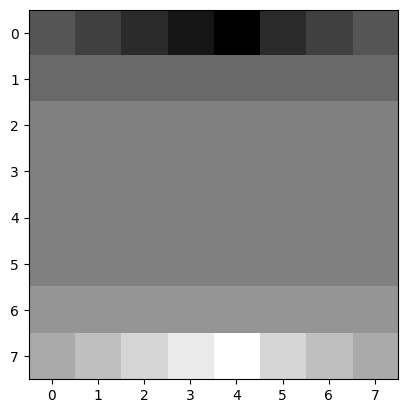

In [13]:

from Chessnut import Game

# Create a new Chessnut game
game = Game()
fen = game.get_fen()
moves = game.get_moves()
print(fen)
print(moves)
array = fen_to_matrix(fen)
import matplotlib.pyplot as plt
plt.imshow(array, cmap='gray')

In [14]:
import numpy as np

def moves_to_matrix(moves=None, policy=None, move_index_map=None):
    '''
    Converts a list of valid moves into a binary mask corresponding to a policy list of possible moves.
    
    Args:
    - moves: List of valid moves, e.g., ['a1a2', 'a1a3', 'a1a4']
    - policy: Array of all possible moves, e.g., ['a1a2', 'a1a3', 'a1a4', ..., 'h8h5', 'h8h6', 'h8h7']
    
    Returns:
    - A binary numpy array where 1 indicates a move in `moves` and 0 otherwise.
    '''
    # Create a dictionary to map each move to its index in the policy array
    if move_index_map is None:
        move_index_map = {move: idx for idx, move in enumerate(policy)}
    
    # Create a binary mask with 0s initially
    mask = np.zeros(len(policy), dtype=int)
    
    # Set corresponding indices to 1 for moves found in the `moves` list
    for move in moves:
        if move in move_index_map:
            mask[move_index_map[move]] = 1
    
    return mask

# Example usage
moves = ['a1a2', 'a1a3', 'a1a4'] 
move_index_map = {move: idx for idx, move in enumerate(policy)}
mask = moves_to_matrix(moves, policy, move_index_map)

print(mask)


[1 1 1 ... 0 0 0]


In [15]:
import torch
import torch.nn as nn
# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        # Convolutional layers to extract spatial features
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Output: [32, 8, 8]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: [64, 8, 8]
        
        # Fully connected layers
        self.fc1 = nn.LazyLinear(1024)
        self.fc2 = nn.Linear(1024, 1942)  # (1942 possible moves)
        
    def forward(self, board_tensor, moves_mask):
        #print(f'board_tensor',board_tensor.shape)
        board_tensor = board_tensor.unsqueeze(1)
        x = torch.relu(self.conv1(board_tensor))  # [batch_size, 32, 8, 8]
        x = torch.relu(self.conv2(x))             # [batch_size, 64, 8, 8]
        #print('x', x.shape)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = torch.relu(self.fc1(x))  # [batch_size, 1024]
        x = self.fc2(x)  # [batch_size, 4096] -> Move probabilities
        
        # Apply moves mask (invalid moves set to -inf)
        x = x.masked_fill(moves_mask == 0, float('-inf'))
        return torch.softmax(x, dim=-1)
import torch
import torch.nn as nn
# Define the policy network
class PolicyNetwork2(nn.Module):
    def __init__(self):
        super(PolicyNetwork2, self).__init__()
        # Convolutional layers to extract spatial features
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Output: [32, 8, 8]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: [64, 8, 8]
        
        # Fully connected layers
        self.fc1 = nn.LazyLinear(2048)
        self.fc2 = nn.Linear(2048, 1942)  # (1942 possible moves)
        
    def forward(self, board_tensor, moves_mask):
        #print(f'board_tensor',board_tensor.shape)
        board_tensor = board_tensor.unsqueeze(1)
        x = torch.relu(self.conv1(board_tensor))  # [batch_size, 32, 8, 8]
        x = torch.relu(self.conv2(x))             # [batch_size, 64, 8, 8]
        #print('x', x.shape)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = torch.relu(self.fc1(x))  # [batch_size, 1024]
        x = self.fc2(x)  # [batch_size, 4096] -> Move probabilities
        
        # Apply moves mask (invalid moves set to -inf)
        x = x.masked_fill(moves_mask == 0, float('-inf'))
        return torch.softmax(x, dim=-1)



In [16]:
'''import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold 
 


# Training function with K-Fold cross-validation
def train_with_kfold(df, k=5, policy=None, move_index_map=None):
    # Prepare the k-fold cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"Training fold {fold+1}/{k}")
        
        # Split the data into training and validation sets
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]
        
        # Initialize the model, loss function, and optimizer
        model = PolicyNetwork()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        
        # Training loop
        for epoch in range(10):  # 10 epochs (adjust as needed)
            model.train()
            total_loss = 0
            correct_predictions = 0
            total_samples = 0
            
            for _, row in train_df.iterrows():
                # Extract the FEN and move
                fen = row['FEN']
                move = row['Move'] 
                
                # Convert the FEN to the board tensor
                board_tensor = fen_to_matrix(fen)  # [1, 8, 8]
                
                # Get available moves using Chessnut
                chess = Game()
                chess.reset(fen)
                available_moves = chess.get_moves()
                
                # Convert available moves to the binary mask (policy space)
                moves_mask = moves_to_matrix(moves=available_moves, policy=policy, move_index_map=move_index_map)
                
                # Convert move to index in the policy array (ground truth)
                move_index = move_index_map[move]  # Map to index in the policy array

                board_tensor = torch.tensor(board_tensor, dtype=torch.float32)
                board_tensor = board_tensor.unsqueeze(0).float() # channel
                moves_mask = torch.tensor(moves_mask, dtype=torch.float32)
                # Forward pass
                board_tensor = board_tensor.unsqueeze(0).float()  # Add batch dimension
                moves_mask = moves_mask.unsqueeze(0).float()  # Add batch dimension
                
                optimizer.zero_grad()
                output = model(board_tensor, moves_mask)
                
                # Calculate loss 
                loss = loss_fn(output, torch.tensor([move_index]))
                total_loss += loss.item()
                
                # Prediction and accuracy calculation
                predicted_move_index = torch.argmax(output)
                correct_predictions += (predicted_move_index == move_index).sum().item()
                total_samples += 1
                
                # Backpropagation
                loss.backward()
                optimizer.step()
            
            avg_loss = total_loss / len(train_df)
            accuracy = correct_predictions / total_samples
            print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        
        # Evaluate on validation set
        model.eval()
        val_correct_predictions = 0
        val_total_samples = 0
        
        with torch.no_grad():
            for _, row in val_df.iterrows():
                fen = row['FEN']
                move = row['Move'] 
                
                board_tensor = fen_to_matrix(fen)
                
                chess = Game()
                chess.reset(fen)
                available_moves = chess.get_moves()
                
                moves_mask = moves_to_matrix(moves=available_moves, policy=policy, move_index_map=move_index_map)
                move_index = move_index_map[move]  

                
                board_tensor = torch.tensor(board_tensor, dtype=torch.float32)
                board_tensor = board_tensor.unsqueeze(0).float() # channel
                moves_mask = torch.tensor(moves_mask, dtype=torch.float32)
                
                board_tensor = board_tensor.unsqueeze(0).float()
                moves_mask = moves_mask.unsqueeze(0).float()
                
                output = model(board_tensor, moves_mask)
                
                # Prediction and accuracy calculation
                predicted_move_index = torch.argmax(output)
                
                val_correct_predictions += (predicted_move_index == move_index).sum().item()
                val_total_samples += 1
        
        val_accuracy = val_correct_predictions / val_total_samples
        accuracies.append(val_accuracy)
        print(f"Validation Accuracy for Fold {fold+1}: {val_accuracy:.4f}")
    
    # Print average accuracy
    avg_accuracy = np.mean(accuracies)
    print(f"Average Validation Accuracy: {avg_accuracy:.4f}")

# Assuming `df` is the DataFrame with the chess data
# Define the list of all possible moves (the policy space) 
move_index_map = {move: idx for idx, move in enumerate(policy)}

# Train the model with k-fold cross-validation
train_with_kfold(df.copy()[:10], k=5, policy=policy, move_index_map=move_index_map)
'''
pass

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

# Custom Dataset to handle data loading for chess FEN and moves
class ChessDataset(Dataset):
    def __init__(self, df, policy, move_index_map, board=None, moves=None, bestmove=None):
        self.df = df
        self.policy = policy
        self.move_index_map = move_index_map
        self.board = board
        self.moves = moves
        self.bestmove = bestmove
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.board:
            return torch.tensor(self.board[idx], dtype=torch.float32), torch.tensor(self.moves[idx], dtype=torch.float32), torch.tensor(self.bestmove[idx], dtype=torch.long)

        row = self.df.iloc[idx]
        fen = row['FEN']
        move = row['Move']

        # Convert FEN to board tensor
        board_tensor = fen_to_matrix(fen)
        
        # Get available moves using Chessnut (batch processing later can avoid repeated calls)
        chess = Game()
        chess.reset(fen)
        available_moves = chess.get_moves()
        
        # Convert available moves to the binary mask (policy space)
        moves_mask = moves_to_matrix(moves=available_moves, policy=self.policy, move_index_map=self.move_index_map)
        
        # Convert move to index in the policy array (ground truth)
        move_index = self.move_index_map[move]

        return torch.tensor(board_tensor, dtype=torch.float32), torch.tensor(moves_mask, dtype=torch.float32), torch.tensor(move_index, dtype=torch.long)



In [18]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
# Training function with K-Fold cross-validation and batch processing
def train_with_kfold(df, k=5, policy=None, move_index_map=None, epochs=10, batch_size=32, device=None):
    # Prepare the k-fold cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"Training fold {fold+1}/{k}")
        
        # Split the data into training and validation sets
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]
        
        # Create Dataset and DataLoader for batching
        train_dataset = ChessDataset(train_df, policy, move_index_map)
        val_dataset = ChessDataset(val_df, policy, move_index_map)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        # Initialize the model, loss function, and optimizer
        model = PolicyNetwork()
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        loss_fn = nn.CrossEntropyLoss()

        print('start training')
        # Training loop
        for epoch in range(epochs):  # 10 epochs (adjust as needed)
            model.train()
            total_loss = 0
            correct_predictions = 0
            total_samples = 0

            for board_tensor, moves_mask, move_index in tqdm(train_loader, desc=f"Epoch {epoch+1}", total=len(train_loader)):
                # Forward pass
                board_tensor, moves_mask, move_index=board_tensor.to(device), moves_mask.to(device), move_index.to(device)
                output = model(board_tensor, moves_mask)
                
                # Calculate loss 
                loss = loss_fn(output, move_index)
                total_loss += loss.item()
                
                # Prediction and accuracy calculation
                predicted_move_index = torch.argmax(output, dim=1)
                correct_predictions += (predicted_move_index == move_index).sum().item()
                total_samples += move_index.size(0)
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            avg_loss = total_loss / len(train_loader)
            accuracy = correct_predictions / total_samples
            print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        
            # Evaluate on validation set
            model.eval()
            val_correct_predictions = 0
            val_total_samples = 0
            
            with torch.no_grad(): 
                for board_tensor, moves_mask, move_index in tqdm(val_loader, desc=f"Epoch {epoch+1}", total=len(val_loader)):
                    board_tensor, moves_mask, move_index=board_tensor.to(device), moves_mask.to(device), move_index.to(device)
                    output = model(board_tensor, moves_mask)
                    
                    # Prediction and accuracy calculation
                    predicted_move_index = torch.argmax(output, dim=1)
                    val_correct_predictions += (predicted_move_index == move_index).sum().item()
                    val_total_samples += move_index.size(0)
    
            val_accuracy = val_correct_predictions / val_total_samples
            print(f"Validation Accuracy for Fold {fold+1}: {val_accuracy:.4f}")
        accuracies.append(val_accuracy)
    # Print average accuracy
    avg_accuracy = np.mean(accuracies)
    print(f"Average Validation Accuracy: {avg_accuracy:.4f}")



In [19]:
# Define the list of all possible moves (the policy space) 
move_index_map = {move: idx for idx, move in enumerate(policy)}

# Train the model with k-fold cross-validation
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#train_with_kfold(df.copy()[:100], k=2, policy=policy, move_index_map=move_index_map, epochs=3, batch_size=64, device=device)

# Preprocess

In [20]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import pickle
# Training function with K-Fold cross-validation and batch processing
def preprocess(df, partition=None, policy=None, move_index_map=None): 
    # Create Dataset and DataLoader for batching
    dataset = ChessDataset(df, policy, move_index_map)  
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4) 
    
    board_list = []
    moves_list = []
    bestmove_list = []
    
    for board_tensor, moves_mask, move_index in tqdm(data_loader, desc=f"PREPROCESS", total=len(data_loader)):
       
        board_list.append(board_tensor.numpy())
        moves_list.append(moves_mask.numpy())
        bestmove_list.append(move_index.numpy())
    
    board_list = np.concatenate(board_list)
    moves_list = np.concatenate(moves_list)
    bestmove_list = np.concatenate(bestmove_list)
    # Save the arrays to a .npz file
    np.savez(f'processed_data_{partition}.npz', board=board_list, moves=moves_list, bestmove=bestmove_list)
 
    # Save move_index_map and policy with pickle
    with open('move_index_map.pkl', 'wb') as f:
        pickle.dump(move_index_map, f)

    with open('policy.pkl', 'wb') as f:
        pickle.dump(policy, f)
    #save as npz
    #save policy and move_index_map as well
if cfg.preprocess:
    tot= len(df)
    for i in range(0,tot,tot//20):
        
        preprocess(df.copy()[i:i+tot//20],partition=i//(tot//20),  policy=policy, move_index_map=move_index_map)

# Load a specific data split

In [21]:
import pickle
import numpy as np
import os
def load(load_path= cfg.load_path, split=None):
    # Load the processed data (boards, moves, and best moves)
    with open(os.path.join(load_path,'policy.pkl'), 'rb') as f:
        policy = pickle.load(f)
    
    # Load move_index_map using pickle
    with open(os.path.join(load_path,'move_index_map.pkl'), 'rb') as f:
        move_index_map = pickle.load(f)
        
    if split.__class__  is not list:
        s = int(split)
        data = np.load(os.path.join(load_path,f'processed_data_{s}.npz'))
        board = data['board']
        moves = data['moves']
        bestmove = data['bestmove']
    else:
        board, moves, bestmove = [], [], []
        for s in split:
            data = np.load(os.path.join(load_path,f'processed_data_{s}.npz')) 
            board .append(data['board'])
            moves.append(data['moves'])
            bestmove.append(data['bestmove'])
        board = np.concatenate(board)
        moves = np.concatenate(moves)
        bestmove = np.concatenate(bestmove)
        
    # Load policy using pickle
     
    
    print("Data and policy loaded successfully.")
    return  policy, move_index_map, board, moves, bestmove

policy, move_index_map, board, moves, bestmove=load(split=cfg.split)

    

Data and policy loaded successfully.


# Dataset and training script for a split

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

# Custom Dataset to handle data loading for chess FEN and moves
class ChessDataset2(Dataset):
    def __init__(self, board=None, moves=None, bestmove=None):
        self.board = board
        self.moves = moves
        self.bestmove = bestmove
    def __len__(self):
        return len(self.board)

    def __getitem__(self, idx):
        if self.board is not None:
            return torch.tensor(self.board[idx], dtype=torch.float32), \
                   torch.tensor(self.moves[idx], dtype=torch.float32), \
                   torch.tensor(self.bestmove[idx], dtype=torch.long)
  

In [23]:
dataset = ChessDataset2(board=board,
                        moves=moves,
                        bestmove=bestmove)
dataset[0] 

(tensor([[ 0.0000, -0.5000, -0.2000,  0.0000,  0.0000,  0.0000, -0.6000,  0.0000],
         [-0.1000,  0.0000,  0.0000, -0.4000,  0.0000,  0.0000, -0.1000, -0.1000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.5000,  0.0000],
         [ 0.0000,  0.1000,  0.0000,  0.0000,  0.0000, -0.1000,  0.0000,  0.0000],
         [ 0.1000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.4000,  0.1000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.1000,  0.0000,  0.0000,  0.0000,  0.1000],
         [ 0.0000,  0.2000,  0.0000,  0.0000,  0.0000,  0.2000,  0.6000,  0.0000]]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor(1902))

In [24]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

 

import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import random
# Training function with K-Fold cross-validation and batch processing
def train2(board=None, moves=None, bestmove=None, epochs=10, batch_size=32, device=None):
     
    # Prepare the k-fold cross-validation
 
    
    # Create an ID list as indices
    id_list = np.arange(0, len(board))  # Array of indices from 0 to len(X)-1
    
    # Split the id_list into train and test sets (80% for training, 20% for testing)
    id_train, id_test = train_test_split(id_list, test_size=0.2, random_state=42)
    
    # Use the train-test split indices to select the corresponding data points
    board_train = board[id_train]
    board_test = board[id_test]
    moves_train = moves[id_train]
    moves_test = moves[id_test]
    bestmove_train = bestmove[id_train]
    bestmove_test = bestmove[id_test]
 
    # Create Dataset and DataLoader for batching
    train_dataset = ChessDataset2(board=board_train,
                                  moves=moves_train,
                                  bestmove=bestmove_train)
    val_dataset = ChessDataset2(board=board_test,
                                moves=moves_test,
                                bestmove=bestmove_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Initialize the model, loss function, and optimizer
    model = PolicyNetwork2()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = nn.CrossEntropyLoss()

    # Watch model parameters with wandb
    _cfg_dict = cfg_dict.copy()
    _cfg_dict['model']=model.__class__.__name__
    _cfg_dict['batch_size']=batch_size
    _cfg_dict['epochs']=epochs
    run = wandb.init(
    # Set the project where this run will be logged
    project="chess-policy-network",
    # Track hyperparameters and run metadata
    config=_cfg_dict
    )
    #wandb.watch(model, log="all")
    
    print('start training')
    # Training loop
    for epoch in range(epochs):  # 10 epochs (adjust as needed)
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for board_tensor, moves_mask, move_index in tqdm(train_loader, desc=f"Epoch {epoch+1}", total=len(train_loader)):
            # Forward pass
            board_tensor, moves_mask, move_index=board_tensor.to(device), moves_mask.to(device), move_index.to(device)
            output = model(board_tensor, moves_mask)
            
            # Calculate loss 
            loss = loss_fn(output, move_index)
            total_loss += loss.item()
 
            
            # Prediction and accuracy calculation
            predicted_move_index = torch.argmax(output, dim=1)
            correct_predictions += (predicted_move_index == move_index).sum().item()
 
            
            total_samples += move_index.size(0)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

             # Log batch metrics to wandb
            batch_loss = loss.item()
            batch_acc = (predicted_move_index == move_index).sum().item() / move_index.size(0)
            wandb.log({"train/batch_loss": batch_loss, "train/batch_accuracy": batch_acc})


        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_samples
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        wandb.log({"train/epoch_loss": avg_loss, "train/epoch_accuracy": accuracy})
    
        # Evaluate on validation set
        model.eval()
        val_correct_predictions = 0
        val_total_samples = 0
        
        with torch.no_grad(): 
            for board_tensor, moves_mask, move_index in tqdm(val_loader, desc=f"Epoch {epoch+1}", total=len(val_loader)):
                board_tensor, moves_mask, move_index=board_tensor.to(device), moves_mask.to(device), move_index.to(device)
                output = model(board_tensor, moves_mask)
                
                # Prediction and accuracy calculation
                predicted_move_index = torch.argmax(output, dim=1)
                val_correct_predictions += (predicted_move_index == move_index).sum().item()
                val_total_samples += move_index.size(0)

        val_accuracy = val_correct_predictions / val_total_samples
        wandb.log({"val/epoch_accuracy": val_accuracy})
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        torch.save(model.state_dict(), f'chess_epoch{epoch+1}_accuracy_{int(val_accuracy * 1000):3}.pth')


In [25]:

#train2(board=board, moves=moves, bestmove=bestmove, epochs=0, batch_size=256)

# Dataset and training script for all splits

In [26]:

tot= len(df)
tot

2544451

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

# Custom Dataset to handle data loading for chess FEN and moves
class ChessDataset3(Dataset):
    def __init__(self, tot=tot, totsplit=20, chosen=None, current_split=-1, board=None, moves=None, bestmove=None):
        self.tot=tot
        self.totsplit=totsplit
        self.chosen=chosen
        self.chosen.sort()
        self.board = board
        self.moves = moves
        self.bestmove = bestmove
        self.current_split = current_split
        
    def __len__(self):
        return len(self.chosen)

    def __getitem__(self, idx):
        real_idx = self.chosen[idx]
        _split = real_idx//(self.tot//self.totsplit) 
        if _split != self.current_split:
            del self.board, self.moves, self.bestmove
            policy, move_index_map, self.board, self.moves, self.bestmove=load(split=_split)
            self.current_split = _split
            print(f"split {_split} loaded")
            
        split_idx = real_idx % (self.tot//self.totsplit) 
        return torch.tensor(self.board[split_idx], dtype=torch.float32), \
               torch.tensor(self.moves[split_idx], dtype=torch.float32), \
               torch.tensor(self.bestmove[split_idx], dtype=torch.long)
  

In [28]:

class PolicyNetwork3(nn.Module):
    def __init__(self):
        super(PolicyNetwork3, self).__init__()
        # Convolutional layers to extract spatial features
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # Output: [32, 8, 8]
        self.conv2 = nn.Conv2d(64, 256, kernel_size=3, padding=1)  # Output: [64, 8, 8]
        
        # Fully connected layers
        self.fc1 = nn.LazyLinear(2048)
        self.fc2 = nn.Linear(2048, 1942)  # (1942 possible moves)
        
    def forward(self, board_tensor, moves_mask):
        #print(f'board_tensor',board_tensor.shape)
        board_tensor = board_tensor.unsqueeze(1)
        x = torch.relu(self.conv1(board_tensor))  # [batch_size, 32, 8, 8]
        x = torch.relu(self.conv2(x))             # [batch_size, 64, 8, 8]
        #print('x', x.shape)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = torch.relu(self.fc1(x))  # [batch_size, 1024]
        x = self.fc2(x)  # [batch_size, 4096] -> Move probabilities
        
        # Apply moves mask (invalid moves set to -inf)
        x = x.masked_fill(moves_mask == 0, float('-inf'))
        return torch.softmax(x, dim=-1)

class PolicyNetwork4(nn.Module):
    def __init__(self):
        super(PolicyNetwork4, self).__init__()
        # Convolutional layers to extract spatial features
        self.onehot = lambda x: torch.nn.functional.one_hot(x, num_classes=13)
        self.conv1 = nn.Conv2d(13, 64, kernel_size=3, padding=1)  # Output: [32, 8, 8]
        self.conv2 = nn.Conv2d(64, 256, kernel_size=3, padding=1)  # Output: [64, 8, 8]
        
        # Fully connected layers
        self.fc1 = nn.LazyLinear(2048)
        self.fc2 = nn.Linear(2048, 1942)  # (1942 possible moves)
        
    def forward(self, board_tensor, moves_mask):
        #print(f'board_tensor',board_tensor.shape)
        board_tensor = board_tensor * 10 + 6   #[batch_dize, 8, 8]
        board_tensor = board_tensor.to(torch.int64)
        #print(board_tensor.max())
        # One-hot encoding
        board_tensor = self.onehot(board_tensor)  # Shape: [batchsize, 8, 8, 13]
        #print(board_tensor.shape)
        board_tensor = board_tensor.permute(0, 3, 1, 2)  # Shape: [batchsize, 13, 8, 8]
        #print(board_tensor.shape)

        board_tensor = board_tensor.to(torch.float)
        x = torch.relu(self.conv1(board_tensor))  # [batch_size, 32, 8, 8]
        x = torch.relu(self.conv2(x))             # [batch_size, 64, 8, 8]
        #print('x', x.shape)
        #print(x.shape)
        x = x.reshape(x.size(0), -1)  # Flatten the output
        #print(x.shape)
        x = torch.relu(self.fc1(x))  # [batch_size, 1024]
        x = self.fc2(x)  # [batch_size, 4096] -> Move probabilities
        
        # Apply moves mask (invalid moves set to -inf) 
        x = x.masked_fill(moves_mask == 0, float('-inf'))
        #x = x * moves_mask
        return torch.softmax(x, dim=-1)
        
class PolicyNetwork5(nn.Module):
    def __init__(self):
        super(PolicyNetwork5, self).__init__()
        # Convolutional layers to extract spatial features
        self.onehot = lambda x: torch.nn.functional.one_hot(x, num_classes=13)
        self.conv1 = nn.Conv2d(13, 64, kernel_size=3, padding=1)  # Output: [32, 8, 8]
        self.conv2 = nn.Conv2d(64, 256, kernel_size=3, padding=1)  # Output: [64, 8, 8]
        
        # Fully connected layers
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.Linear(512, 1942)  # (1942 possible moves)
        
    def forward(self, board_tensor, moves_mask):
        #print(f'board_tensor',board_tensor.shape)
        board_tensor = board_tensor * 10 + 6   #[batch_dize, 8, 8]
        board_tensor = board_tensor.to(torch.int64)
        #print(board_tensor.max())
        # One-hot encoding
        board_tensor = self.onehot(board_tensor)  # Shape: [batchsize, 8, 8, 13]
        #print(board_tensor.shape)
        board_tensor = board_tensor.permute(0, 3, 1, 2)  # Shape: [batchsize, 13, 8, 8]
        #print(board_tensor.shape)

        board_tensor = board_tensor.to(torch.float)
        x = torch.relu(self.conv1(board_tensor))  # [batch_size, 32, 8, 8]
        x = torch.relu(self.conv2(x))             # [batch_size, 64, 8, 8]
        #print('x', x.shape)
        #print(x.shape)
        x = x.reshape(x.size(0), -1)  # Flatten the output
        x = torch.cat([x, moves_mask], dim=-1)  # Shape: [batch_size, flattened_features + num_moves]

        #print(x.shape)
        x = torch.relu(self.fc1(x))  # [batch_size, 1024]
        x = self.fc2(x)  # [batch_size, 4096] -> Move probabilities
        
        # Apply moves mask (invalid moves set to -inf) 
        x = x.masked_fill(moves_mask == 0, float('-inf'))
        #x = x * moves_mask
        return torch.softmax(x, dim=-1) 
       
class PolicyNetwork6(nn.Module):
    def __init__(self):
        super(PolicyNetwork6, self).__init__()
        # Convolutional layers to extract spatial features
        self.onehot = lambda x: torch.nn.functional.one_hot(x, num_classes=13)
        self.conv1 = nn.Conv2d(13, 128, kernel_size=3, padding=1)  # Output: [32, 8, 8]
        self.conv2 = nn.Conv2d(128, 512, kernel_size=3, padding=1)  # Output: [64, 8, 8]
        
        # Fully connected layers
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.Linear(512, 1942)  # (1942 possible moves)
        
    def forward(self, board_tensor, moves_mask):
        #print(f'board_tensor',board_tensor.shape)
        board_tensor = board_tensor * 10 + 6   #[batch_dize, 8, 8]
        board_tensor = board_tensor.to(torch.int64)
        #print(board_tensor.max())
        # One-hot encoding
        board_tensor = self.onehot(board_tensor)  # Shape: [batchsize, 8, 8, 13]
        #print(board_tensor.shape)
        board_tensor = board_tensor.permute(0, 3, 1, 2)  # Shape: [batchsize, 13, 8, 8]
        #print(board_tensor.shape)

        board_tensor = board_tensor.to(torch.float)
        x = torch.relu(self.conv1(board_tensor))  # [batch_size, 32, 8, 8]
        x = torch.relu(self.conv2(x))             # [batch_size, 64, 8, 8]
        #print('x', x.shape)
        #print(x.shape)
        x = x.reshape(x.size(0), -1)  # Flatten the output
        x = torch.cat([x, moves_mask], dim=-1)  # Shape: [batch_size, flattened_features + num_moves]

        #print(x.shape)
        x = torch.relu(self.fc1(x))  # [batch_size, 1024]
        x = self.fc2(x)  # [batch_size, 4096] -> Move probabilities
        
        # Apply moves mask (invalid moves set to -inf) 
        x = x.masked_fill(moves_mask == 0, float('-inf'))
        #x = x * moves_mask
        return torch.softmax(x, dim=-1) 

class PolicyNetwork7(nn.Module):
    def __init__(self):
        super(PolicyNetwork7, self).__init__()
        # Convolutional layers to extract spatial features
        self.onehot = lambda x: torch.nn.functional.one_hot(x, num_classes=13)
        self.conv1 = nn.Conv2d(13, 64, kernel_size=3, padding=1)  # Output: [32, 8, 8]
        self.conv2 = nn.Conv2d(64, 256, kernel_size=3, padding=1)  # Output: [64, 8, 8]
        
        # Fully connected layers
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1942)  # (1942 possible moves)
        
    def forward(self, board_tensor, moves_mask):
        #print(f'board_tensor',board_tensor.shape)
        board_tensor = board_tensor * 10 + 6   #[batch_dize, 8, 8]
        board_tensor = board_tensor.to(torch.int64)
        #print(board_tensor.max())
        # One-hot encoding
        board_tensor = self.onehot(board_tensor)  # Shape: [batchsize, 8, 8, 13]
        #print(board_tensor.shape)
        board_tensor = board_tensor.permute(0, 3, 1, 2)  # Shape: [batchsize, 13, 8, 8]
        #print(board_tensor.shape)

        board_tensor = board_tensor.to(torch.float)
        x = torch.relu(self.conv1(board_tensor))  # [batch_size, 32, 8, 8]
        x = torch.relu(self.conv2(x))             # [batch_size, 64, 8, 8]
        #print('x', x.shape)
        #print(x.shape)
        x = x.reshape(x.size(0), -1)  # Flatten the output
        x = torch.cat([x, moves_mask], dim=-1)  # Shape: [batch_size, flattened_features + num_moves]

        #print(x.shape)
        x = torch.relu(self.fc1(x))   
        x = torch.relu(self.fc2(x))   
        x = self.fc3(x)
        # Apply moves mask (invalid moves set to -inf) 
        x = x.masked_fill(moves_mask == 0, float('-inf'))
        #x = x * moves_mask
        return torch.softmax(x, dim=-1) 
                  
                  

In [29]:
_onehot = lambda x: torch.nn.functional.one_hot(x, num_classes=13)
x = torch.randint(0,13,(1,2,2))
print(x.dtype)
_onehot(x).shape

torch.int64


torch.Size([1, 2, 2, 13])

In [30]:
_dataset = ChessDataset3(chosen=[0]) 
_board, _moves, _ = _dataset[0]
_model = PolicyNetwork7()
_model(_board.unsqueeze(0), _moves.unsqueeze(0))

Data and policy loaded successfully.
split 0 loaded


/home/wli22/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>)

In [31]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

 

import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import random
# Training function with K-Fold cross-validation and batch processing
def train3(tot=tot, epochs=10, batch_size=32, device=device):
     
    # Prepare the k-fold cross-validation
 
    
    # Create an ID list as indices
    id_list = np.arange(0, tot)  # Array of indices from 0 to len(X)-1
    
    # Split the id_list into train and test sets (80% for training, 20% for testing)
    id_train, id_test = train_test_split(id_list, test_size=0.2, random_state=42)
    
    
 
    # Create Dataset and DataLoader for batching
    train_dataset = ChessDataset3(chosen=id_train) 
    val_dataset = ChessDataset3(chosen=id_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Initialize the model, loss function, and optimizer
    model = PolicyNetwork5()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    loss_fn = nn.MSELoss()

    # Watch model parameters with wandb
    _cfg_dict = cfg_dict.copy()
    _cfg_dict['model']=model.__class__.__name__
    _cfg_dict['batch_size']=batch_size
    _cfg_dict['epochs']=epochs
    run = wandb.init(
    # Set the project where this run will be logged
    project="chess-policy-network",
    # Track hyperparameters and run metadata
    config=_cfg_dict
    )
    #wandb.watch(model, log="all")
    
    print('start training')
    # Training loop
    for epoch in range(epochs):  # 10 epochs (adjust as needed)
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for board_tensor, moves_mask, move_index in tqdm(train_loader, desc=f"Epoch {epoch+1}", total=len(train_loader)):
            # Forward pass
            board_tensor, moves_mask, move_index=board_tensor.to(device), moves_mask.to(device), move_index.to(device)
            output = model(board_tensor, moves_mask)
            
            # Calculate loss 
            move_tensor = torch.nn.functional.one_hot(move_index, num_classes=1942).to(torch.float32)
            loss = loss_fn(output, move_tensor)
            total_loss += loss.item()
 
            
            # Prediction and accuracy calculation
            predicted_move_index = torch.argmax(output, dim=1)
            correct_predictions += (predicted_move_index == move_index).sum().item()
 
            
            total_samples += move_index.size(0)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

             # Log batch metrics to wandb
            batch_loss = loss.item()
            batch_acc = (predicted_move_index == move_index).sum().item() / move_index.size(0)
            wandb.log({"train/batch_loss": batch_loss, "train/batch_accuracy": batch_acc})


        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_samples
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        wandb.log({"train/epoch_loss": avg_loss, "train/epoch_accuracy": accuracy})
    
        # Evaluate on validation set
        model.eval()
        val_correct_predictions = 0
        val_total_samples = 0
        
        with torch.no_grad(): 
            for board_tensor, moves_mask, move_index in tqdm(val_loader, desc=f"Epoch {epoch+1}", total=len(val_loader)):
                board_tensor, moves_mask, move_index=board_tensor.to(device), moves_mask.to(device), move_index.to(device)
                output = model(board_tensor, moves_mask)
                
                # Prediction and accuracy calculation
                predicted_move_index = torch.argmax(output, dim=1)
                val_correct_predictions += (predicted_move_index == move_index).sum().item()
                val_total_samples += move_index.size(0)

        val_accuracy = val_correct_predictions / val_total_samples
        wandb.log({"val/epoch_accuracy": val_accuracy})
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        torch.save(model.state_dict(), f'chess_epoch{epoch+1}_accuracy_{int(val_accuracy * 1000):3}.pth')


In [32]:

train3(tot=tot, epochs=300, batch_size=2048)

/home/wli22/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


start training


Epoch 1:   0%|                                                                                                                                                 | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 1:   5%|██████▊                                                                                                                                 | 50/994 [00:11<14:32,  1.08it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 1:  10%|█████████████▌                                                                                                                         | 100/994 [00:20<10:58,  1.36it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 1:  15%|████████████████████▎                                                                                                                  | 150/994 [00:30<10:13,  1.38it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 1:  20%|███████████████████████████                                                                                                            | 199/994 [00:39<09:58,  1.33it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 1:  25%|█████████████████████████████████▊                                                                                                     | 249/994 [00:47<09:04,  1.37it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 1:  30%|████████████████████████████████████████▍                                                                                              | 298/994 [00:53<01:28,  7.90it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 1:  35%|███████████████████████████████████████████████▎                                                                                       | 348/994 [01:03<07:45,  1.39it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 1:  40%|██████████████████████████████████████████████████████                                                                                 | 398/994 [01:12<07:05,  1.40it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 1:  45%|████████████████████████████████████████████████████████████▊                                                                          | 448/994 [01:20<06:41,  1.36it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 1:  50%|███████████████████████████████████████████████████████████████████▋                                                                   | 498/994 [01:29<06:44,  1.23it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████▏                                                            | 546/994 [01:34<00:50,  8.82it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 1:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 597/994 [01:45<04:44,  1.40it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 1:  65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 647/994 [01:54<04:10,  1.38it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 1:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 696/994 [02:02<03:52,  1.28it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 1:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 745/994 [02:08<00:30,  8.07it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 795/994 [02:17<00:22,  8.96it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 1:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 845/994 [02:28<01:57,  1.26it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 1:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 895/994 [02:36<01:11,  1.38it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 944/994 [02:43<00:09,  5.03it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:52<00:00,  5.76it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 1 - Loss: 0.0004, Accuracy: 0.1919


Epoch 1:   0%|▌                                                                                                                                        | 1/249 [00:02<09:24,  2.28s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 1:   5%|███████                                                                                                                                 | 13/249 [00:05<01:52,  2.10it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 1:  10%|█████████████▋                                                                                                                          | 25/249 [00:08<01:32,  2.41it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 1:  15%|████████████████████▏                                                                                                                   | 37/249 [00:09<00:26,  7.91it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 1:  20%|███████████████████████████▎                                                                                                            | 50/249 [00:15<01:32,  2.14it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 1:  26%|██████████████████████████████████▉                                                                                                     | 64/249 [00:18<01:15,  2.45it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 1:  30%|████████████████████████████████████████▍                                                                                               | 74/249 [00:19<00:21,  8.26it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 1:  35%|██████████████████████████████████████████████▉                                                                                         | 86/249 [00:22<00:24,  6.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 1:  40%|██████████████████████████████████████████████████████▏                                                                                | 100/249 [00:28<01:09,  2.15it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 1:  45%|████████████████████████████████████████████████████████████▋                                                                          | 112/249 [00:31<01:09,  1.96it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 1:  50%|███████████████████████████████████████████████████████████████████▏                                                                   | 124/249 [00:34<00:24,  5.12it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 1:  55%|█████████████████████████████████████████████████████████████████████████▋                                                             | 136/249 [00:40<00:31,  3.54it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 1:  60%|████████████████████████████████████████████████████████████████████████████████▊                                                      | 149/249 [00:48<01:26,  1.15it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 1:  65%|███████████████████████████████████████████████████████████████████████████████████████▎                                               | 161/249 [00:51<00:22,  3.88it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 1:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 174/249 [00:57<00:37,  2.03it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 188/249 [01:00<00:25,  2.38it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 1:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 200/249 [01:03<00:21,  2.30it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 1:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 212/249 [01:06<00:16,  2.23it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 1:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 224/249 [01:09<00:10,  2.40it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 1:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 238/249 [01:12<00:04,  2.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:13<00:00,  3.40it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.2219


Epoch 2:   0%|                                                                                                                                                 | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 2:   5%|██████▊                                                                                                                                 | 50/994 [00:10<11:15,  1.40it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 2:  10%|█████████████▌                                                                                                                         | 100/994 [00:18<10:38,  1.40it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 2:  15%|████████████████████▎                                                                                                                  | 150/994 [00:26<09:29,  1.48it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 2:  20%|███████████████████████████                                                                                                            | 199/994 [00:34<10:11,  1.30it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 2:  25%|█████████████████████████████████▊                                                                                                     | 249/994 [00:42<08:54,  1.39it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 2:  30%|████████████████████████████████████████▌                                                                                              | 299/994 [00:50<07:37,  1.52it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 2:  35%|███████████████████████████████████████████████▎                                                                                       | 348/994 [00:58<07:20,  1.47it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 2:  40%|██████████████████████████████████████████████████████                                                                                 | 398/994 [01:06<07:07,  1.39it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 2:  45%|████████████████████████████████████████████████████████████▊                                                                          | 448/994 [01:13<05:52,  1.55it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 2:  50%|███████████████████████████████████████████████████████████████████▋                                                                   | 498/994 [01:22<05:55,  1.40it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████▎                                                            | 547/994 [01:30<04:52,  1.53it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 2:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 597/994 [01:38<04:40,  1.42it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 2:  65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 647/994 [01:46<03:50,  1.51it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 2:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 696/994 [01:54<03:28,  1.43it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 2:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 746/994 [02:03<03:25,  1.21it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 2:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 795/994 [02:16<01:59,  1.67it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 844/994 [02:38<00:19,  7.85it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 2:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 894/994 [02:49<00:20,  4.95it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 2:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 944/994 [02:59<00:07,  6.32it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [03:09<00:00,  5.24it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 2 - Loss: 0.0004, Accuracy: 0.2295


Epoch 2:   0%|▌                                                                                                                                        | 1/249 [00:02<08:32,  2.07s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 2:   5%|███████                                                                                                                                 | 13/249 [00:06<03:11,  1.23it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 2:  10%|█████████████▋                                                                                                                          | 25/249 [00:08<01:36,  2.31it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 2:  16%|█████████████████████▎                                                                                                                  | 39/249 [00:12<01:25,  2.46it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 2:  20%|███████████████████████████▊                                                                                                            | 51/249 [00:15<01:27,  2.27it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 2:  25%|██████████████████████████████████▍                                                                                                     | 63/249 [00:18<01:18,  2.36it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 2:  30%|████████████████████████████████████████▉                                                                                               | 75/249 [00:21<01:09,  2.49it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 2:  35%|███████████████████████████████████████████████▌                                                                                        | 87/249 [00:24<01:13,  2.21it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 2:  40%|██████████████████████████████████████████████████████▏                                                                                | 100/249 [00:27<01:20,  1.86it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 2:  45%|████████████████████████████████████████████████████████████▋                                                                          | 112/249 [00:30<00:59,  2.30it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 2:  50%|███████████████████████████████████████████████████████████████████▏                                                                   | 124/249 [00:31<00:16,  7.48it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 2:  55%|█████████████████████████████████████████████████████████████████████████▋                                                             | 136/249 [00:35<00:14,  7.96it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████▏                                                      | 148/249 [00:38<00:14,  6.93it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 2:  65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 162/249 [00:43<00:35,  2.46it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 2:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 174/249 [00:47<00:39,  1.92it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 2:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 186/249 [00:48<00:06,  9.12it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 2:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 199/249 [00:53<00:20,  2.42it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 211/249 [00:54<00:04,  8.12it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 2:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 224/249 [00:59<00:17,  1.45it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 238/249 [01:03<00:04,  2.37it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:03<00:00,  3.89it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.2328


Epoch 3:   0%|                                                                                                                                                 | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 3:   5%|██████▋                                                                                                                                 | 49/994 [00:14<04:35,  3.43it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 3:  10%|█████████████▌                                                                                                                          | 99/994 [00:25<04:12,  3.55it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 3:  15%|████████████████████▏                                                                                                                  | 149/994 [00:34<02:58,  4.74it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 3:  20%|██████████████████████████▉                                                                                                            | 198/994 [00:44<01:30,  8.81it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 3:  25%|█████████████████████████████████▋                                                                                                     | 248/994 [00:55<03:41,  3.37it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 3:  30%|████████████████████████████████████████▌                                                                                              | 299/994 [01:09<09:59,  1.16it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 3:  35%|███████████████████████████████████████████████▎                                                                                       | 348/994 [01:17<07:59,  1.35it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 3:  40%|█████████████████████████████████████████████████████▉                                                                                 | 397/994 [01:25<01:08,  8.75it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 3:  45%|████████████████████████████████████████████████████████████▊                                                                          | 448/994 [01:38<06:56,  1.31it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 3:  50%|███████████████████████████████████████████████████████████████████▌                                                                   | 497/994 [01:45<01:24,  5.86it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████▏                                                            | 546/994 [02:02<02:15,  3.30it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 3:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 597/994 [02:16<04:47,  1.38it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 3:  65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 647/994 [02:24<04:07,  1.40it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 3:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 696/994 [02:32<03:39,  1.36it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 3:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 746/994 [02:40<02:49,  1.46it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 3:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 796/994 [02:48<02:06,  1.56it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 845/994 [02:56<01:37,  1.52it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 3:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 895/994 [03:04<01:13,  1.34it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 3:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 945/994 [03:11<00:32,  1.51it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [03:18<00:00,  5.02it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 3 - Loss: 0.0004, Accuracy: 0.2365


Epoch 3:   0%|▌                                                                                                                                        | 1/249 [00:01<07:51,  1.90s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 3:   6%|████████▏                                                                                                                               | 15/249 [00:04<01:10,  3.33it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 3:  11%|██████████████▋                                                                                                                         | 27/249 [00:07<01:03,  3.49it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 3:  16%|█████████████████████▎                                                                                                                  | 39/249 [00:10<01:15,  2.77it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 3:  20%|███████████████████████████▊                                                                                                            | 51/249 [00:12<01:14,  2.65it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 3:  25%|██████████████████████████████████▍                                                                                                     | 63/249 [00:15<01:12,  2.58it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 3:  30%|████████████████████████████████████████▉                                                                                               | 75/249 [00:18<01:16,  2.27it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 3:  36%|████████████████████████████████████████████████▌                                                                                       | 89/249 [00:21<00:46,  3.46it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 3:  41%|██████████████████████████████████████████████████████▊                                                                                | 101/249 [00:24<00:56,  2.60it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 3:  45%|█████████████████████████████████████████████████████████████▎                                                                         | 113/249 [00:26<00:51,  2.62it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 3:  50%|███████████████████████████████████████████████████████████████████▊                                                                   | 125/249 [00:29<00:53,  2.33it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 3:  56%|███████████████████████████████████████████████████████████████████████████▎                                                           | 139/249 [00:32<00:33,  3.33it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 3:  61%|█████████████████████████████████████████████████████████████████████████████████▊                                                     | 151/249 [00:35<00:28,  3.41it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 3:  65%|███████████████████████████████████████████████████████████████████████████████████████▎                                               | 161/249 [00:36<00:08,  9.98it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 3:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 175/249 [00:41<00:29,  2.51it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 3:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 189/249 [00:43<00:17,  3.36it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 3:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 201/249 [00:46<00:13,  3.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 3:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 213/249 [00:49<00:13,  2.65it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 3:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 225/249 [00:51<00:08,  2.80it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 3:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 239/249 [00:54<00:02,  3.46it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:55<00:00,  4.50it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.2385


Epoch 4:   0%|                                                                                                                                                 | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 4:   5%|██████▊                                                                                                                                 | 50/994 [00:09<10:53,  1.44it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 4:  10%|█████████████▌                                                                                                                         | 100/994 [00:17<10:24,  1.43it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 4:  15%|████████████████████▎                                                                                                                  | 150/994 [00:25<09:11,  1.53it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 4:  20%|███████████████████████████                                                                                                            | 199/994 [00:33<08:44,  1.51it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 4:  25%|█████████████████████████████████▊                                                                                                     | 249/994 [00:41<08:00,  1.55it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 4:  30%|████████████████████████████████████████▌                                                                                              | 299/994 [00:49<08:46,  1.32it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 4:  35%|███████████████████████████████████████████████▎                                                                                       | 348/994 [00:57<07:11,  1.50it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 4:  40%|██████████████████████████████████████████████████████                                                                                 | 398/994 [01:04<06:35,  1.51it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 4:  45%|████████████████████████████████████████████████████████████▊                                                                          | 448/994 [01:13<06:12,  1.47it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 4:  50%|███████████████████████████████████████████████████████████████████▋                                                                   | 498/994 [01:21<06:25,  1.29it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 4:  55%|██████████████████████████████████████████████████████████████████████████▎                                                            | 547/994 [01:29<05:10,  1.44it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 4:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 597/994 [01:37<04:29,  1.47it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 4:  65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 647/994 [01:44<03:49,  1.51it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 4:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 696/994 [01:52<03:36,  1.37it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 4:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 746/994 [02:00<02:40,  1.54it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 4:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 796/994 [02:08<02:08,  1.54it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 4:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 845/994 [02:16<01:42,  1.45it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 4:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 895/994 [02:24<01:15,  1.30it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 4:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 945/994 [02:32<00:32,  1.52it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:38<00:00,  6.28it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 4 - Loss: 0.0004, Accuracy: 0.2423


Epoch 4:   1%|█▋                                                                                                                                       | 3/249 [00:01<02:06,  1.95it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 4:   6%|████████▏                                                                                                                               | 15/249 [00:04<01:07,  3.48it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 4:  11%|██████████████▋                                                                                                                         | 27/249 [00:07<01:07,  3.30it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 4:  16%|█████████████████████▎                                                                                                                  | 39/249 [00:10<01:20,  2.61it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 4:  20%|██████████████████████████▊                                                                                                             | 49/249 [00:10<00:23,  8.50it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 4:  26%|███████████████████████████████████▌                                                                                                    | 65/249 [00:15<00:51,  3.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 4:  31%|██████████████████████████████████████████                                                                                              | 77/249 [00:18<00:52,  3.28it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 4:  36%|████████████████████████████████████████████████▌                                                                                       | 89/249 [00:20<00:43,  3.67it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 4:  41%|██████████████████████████████████████████████████████▊                                                                                | 101/249 [00:23<00:55,  2.67it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 4:  45%|█████████████████████████████████████████████████████████████▎                                                                         | 113/249 [00:26<00:50,  2.69it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 4:  50%|███████████████████████████████████████████████████████████████████▊                                                                   | 125/249 [00:29<00:51,  2.40it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 4:  55%|██████████████████████████████████████████████████████████████████████████▎                                                            | 137/249 [00:31<00:42,  2.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 4:  61%|█████████████████████████████████████████████████████████████████████████████████▊                                                     | 151/249 [00:34<00:29,  3.36it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 4:  65%|████████████████████████████████████████████████████████████████████████████████████████▎                                              | 163/249 [00:37<00:32,  2.65it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 4:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 175/249 [00:40<00:29,  2.48it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 4:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 187/249 [00:43<00:25,  2.46it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 4:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 201/249 [00:45<00:12,  3.72it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 4:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 213/249 [00:48<00:13,  2.75it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 4:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 225/249 [00:51<00:08,  2.71it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 4:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 239/249 [00:53<00:02,  3.67it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:54<00:00,  4.56it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.2443


Epoch 5:   0%|                                                                                                                                                        | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 5:   5%|███████▏                                                                                                                                       | 50/994 [00:09<09:36,  1.64it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 5:  10%|██████████████▎                                                                                                                               | 100/994 [00:17<09:19,  1.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 5:  15%|█████████████████████▍                                                                                                                        | 150/994 [00:24<09:06,  1.54it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 5:  20%|████████████████████████████▍                                                                                                                 | 199/994 [00:32<08:13,  1.61it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 5:  25%|███████████████████████████████████▌                                                                                                          | 249/994 [00:40<08:20,  1.49it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 5:  30%|██████████████████████████████████████████▋                                                                                                   | 299/994 [00:48<07:34,  1.53it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 5:  35%|█████████████████████████████████████████████████▋                                                                                            | 348/994 [00:55<06:59,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 5:  40%|████████████████████████████████████████████████████████▊                                                                                     | 398/994 [01:03<06:22,  1.56it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                              | 448/994 [01:10<05:51,  1.55it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 5:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 498/994 [01:18<05:36,  1.47it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 5:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                               | 547/994 [01:26<04:49,  1.54it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 5:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                        | 597/994 [01:34<04:14,  1.56it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 5:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 647/994 [01:41<03:37,  1.59it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 5:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 696/994 [01:49<03:13,  1.54it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 5:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 746/994 [01:57<02:39,  1.56it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 796/994 [02:04<02:02,  1.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 845/994 [02:12<01:40,  1.48it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 895/994 [02:20<01:05,  1.50it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.46it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 5 - Loss: 0.0004, Accuracy: 0.2501


Epoch 5:   0%|▌                                                                                                                                               | 1/249 [00:01<07:35,  1.84s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 5:   6%|████████▌                                                                                                                                      | 15/249 [00:04<01:06,  3.51it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 5:  11%|███████████████▌                                                                                                                               | 27/249 [00:07<00:59,  3.74it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 5:  16%|██████████████████████▍                                                                                                                        | 39/249 [00:09<01:15,  2.78it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 5:  20%|████████████████████████████▏                                                                                                                  | 49/249 [00:10<00:23,  8.68it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 5:  26%|█████████████████████████████████████▎                                                                                                         | 65/249 [00:15<00:50,  3.61it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 5:  31%|████████████████████████████████████████████▏                                                                                                  | 77/249 [00:17<00:49,  3.50it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 5:  36%|███████████████████████████████████████████████████                                                                                            | 89/249 [00:20<00:43,  3.68it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 5:  41%|█████████████████████████████████████████████████████████▌                                                                                    | 101/249 [00:22<00:54,  2.70it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 5:  45%|████████████████████████████████████████████████████████████████▍                                                                             | 113/249 [00:25<00:48,  2.79it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 5:  51%|████████████████████████████████████████████████████████████████████████▍                                                                     | 127/249 [00:28<00:34,  3.50it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 5:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 139/249 [00:30<00:29,  3.71it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████                                                        | 151/249 [00:33<00:28,  3.42it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 5:  65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 163/249 [00:36<00:31,  2.73it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 5:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 175/249 [00:38<00:27,  2.68it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 5:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 185/249 [00:39<00:07,  8.72it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 5:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 201/249 [00:44<00:13,  3.51it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 5:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 213/249 [00:47<00:13,  2.66it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 5:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 225/249 [00:49<00:09,  2.61it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:52<00:04,  2.67it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:53<00:00,  4.66it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.2529


Epoch 6:   0%|                                                                                                                                                        | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 6:   5%|███████▏                                                                                                                                       | 50/994 [00:09<10:02,  1.57it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 6:  10%|██████████████▎                                                                                                                               | 100/994 [00:17<09:33,  1.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 6:  15%|█████████████████████▍                                                                                                                        | 150/994 [00:25<09:16,  1.52it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 6:  20%|████████████████████████████▍                                                                                                                 | 199/994 [00:32<09:23,  1.41it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 249/994 [00:40<08:36,  1.44it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 6:  30%|██████████████████████████████████████████▋                                                                                                   | 299/994 [00:48<07:55,  1.46it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 6:  35%|█████████████████████████████████████████████████▋                                                                                            | 348/994 [00:56<06:57,  1.55it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 6:  40%|████████████████████████████████████████████████████████▊                                                                                     | 398/994 [01:03<06:38,  1.50it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 6:  45%|████████████████████████████████████████████████████████████████                                                                              | 448/994 [01:11<06:10,  1.47it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 6:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 498/994 [01:19<05:52,  1.41it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 6:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                               | 547/994 [01:27<05:11,  1.44it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                        | 597/994 [01:35<04:25,  1.49it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 647/994 [01:43<03:41,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 6:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 696/994 [01:50<03:13,  1.54it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 6:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 746/994 [01:58<02:38,  1.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 6:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 796/994 [02:06<02:13,  1.48it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 6:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 845/994 [02:14<01:47,  1.39it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 6:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 895/994 [02:21<01:06,  1.48it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 6:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:32,  1.49it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.39it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 6 - Loss: 0.0004, Accuracy: 0.2616


Epoch 6:   1%|█▋                                                                                                                                              | 3/249 [00:02<02:20,  1.75it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 6:   6%|████████▌                                                                                                                                      | 15/249 [00:04<01:11,  3.26it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 6:  11%|███████████████▌                                                                                                                               | 27/249 [00:07<01:05,  3.40it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 6:  16%|██████████████████████▍                                                                                                                        | 39/249 [00:10<01:19,  2.64it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 6:  20%|█████████████████████████████▎                                                                                                                 | 51/249 [00:12<01:11,  2.77it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 6:  26%|█████████████████████████████████████▎                                                                                                         | 65/249 [00:15<00:52,  3.48it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 6:  30%|███████████████████████████████████████████                                                                                                    | 75/249 [00:18<01:05,  2.66it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 6:  36%|███████████████████████████████████████████████████                                                                                            | 89/249 [00:21<00:45,  3.50it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 6:  41%|█████████████████████████████████████████████████████████▌                                                                                    | 101/249 [00:23<00:56,  2.64it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 6:  45%|████████████████████████████████████████████████████████████████▍                                                                             | 113/249 [00:26<00:53,  2.54it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 6:  51%|████████████████████████████████████████████████████████████████████████▍                                                                     | 127/249 [00:29<00:35,  3.43it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 6:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 139/249 [00:32<00:31,  3.48it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 6:  61%|██████████████████████████████████████████████████████████████████████████████████████                                                        | 151/249 [00:35<00:29,  3.29it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 163/249 [00:37<00:33,  2.58it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 6:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 175/249 [00:40<00:27,  2.69it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 189/249 [00:43<00:17,  3.38it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 201/249 [00:46<00:13,  3.48it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 6:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 213/249 [00:48<00:13,  2.73it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 6:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 225/249 [00:51<00:08,  2.71it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 6:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:54<00:02,  3.47it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:54<00:00,  4.54it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.2661


Epoch 7:   0%|▏                                                                                                                                               | 1/994 [00:01<32:55,  1.99s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 7:   5%|███████▏                                                                                                                                       | 50/994 [00:09<11:40,  1.35it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 7:  10%|██████████████▎                                                                                                                               | 100/994 [00:17<09:56,  1.50it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 7:  15%|█████████████████████▍                                                                                                                        | 150/994 [00:25<09:18,  1.51it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 7:  20%|████████████████████████████▍                                                                                                                 | 199/994 [00:33<08:51,  1.50it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 7:  25%|███████████████████████████████████▌                                                                                                          | 249/994 [00:41<08:29,  1.46it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 7:  30%|██████████████████████████████████████████▋                                                                                                   | 299/994 [00:49<08:03,  1.44it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 7:  35%|█████████████████████████████████████████████████▋                                                                                            | 348/994 [00:56<06:59,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 7:  40%|████████████████████████████████████████████████████████▊                                                                                     | 398/994 [01:04<06:30,  1.53it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 7:  45%|████████████████████████████████████████████████████████████████                                                                              | 448/994 [01:12<06:00,  1.51it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 498/994 [01:20<05:38,  1.47it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 7:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                               | 547/994 [01:27<04:55,  1.51it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 7:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                        | 597/994 [01:35<04:13,  1.56it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 7:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 647/994 [01:43<04:01,  1.44it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 7:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 696/994 [01:51<03:20,  1.49it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 7:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 746/994 [01:59<02:52,  1.43it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 7:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 796/994 [02:06<02:05,  1.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 7:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 845/994 [02:14<01:42,  1.45it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 895/994 [02:22<01:08,  1.44it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.54it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:36<00:00,  6.37it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 7 - Loss: 0.0004, Accuracy: 0.2779


Epoch 7:   1%|█▋                                                                                                                                              | 3/249 [00:02<02:11,  1.87it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 7:   6%|████████▌                                                                                                                                      | 15/249 [00:04<01:08,  3.42it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 7:  11%|███████████████▌                                                                                                                               | 27/249 [00:07<01:05,  3.41it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 7:  16%|██████████████████████▍                                                                                                                        | 39/249 [00:09<01:13,  2.87it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 7:  20%|█████████████████████████████▎                                                                                                                 | 51/249 [00:12<01:11,  2.77it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 7:  24%|███████████████████████████████████                                                                                                            | 61/249 [00:13<00:21,  8.94it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 7:  31%|████████████████████████████████████████████▏                                                                                                  | 77/249 [00:17<00:49,  3.49it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 7:  36%|███████████████████████████████████████████████████                                                                                            | 89/249 [00:20<00:47,  3.35it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 7:  41%|█████████████████████████████████████████████████████████▌                                                                                    | 101/249 [00:23<00:55,  2.69it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 7:  45%|████████████████████████████████████████████████████████████████▍                                                                             | 113/249 [00:25<00:51,  2.62it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 7:  51%|████████████████████████████████████████████████████████████████████████▍                                                                     | 127/249 [00:28<00:34,  3.56it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 7:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 139/249 [00:31<00:31,  3.46it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 7:  61%|██████████████████████████████████████████████████████████████████████████████████████                                                        | 151/249 [00:33<00:26,  3.64it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 7:  65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 163/249 [00:36<00:32,  2.64it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 7:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 175/249 [00:39<00:29,  2.49it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 7:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 189/249 [00:42<00:16,  3.56it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 7:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 201/249 [00:44<00:13,  3.45it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 7:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 213/249 [00:47<00:13,  2.71it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 7:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 225/249 [00:50<00:08,  2.67it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 7:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:53<00:02,  3.44it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:53<00:00,  4.63it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.2851


Epoch 8:   0%|▏                                                                                                                                               | 1/994 [00:01<32:51,  1.99s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 8:   5%|███████▏                                                                                                                                       | 50/994 [00:09<09:57,  1.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 8:  10%|██████████████▎                                                                                                                               | 100/994 [00:17<09:55,  1.50it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 8:  15%|█████████████████████▍                                                                                                                        | 150/994 [00:25<09:37,  1.46it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 8:  20%|████████████████████████████▍                                                                                                                 | 199/994 [00:32<08:59,  1.47it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 8:  25%|███████████████████████████████████▌                                                                                                          | 249/994 [00:40<08:13,  1.51it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 8:  30%|██████████████████████████████████████████▋                                                                                                   | 299/994 [00:48<07:57,  1.46it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 8:  35%|█████████████████████████████████████████████████▋                                                                                            | 348/994 [00:56<06:57,  1.55it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 8:  40%|████████████████████████████████████████████████████████▊                                                                                     | 398/994 [01:04<06:53,  1.44it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 8:  45%|████████████████████████████████████████████████████████████████                                                                              | 448/994 [01:12<06:17,  1.45it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 8:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 498/994 [01:19<05:41,  1.45it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 8:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                               | 547/994 [01:27<05:11,  1.44it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 8:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                        | 597/994 [01:35<04:22,  1.51it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 647/994 [01:43<03:57,  1.46it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 696/994 [01:50<03:13,  1.54it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 8:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 746/994 [01:58<02:48,  1.47it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 8:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 796/994 [02:06<02:12,  1.49it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 8:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 845/994 [02:14<01:43,  1.43it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 8:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 895/994 [02:22<01:07,  1.47it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 8:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:30<00:32,  1.50it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.38it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 8 - Loss: 0.0004, Accuracy: 0.2983


Epoch 8:   0%|                                                                                                                                                        | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 8:   6%|████████▌                                                                                                                                      | 15/249 [00:04<01:09,  3.37it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 8:  11%|███████████████▌                                                                                                                               | 27/249 [00:07<01:04,  3.45it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 8:  16%|██████████████████████▍                                                                                                                        | 39/249 [00:09<01:17,  2.72it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 8:  20%|█████████████████████████████▎                                                                                                                 | 51/249 [00:12<01:15,  2.61it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 8:  26%|█████████████████████████████████████▎                                                                                                         | 65/249 [00:15<00:51,  3.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 8:  31%|████████████████████████████████████████████▏                                                                                                  | 77/249 [00:18<00:48,  3.54it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 8:  35%|█████████████████████████████████████████████████▉                                                                                             | 87/249 [00:20<00:59,  2.73it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 8:  41%|█████████████████████████████████████████████████████████▌                                                                                    | 101/249 [00:23<00:53,  2.75it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 8:  45%|████████████████████████████████████████████████████████████████▍                                                                             | 113/249 [00:26<00:54,  2.49it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 8:  51%|████████████████████████████████████████████████████████████████████████▍                                                                     | 127/249 [00:29<00:36,  3.38it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 8:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 139/249 [00:31<00:32,  3.38it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▉                                                         | 149/249 [00:34<00:38,  2.59it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 163/249 [00:37<00:32,  2.66it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 8:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 173/249 [00:37<00:08,  8.50it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 8:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 189/249 [00:42<00:17,  3.45it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 201/249 [00:45<00:14,  3.32it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 213/249 [00:48<00:13,  2.66it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 8:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 225/249 [00:51<00:09,  2.56it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 8:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:53<00:04,  2.52it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:54<00:00,  4.53it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.3064


Epoch 9:   0%|▏                                                                                                                                               | 1/994 [00:01<30:59,  1.87s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 9:   5%|███████▏                                                                                                                                       | 50/994 [00:09<10:28,  1.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 9:  10%|██████████████▎                                                                                                                               | 100/994 [00:17<09:31,  1.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 9:  15%|█████████████████████▍                                                                                                                        | 150/994 [00:25<09:24,  1.50it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 9:  20%|████████████████████████████▍                                                                                                                 | 199/994 [00:32<08:48,  1.51it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 9:  25%|███████████████████████████████████▌                                                                                                          | 249/994 [00:40<08:27,  1.47it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 9:  30%|██████████████████████████████████████████▋                                                                                                   | 299/994 [00:48<07:28,  1.55it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 9:  35%|█████████████████████████████████████████████████▋                                                                                            | 348/994 [00:56<07:38,  1.41it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 9:  40%|████████████████████████████████████████████████████████▊                                                                                     | 398/994 [01:04<06:29,  1.53it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 9:  45%|████████████████████████████████████████████████████████████████                                                                              | 448/994 [01:11<05:57,  1.53it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 9:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 498/994 [01:19<05:28,  1.51it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 9:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                               | 547/994 [01:27<05:23,  1.38it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                        | 597/994 [01:35<04:26,  1.49it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 647/994 [01:43<03:54,  1.48it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 9:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 696/994 [01:50<03:15,  1.52it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 9:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 746/994 [01:58<02:54,  1.42it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 9:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 796/994 [02:06<02:12,  1.49it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 9:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 845/994 [02:14<01:41,  1.46it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 9:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 895/994 [02:21<01:05,  1.51it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 9:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:33,  1.44it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.38it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 9 - Loss: 0.0004, Accuracy: 0.3204


Epoch 9:   1%|█▋                                                                                                                                              | 3/249 [00:02<02:11,  1.87it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 9:   6%|████████▌                                                                                                                                      | 15/249 [00:04<01:11,  3.29it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 9:  11%|███████████████▌                                                                                                                               | 27/249 [00:07<01:02,  3.52it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 9:  15%|█████████████████████▏                                                                                                                         | 37/249 [00:07<00:21, 10.08it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 9:  20%|█████████████████████████████▎                                                                                                                 | 51/249 [00:12<01:16,  2.57it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 9:  26%|█████████████████████████████████████▎                                                                                                         | 65/249 [00:15<00:54,  3.41it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 9:  31%|████████████████████████████████████████████▏                                                                                                  | 77/249 [00:18<00:48,  3.55it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 9:  36%|███████████████████████████████████████████████████                                                                                            | 89/249 [00:20<00:45,  3.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 9:  41%|█████████████████████████████████████████████████████████▌                                                                                    | 101/249 [00:23<00:53,  2.79it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 9:  45%|████████████████████████████████████████████████████████████████▍                                                                             | 113/249 [00:26<00:50,  2.68it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 9:  51%|████████████████████████████████████████████████████████████████████████▍                                                                     | 127/249 [00:28<00:34,  3.54it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 9:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 139/249 [00:31<00:32,  3.40it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 9:  61%|██████████████████████████████████████████████████████████████████████████████████████                                                        | 151/249 [00:34<00:28,  3.47it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 163/249 [00:37<00:31,  2.73it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 9:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 175/249 [00:39<00:28,  2.62it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 9:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 189/249 [00:42<00:16,  3.61it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 9:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 201/249 [00:45<00:14,  3.30it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 9:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 213/249 [00:47<00:13,  2.67it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 9:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 225/249 [00:50<00:09,  2.56it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 9:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:53<00:04,  2.68it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:54<00:00,  4.60it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.3281


Epoch 10:   0%|▏                                                                                                                                              | 1/994 [00:01<31:32,  1.91s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 10:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:30,  1.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 10:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<10:04,  1.48it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 10:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:33,  1.47it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 10:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:49,  1.50it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 10:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:29,  1.46it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 10:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:55,  1.46it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 10:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<06:53,  1.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 10:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:04<06:46,  1.47it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 10:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:39,  1.61it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 10:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:30,  1.50it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 10:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<05:13,  1.43it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 10:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:24,  1.50it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 10:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:43<04:01,  1.44it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 10:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:20,  1.49it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:47,  1.48it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 10:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:13,  1.48it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:14<01:44,  1.42it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:22<01:09,  1.42it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 10:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:30<00:33,  1.47it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:36<00:00,  6.37it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 10 - Loss: 0.0004, Accuracy: 0.3427


Epoch 10:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:04,  1.97it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 10:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:13,  3.20it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 10:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:03,  3.49it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 10:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:10<01:17,  2.70it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 10:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.81it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 10:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:52,  3.49it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 10:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:02,  2.78it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 10:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:45,  3.53it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 10:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:55,  2.68it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 10:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:26<00:53,  2.54it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 10:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:28<00:48,  2.57it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 10:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:31<00:30,  3.61it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 10:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:34<00:27,  3.53it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 10:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:37<00:33,  2.60it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 10:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:39<00:28,  2.58it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:42<00:18,  3.31it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:45<00:13,  3.45it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:48<00:13,  2.67it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:50<00:09,  2.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:53<00:02,  3.49it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:54<00:00,  4.58it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.3493


Epoch 11:   0%|▏                                                                                                                                              | 1/994 [00:01<32:09,  1.94s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 11:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:52,  1.45it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 11:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:57,  1.50it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 11:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:27,  1.49it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 11:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:30,  1.56it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 11:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:43,  1.42it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 11:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:31,  1.54it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 11:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<06:56,  1.55it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 11:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:04<06:13,  1.60it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 11:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:43,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 11:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:26,  1.52it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 11:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<05:04,  1.47it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 11:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:26,  1.49it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 11:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:43<03:47,  1.52it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 11:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:23,  1.47it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 11:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:53,  1.43it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 11:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:10,  1.52it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 11:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:14<01:48,  1.37it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 11:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:22<01:08,  1.44it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 11:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:30<00:32,  1.52it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:36<00:00,  6.37it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 11 - Loss: 0.0004, Accuracy: 0.3633


Epoch 11:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:11,  1.88it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 11:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.51it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 11:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:04,  3.45it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 11:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:18,  2.67it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 11:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:16,  2.60it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 11:  24%|██████████████████████████████████▊                                                                                                           | 61/249 [00:13<00:21,  8.60it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 11:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:18<00:49,  3.47it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 11:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:46,  3.44it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 11:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:55,  2.65it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 11:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:26<00:52,  2.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 11:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:28<00:46,  2.65it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 11:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:31<00:31,  3.44it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 11:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:34<00:27,  3.59it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 11:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:37<00:32,  2.66it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 11:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:40<00:30,  2.46it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 11:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:42<00:23,  2.60it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 11:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:45<00:14,  3.37it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 11:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:48<00:13,  2.70it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 11:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:50<00:09,  2.62it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 11:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:53<00:02,  3.54it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:54<00:00,  4.58it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.3679


Epoch 12:   0%|▏                                                                                                                                              | 1/994 [00:01<31:23,  1.90s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 12:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:22,  1.52it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 12:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:32,  1.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 12:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:21,  1.50it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 12:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:49,  1.50it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 12:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:57,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 12:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:32,  1.54it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 12:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:00,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 12:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:33,  1.51it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 12:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<06:02,  1.51it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 12:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:21,  1.54it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 12:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<05:06,  1.46it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 12:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:27,  1.48it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 12:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:57,  1.46it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 12:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:20,  1.49it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 12:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:50,  1.46it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 12:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:14,  1.47it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 12:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:43,  1.45it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 12:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:05,  1.51it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 12:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 12 - Loss: 0.0004, Accuracy: 0.3813


Epoch 12:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 12:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:09,  3.38it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 12:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:02,  3.54it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 12:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:18,  2.69it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 12:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:14,  2.66it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 12:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:52,  3.48it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 12:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:18<00:49,  3.50it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 12:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:20<01:02,  2.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 12:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:53,  2.75it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 12:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:26<00:51,  2.62it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 12:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:32,  3.72it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 12:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 137/249 [00:31<00:42,  2.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 12:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:34<00:38,  2.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 12:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:31,  2.71it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 12:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:37<00:08,  8.68it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 12:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:42<00:16,  3.63it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 12:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:45<00:13,  3.51it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 12:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:47<00:13,  2.75it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 12:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:50<00:09,  2.62it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 12:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:53<00:02,  3.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:53<00:00,  4.62it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.3836


Epoch 13:   0%|▏                                                                                                                                              | 1/994 [00:01<30:14,  1.83s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 13:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:58,  1.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 13:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:05,  1.64it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 13:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:08,  1.54it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 13:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:46,  1.51it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 13:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:07,  1.53it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 13:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:39,  1.51it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 13:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:58,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 13:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:50,  1.45it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 13:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<06:03,  1.50it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 13:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:28,  1.51it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 13:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<05:02,  1.48it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 13:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:15,  1.56it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 13:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:48,  1.52it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 13:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:13,  1.54it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 13:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:43,  1.52it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 13:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:40,  1.23it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 13:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:14<01:47,  1.39it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 13:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:22<01:09,  1.42it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 13:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:30<00:35,  1.39it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:36<00:00,  6.34it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 13 - Loss: 0.0004, Accuracy: 0.3964


Epoch 13:   1%|█▋                                                                                                                                      | 3/249 [00:02<02:13,  1.85it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 13:   6%|████████▏                                                                                                                              | 15/249 [00:04<01:06,  3.53it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 13:  10%|█████████████▌                                                                                                                         | 25/249 [00:07<01:27,  2.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 13:  15%|████████████████████                                                                                                                   | 37/249 [00:08<00:22,  9.60it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 13:  20%|███████████████████████████▋                                                                                                           | 51/249 [00:12<01:18,  2.52it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 13:  26%|███████████████████████████████████▏                                                                                                   | 65/249 [00:15<00:52,  3.50it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 13:  31%|█████████████████████████████████████████▋                                                                                             | 77/249 [00:18<00:46,  3.70it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 13:  36%|████████████████████████████████████████████████▎                                                                                      | 89/249 [00:20<00:43,  3.68it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 13:  41%|██████████████████████████████████████████████████████▎                                                                               | 101/249 [00:23<00:57,  2.59it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 13:  45%|████████████████████████████████████████████████████████████▊                                                                         | 113/249 [00:26<00:49,  2.73it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 13:  50%|███████████████████████████████████████████████████████████████████▎                                                                  | 125/249 [00:28<00:44,  2.82it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 13:  56%|██████████████████████████████████████████████████████████████████████████▊                                                           | 139/249 [00:31<00:29,  3.73it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 13:  61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 151/249 [00:33<00:26,  3.64it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 13:  65%|███████████████████████████████████████████████████████████████████████████████████████▋                                              | 163/249 [00:36<00:29,  2.94it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 13:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 175/249 [00:39<00:27,  2.67it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 13:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 189/249 [00:41<00:16,  3.68it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 13:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 199/249 [00:44<00:20,  2.45it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 13:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 213/249 [00:47<00:14,  2.49it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 13:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 225/249 [00:50<00:09,  2.45it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 13:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 239/249 [00:53<00:02,  3.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:54<00:00,  4.61it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.3965


Epoch 14:   0%|▏                                                                                                                                       | 1/994 [00:02<33:37,  2.03s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 14:   5%|██████▊                                                                                                                                | 50/994 [00:09<10:26,  1.51it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 14:  10%|█████████████▍                                                                                                                        | 100/994 [00:17<09:17,  1.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 14:  15%|████████████████████▏                                                                                                                 | 150/994 [00:25<09:35,  1.47it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 14:  20%|██████████████████████████▊                                                                                                           | 199/994 [00:33<10:32,  1.26it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 14:  25%|█████████████████████████████████▌                                                                                                    | 249/994 [00:41<08:13,  1.51it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 14:  30%|████████████████████████████████████████▎                                                                                             | 299/994 [00:49<07:15,  1.60it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 14:  35%|██████████████████████████████████████████████▉                                                                                       | 348/994 [00:57<07:00,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 14:  40%|█████████████████████████████████████████████████████▋                                                                                | 398/994 [01:05<07:02,  1.41it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 14:  45%|████████████████████████████████████████████████████████████▍                                                                         | 448/994 [01:13<05:47,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 14:  50%|███████████████████████████████████████████████████████████████████▏                                                                  | 498/994 [01:21<05:34,  1.49it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 14:  55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 547/994 [01:29<04:43,  1.58it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 14:  60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 597/994 [01:37<04:48,  1.38it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 14:  65%|███████████████████████████████████████████████████████████████████████████████████████▏                                              | 647/994 [01:45<03:41,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 14:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 696/994 [01:53<03:29,  1.42it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 14:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 746/994 [02:01<02:41,  1.53it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 14:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 796/994 [02:10<02:10,  1.52it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 14:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 845/994 [02:17<01:45,  1.41it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 14:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 895/994 [02:25<01:11,  1.39it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 14:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 945/994 [02:33<00:31,  1.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:40<00:00,  6.21it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 14 - Loss: 0.0004, Accuracy: 0.4088


Epoch 14:   0%|▌                                                                                                                                       | 1/249 [00:01<07:36,  1.84s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 14:   6%|████████▏                                                                                                                              | 15/249 [00:04<01:10,  3.33it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 14:  11%|██████████████▋                                                                                                                        | 27/249 [00:07<01:05,  3.38it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 14:  16%|█████████████████████▏                                                                                                                 | 39/249 [00:10<01:18,  2.67it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 14:  20%|███████████████████████████▋                                                                                                           | 51/249 [00:12<01:12,  2.71it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 14:  26%|███████████████████████████████████▏                                                                                                   | 65/249 [00:15<00:51,  3.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 14:  30%|████████████████████████████████████████▋                                                                                              | 75/249 [00:18<01:04,  2.71it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 14:  36%|████████████████████████████████████████████████▎                                                                                      | 89/249 [00:21<00:45,  3.48it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 14:  41%|██████████████████████████████████████████████████████▎                                                                               | 101/249 [00:23<00:53,  2.75it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 14:  45%|████████████████████████████████████████████████████████████▊                                                                         | 113/249 [00:26<00:48,  2.82it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 14:  51%|████████████████████████████████████████████████████████████████████▎                                                                 | 127/249 [00:29<00:33,  3.62it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 14:  56%|██████████████████████████████████████████████████████████████████████████▊                                                           | 139/249 [00:31<00:30,  3.62it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 14:  61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 151/249 [00:34<00:28,  3.49it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 14:  65%|███████████████████████████████████████████████████████████████████████████████████████▋                                              | 163/249 [00:36<00:31,  2.73it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 14:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 175/249 [00:39<00:27,  2.67it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 14:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 187/249 [00:42<00:26,  2.34it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 14:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 201/249 [00:45<00:14,  3.39it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 14:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 213/249 [00:48<00:13,  2.70it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 14:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 225/249 [00:50<00:09,  2.60it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 14:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 237/249 [00:53<00:04,  2.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:54<00:00,  4.56it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4070


Epoch 15:   0%|▏                                                                                                                                       | 1/994 [00:01<30:41,  1.85s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 15:   5%|██████▊                                                                                                                                | 50/994 [00:09<11:35,  1.36it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 15:  10%|█████████████▍                                                                                                                        | 100/994 [00:17<09:43,  1.53it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 15:  15%|████████████████████▏                                                                                                                 | 150/994 [00:25<08:54,  1.58it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 15:  20%|██████████████████████████▊                                                                                                           | 199/994 [00:33<08:31,  1.55it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 15:  25%|█████████████████████████████████▌                                                                                                    | 249/994 [00:41<07:53,  1.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 15:  30%|████████████████████████████████████████▎                                                                                             | 299/994 [00:49<07:54,  1.47it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 15:  35%|██████████████████████████████████████████████▉                                                                                       | 348/994 [00:56<07:18,  1.47it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 15:  40%|█████████████████████████████████████████████████████▋                                                                                | 398/994 [01:04<06:20,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 15:  45%|████████████████████████████████████████████████████████████▍                                                                         | 448/994 [01:12<05:44,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 15:  50%|███████████████████████████████████████████████████████████████████▏                                                                  | 498/994 [01:20<05:43,  1.45it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 15:  55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 547/994 [01:28<05:09,  1.45it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 15:  60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 597/994 [01:36<04:36,  1.44it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 15:  65%|███████████████████████████████████████████████████████████████████████████████████████▏                                              | 647/994 [01:44<04:01,  1.44it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 15:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 696/994 [01:52<03:46,  1.32it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 15:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 746/994 [02:00<02:41,  1.53it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 15:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 796/994 [02:09<02:23,  1.38it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 15:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 845/994 [02:16<01:45,  1.41it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 15:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 895/994 [02:24<01:06,  1.49it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 15:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 945/994 [02:32<00:32,  1.50it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:38<00:00,  6.26it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 15 - Loss: 0.0004, Accuracy: 0.4192


Epoch 15:   1%|█▋                                                                                                                                      | 3/249 [00:02<02:14,  1.82it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 15:   5%|███████                                                                                                                                | 13/249 [00:04<01:35,  2.48it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 15:  11%|██████████████▋                                                                                                                        | 27/249 [00:07<01:04,  3.43it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 15:  15%|████████████████████                                                                                                                   | 37/249 [00:08<00:21,  9.82it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 15:  20%|███████████████████████████▋                                                                                                           | 51/249 [00:12<01:13,  2.69it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 15:  25%|██████████████████████████████████▏                                                                                                    | 63/249 [00:15<01:12,  2.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 15:  31%|█████████████████████████████████████████▋                                                                                             | 77/249 [00:18<00:47,  3.62it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 15:  36%|████████████████████████████████████████████████▎                                                                                      | 89/249 [00:20<00:45,  3.50it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 15:  41%|██████████████████████████████████████████████████████▎                                                                               | 101/249 [00:23<00:50,  2.91it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 15:  45%|████████████████████████████████████████████████████████████▊                                                                         | 113/249 [00:26<00:50,  2.70it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 15:  51%|████████████████████████████████████████████████████████████████████▎                                                                 | 127/249 [00:28<00:33,  3.64it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 15:  56%|██████████████████████████████████████████████████████████████████████████▊                                                           | 139/249 [00:31<00:29,  3.70it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 15:  61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 151/249 [00:33<00:26,  3.72it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 15:  65%|███████████████████████████████████████████████████████████████████████████████████████▋                                              | 163/249 [00:36<00:30,  2.81it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 15:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 175/249 [00:39<00:27,  2.67it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 15:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 187/249 [00:41<00:22,  2.80it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 15:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 201/249 [00:44<00:13,  3.65it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 15:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 213/249 [00:46<00:13,  2.75it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 15:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 225/249 [00:49<00:09,  2.64it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 15:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 239/249 [00:52<00:02,  3.62it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:53<00:00,  4.69it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4158


Epoch 16:   0%|▏                                                                                                                                       | 1/994 [00:01<30:26,  1.84s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 16:   5%|██████▊                                                                                                                                | 50/994 [00:09<10:19,  1.52it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 16:  10%|█████████████▍                                                                                                                        | 100/994 [00:17<09:41,  1.54it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 16:  15%|████████████████████▏                                                                                                                 | 150/994 [00:25<09:46,  1.44it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 16:  20%|██████████████████████████▊                                                                                                           | 199/994 [00:34<09:49,  1.35it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 16:  25%|█████████████████████████████████▌                                                                                                    | 249/994 [00:42<08:49,  1.41it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 16:  30%|████████████████████████████████████████▎                                                                                             | 299/994 [00:50<07:45,  1.49it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 16:  35%|██████████████████████████████████████████████▉                                                                                       | 348/994 [00:58<07:19,  1.47it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 16:  40%|█████████████████████████████████████████████████████▋                                                                                | 398/994 [01:07<07:12,  1.38it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 16:  45%|████████████████████████████████████████████████████████████▍                                                                         | 448/994 [01:14<05:50,  1.56it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 16:  50%|███████████████████████████████████████████████████████████████████▏                                                                  | 498/994 [01:23<05:21,  1.54it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 16:  55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 547/994 [01:31<05:38,  1.32it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 16:  60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 597/994 [01:38<04:15,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 16:  65%|███████████████████████████████████████████████████████████████████████████████████████▏                                              | 647/994 [01:46<03:59,  1.45it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 16:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 696/994 [01:55<03:31,  1.41it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 16:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 746/994 [02:02<02:45,  1.49it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 16:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 796/994 [02:10<02:16,  1.45it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 16:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 845/994 [02:18<01:53,  1.32it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 16:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 895/994 [02:26<01:07,  1.47it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 16:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 945/994 [02:34<00:34,  1.44it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:40<00:00,  6.19it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 16 - Loss: 0.0004, Accuracy: 0.4280


Epoch 16:   0%|▌                                                                                                                                       | 1/249 [00:01<07:27,  1.80s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 16:   6%|████████▏                                                                                                                              | 15/249 [00:04<01:11,  3.27it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 16:  11%|██████████████▋                                                                                                                        | 27/249 [00:07<01:03,  3.50it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 16:  16%|█████████████████████▏                                                                                                                 | 39/249 [00:10<01:24,  2.50it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 16:  20%|███████████████████████████▋                                                                                                           | 51/249 [00:13<01:20,  2.46it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 16:  25%|██████████████████████████████████▏                                                                                                    | 63/249 [00:16<01:15,  2.45it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 16:  30%|████████████████████████████████████████▋                                                                                              | 75/249 [00:18<01:08,  2.52it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 16:  36%|████████████████████████████████████████████████▎                                                                                      | 89/249 [00:21<00:45,  3.53it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 16:  41%|██████████████████████████████████████████████████████▎                                                                               | 101/249 [00:24<00:59,  2.50it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 16:  45%|████████████████████████████████████████████████████████████▊                                                                         | 113/249 [00:27<00:53,  2.54it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 16:  51%|████████████████████████████████████████████████████████████████████▎                                                                 | 127/249 [00:30<00:35,  3.42it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 16:  56%|██████████████████████████████████████████████████████████████████████████▊                                                           | 139/249 [00:33<00:30,  3.56it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 16:  61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 151/249 [00:35<00:27,  3.51it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 16:  65%|███████████████████████████████████████████████████████████████████████████████████████▋                                              | 163/249 [00:38<00:34,  2.46it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 16:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 175/249 [00:41<00:29,  2.50it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 16:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 189/249 [00:44<00:17,  3.40it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 16:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 201/249 [00:46<00:13,  3.64it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 16:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 213/249 [00:49<00:13,  2.58it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 16:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 225/249 [00:52<00:09,  2.56it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 16:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 237/249 [00:55<00:04,  2.68it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:56<00:00,  4.44it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4236


Epoch 17:   0%|▏                                                                                                                                       | 1/994 [00:01<29:13,  1.77s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 17:   5%|██████▊                                                                                                                                | 50/994 [00:09<10:01,  1.57it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 17:  10%|█████████████▍                                                                                                                        | 100/994 [00:18<10:16,  1.45it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 17:  15%|████████████████████▏                                                                                                                 | 150/994 [00:26<09:14,  1.52it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 17:  20%|██████████████████████████▊                                                                                                           | 199/994 [00:34<08:56,  1.48it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 17:  25%|█████████████████████████████████▌                                                                                                    | 249/994 [00:42<08:37,  1.44it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 17:  30%|████████████████████████████████████████▎                                                                                             | 299/994 [00:50<07:53,  1.47it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 17:  35%|██████████████████████████████████████████████▉                                                                                       | 348/994 [00:58<07:32,  1.43it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 17:  40%|█████████████████████████████████████████████████████▋                                                                                | 398/994 [01:06<07:12,  1.38it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 17:  45%|████████████████████████████████████████████████████████████▍                                                                         | 448/994 [01:15<06:22,  1.43it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 17:  50%|███████████████████████████████████████████████████████████████████▏                                                                  | 498/994 [01:23<05:22,  1.54it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 17:  55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 547/994 [01:31<05:03,  1.47it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 17:  60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 597/994 [01:40<04:56,  1.34it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 17:  65%|███████████████████████████████████████████████████████████████████████████████████████▏                                              | 647/994 [01:48<04:08,  1.40it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 17:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 696/994 [01:56<03:14,  1.53it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 17:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 746/994 [02:04<02:54,  1.42it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 17:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 796/994 [02:12<02:14,  1.47it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 17:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 845/994 [02:20<01:40,  1.48it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 17:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 895/994 [02:29<01:14,  1.33it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 17:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 945/994 [02:37<00:32,  1.52it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:43<00:00,  6.07it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 17 - Loss: 0.0004, Accuracy: 0.4355


Epoch 17:   0%|▌                                                                                                                                       | 1/249 [00:01<07:43,  1.87s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 17:   6%|████████▏                                                                                                                              | 15/249 [00:04<01:11,  3.28it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 17:  11%|██████████████▋                                                                                                                        | 27/249 [00:07<01:07,  3.28it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 17:  16%|█████████████████████▏                                                                                                                 | 39/249 [00:10<01:15,  2.77it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 17:  20%|███████████████████████████▋                                                                                                           | 51/249 [00:13<01:20,  2.46it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 17:  25%|██████████████████████████████████▏                                                                                                    | 63/249 [00:16<01:19,  2.33it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 17:  29%|███████████████████████████████████████▌                                                                                               | 73/249 [00:16<00:23,  7.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 17:  36%|████████████████████████████████████████████████▎                                                                                      | 89/249 [00:22<00:52,  3.03it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 17:  41%|██████████████████████████████████████████████████████▎                                                                               | 101/249 [00:25<00:57,  2.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 17:  45%|████████████████████████████████████████████████████████████▊                                                                         | 113/249 [00:28<00:56,  2.41it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 17:  50%|███████████████████████████████████████████████████████████████████▎                                                                  | 125/249 [00:31<00:51,  2.41it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 17:  55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 137/249 [00:33<00:45,  2.45it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 17:  60%|████████████████████████████████████████████████████████████████████████████████▏                                                     | 149/249 [00:37<00:43,  2.28it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 17:  65%|██████████████████████████████████████████████████████████████████████████████████████▋                                               | 161/249 [00:38<00:10,  8.53it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 17:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 175/249 [00:43<00:30,  2.46it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 17:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 189/249 [00:45<00:17,  3.36it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 17:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 201/249 [00:48<00:14,  3.24it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 17:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 213/249 [00:51<00:13,  2.60it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 17:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 225/249 [00:54<00:09,  2.43it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 17:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 237/249 [00:57<00:04,  2.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:58<00:00,  4.27it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4301


Epoch 18:   0%|                                                                                                                                                | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 18:   5%|██████▊                                                                                                                                | 50/994 [00:10<11:09,  1.41it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 18:  10%|█████████████▍                                                                                                                        | 100/994 [00:18<10:12,  1.46it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 18:  15%|████████████████████▏                                                                                                                 | 150/994 [00:26<09:24,  1.49it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 18:  20%|██████████████████████████▊                                                                                                           | 199/994 [00:35<08:41,  1.52it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 18:  25%|█████████████████████████████████▌                                                                                                    | 249/994 [00:43<08:37,  1.44it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 18:  30%|████████████████████████████████████████▎                                                                                             | 299/994 [00:51<08:28,  1.37it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 18:  35%|██████████████████████████████████████████████▉                                                                                       | 348/994 [00:59<07:42,  1.40it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 18:  40%|█████████████████████████████████████████████████████▋                                                                                | 398/994 [01:07<06:20,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 18:  45%|████████████████████████████████████████████████████████████▍                                                                         | 448/994 [01:15<05:55,  1.53it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 18:  50%|███████████████████████████████████████████████████████████████████▏                                                                  | 498/994 [01:24<05:42,  1.45it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 18:  55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 547/994 [01:31<05:03,  1.47it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 18:  60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 597/994 [01:39<04:18,  1.54it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 18:  65%|███████████████████████████████████████████████████████████████████████████████████████▏                                              | 647/994 [01:47<03:52,  1.49it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 18:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 696/994 [01:55<03:27,  1.44it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 18:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 746/994 [02:03<02:46,  1.49it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 18:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 796/994 [02:11<02:10,  1.51it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 18:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 845/994 [02:19<01:48,  1.37it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 18:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 895/994 [02:27<01:08,  1.44it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 18:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 945/994 [02:35<00:30,  1.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:41<00:00,  6.17it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 18 - Loss: 0.0004, Accuracy: 0.4421


Epoch 18:   1%|█▋                                                                                                                                      | 3/249 [00:01<01:58,  2.07it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 18:   6%|████████▏                                                                                                                              | 15/249 [00:04<01:10,  3.34it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 18:  11%|██████████████▋                                                                                                                        | 27/249 [00:07<01:02,  3.57it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 18:  16%|█████████████████████▏                                                                                                                 | 39/249 [00:09<01:16,  2.76it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 18:  20%|██████████████████████████▌                                                                                                            | 49/249 [00:10<00:22,  8.78it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 18:  26%|███████████████████████████████████▏                                                                                                   | 65/249 [00:15<00:51,  3.61it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 18:  30%|████████████████████████████████████████▋                                                                                              | 75/249 [00:17<01:05,  2.65it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 18:  36%|████████████████████████████████████████████████▎                                                                                      | 89/249 [00:20<00:44,  3.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 18:  41%|██████████████████████████████████████████████████████▎                                                                               | 101/249 [00:23<00:55,  2.67it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 18:  45%|████████████████████████████████████████████████████████████▊                                                                         | 113/249 [00:25<00:50,  2.69it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 18:  50%|███████████████████████████████████████████████████████████████████▎                                                                  | 125/249 [00:28<00:46,  2.65it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 18:  56%|██████████████████████████████████████████████████████████████████████████▊                                                           | 139/249 [00:31<00:29,  3.67it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 18:  61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 151/249 [00:33<00:27,  3.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 18:  65%|███████████████████████████████████████████████████████████████████████████████████████▋                                              | 163/249 [00:36<00:30,  2.83it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 18:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 175/249 [00:39<00:27,  2.70it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 18:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 185/249 [00:39<00:07,  8.65it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 18:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 201/249 [00:44<00:13,  3.68it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 18:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 213/249 [00:47<00:13,  2.75it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 18:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 225/249 [00:49<00:08,  2.70it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 18:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 237/249 [00:52<00:04,  2.82it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:53<00:00,  4.69it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4358


Epoch 19:   0%|                                                                                                                                                | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 19:   5%|██████▊                                                                                                                                | 50/994 [00:09<10:16,  1.53it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 19:  10%|█████████████▍                                                                                                                        | 100/994 [00:17<09:03,  1.64it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 19:  15%|████████████████████▏                                                                                                                 | 150/994 [00:25<08:51,  1.59it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 19:  20%|██████████████████████████▊                                                                                                           | 199/994 [00:33<08:17,  1.60it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 19:  25%|█████████████████████████████████▌                                                                                                    | 249/994 [00:40<07:45,  1.60it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 19:  30%|████████████████████████████████████████▎                                                                                             | 299/994 [00:48<08:01,  1.44it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 19:  35%|██████████████████████████████████████████████▉                                                                                       | 348/994 [00:56<06:54,  1.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 19:  40%|█████████████████████████████████████████████████████▋                                                                                | 398/994 [01:04<06:10,  1.61it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 19:  45%|████████████████████████████████████████████████████████████▍                                                                         | 448/994 [01:12<05:39,  1.61it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 19:  50%|███████████████████████████████████████████████████████████████████▏                                                                  | 498/994 [01:20<05:47,  1.43it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 19:  55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 547/994 [01:28<04:34,  1.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 19:  60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 597/994 [01:36<04:23,  1.51it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 19:  65%|███████████████████████████████████████████████████████████████████████████████████████▏                                              | 647/994 [01:44<03:50,  1.50it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 19:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 696/994 [01:52<03:33,  1.39it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 19:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 746/994 [01:59<02:33,  1.61it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 19:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 796/994 [02:07<02:00,  1.64it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 19:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 845/994 [02:15<01:41,  1.47it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 19:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 895/994 [02:23<01:07,  1.48it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 19:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 945/994 [02:31<00:30,  1.62it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:37<00:00,  6.31it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 19 - Loss: 0.0004, Accuracy: 0.4480


Epoch 19:   1%|█▋                                                                                                                                      | 3/249 [00:01<02:07,  1.92it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 19:   5%|███████                                                                                                                                | 13/249 [00:04<01:37,  2.43it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 19:  11%|██████████████▋                                                                                                                        | 27/249 [00:07<00:59,  3.75it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 19:  16%|█████████████████████▏                                                                                                                 | 39/249 [00:09<01:12,  2.88it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 19:  20%|███████████████████████████▋                                                                                                           | 51/249 [00:12<01:13,  2.69it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 19:  25%|██████████████████████████████████▏                                                                                                    | 63/249 [00:15<01:13,  2.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 19:  30%|████████████████████████████████████████▋                                                                                              | 75/249 [00:18<01:11,  2.43it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 19:  35%|███████████████████████████████████████████████▏                                                                                       | 87/249 [00:20<00:59,  2.75it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 19:  41%|██████████████████████████████████████████████████████▎                                                                               | 101/249 [00:23<00:58,  2.54it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 19:  45%|████████████████████████████████████████████████████████████▊                                                                         | 113/249 [00:26<00:53,  2.54it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 19:  50%|███████████████████████████████████████████████████████████████████▎                                                                  | 125/249 [00:29<00:51,  2.42it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 19:  55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 137/249 [00:32<00:42,  2.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 19:  61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 151/249 [00:35<00:28,  3.48it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 19:  65%|███████████████████████████████████████████████████████████████████████████████████████▋                                              | 163/249 [00:38<00:35,  2.44it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 19:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 175/249 [00:41<00:27,  2.65it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 19:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 189/249 [00:43<00:17,  3.46it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 19:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 201/249 [00:46<00:13,  3.69it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 19:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 213/249 [00:49<00:13,  2.73it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 19:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 225/249 [00:51<00:08,  2.75it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 19:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 239/249 [00:54<00:02,  3.46it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:55<00:00,  4.51it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4407


Epoch 20:   0%|▏                                                                                                                                       | 1/994 [00:01<29:53,  1.81s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 20:   5%|██████▊                                                                                                                                | 50/994 [00:09<10:42,  1.47it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 20:  10%|█████████████▍                                                                                                                        | 100/994 [00:18<10:04,  1.48it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 20:  15%|████████████████████▏                                                                                                                 | 150/994 [00:26<09:15,  1.52it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 20:  20%|██████████████████████████▊                                                                                                           | 199/994 [00:33<08:46,  1.51it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 20:  25%|█████████████████████████████████▌                                                                                                    | 249/994 [00:41<08:04,  1.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 20:  30%|████████████████████████████████████████▎                                                                                             | 299/994 [00:49<07:21,  1.57it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 20:  35%|██████████████████████████████████████████████▉                                                                                       | 348/994 [00:57<07:21,  1.46it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 20:  40%|█████████████████████████████████████████████████████▋                                                                                | 398/994 [01:05<06:42,  1.48it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 20:  45%|████████████████████████████████████████████████████████████▍                                                                         | 448/994 [01:13<06:06,  1.49it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 20:  50%|███████████████████████████████████████████████████████████████████▏                                                                  | 498/994 [01:21<05:22,  1.54it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 20:  55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 547/994 [01:29<04:59,  1.49it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 20:  60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 597/994 [01:37<04:19,  1.53it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 20:  65%|███████████████████████████████████████████████████████████████████████████████████████▏                                              | 647/994 [01:45<03:39,  1.58it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 20:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 696/994 [01:53<03:06,  1.60it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 20:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 746/994 [02:01<02:40,  1.54it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 20:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 796/994 [02:08<02:07,  1.55it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 20:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 845/994 [02:16<01:40,  1.48it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 20:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 895/994 [02:24<01:03,  1.56it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 20:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 945/994 [02:32<00:31,  1.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:38<00:00,  6.28it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 20 - Loss: 0.0004, Accuracy: 0.4533


Epoch 20:   0%|▌                                                                                                                                       | 1/249 [00:01<08:03,  1.95s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 20:   6%|████████▏                                                                                                                              | 15/249 [00:04<01:10,  3.34it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 20:  11%|██████████████▋                                                                                                                        | 27/249 [00:07<00:59,  3.74it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 20:  16%|█████████████████████▏                                                                                                                 | 39/249 [00:09<01:11,  2.92it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 20:  20%|███████████████████████████▋                                                                                                           | 51/249 [00:12<01:09,  2.84it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 20:  26%|███████████████████████████████████▏                                                                                                   | 65/249 [00:15<00:49,  3.69it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 20:  30%|████████████████████████████████████████▋                                                                                              | 75/249 [00:17<01:03,  2.74it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 20:  36%|████████████████████████████████████████████████▎                                                                                      | 89/249 [00:20<00:45,  3.55it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 20:  41%|██████████████████████████████████████████████████████▎                                                                               | 101/249 [00:23<00:58,  2.53it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 20:  45%|████████████████████████████████████████████████████████████▊                                                                         | 113/249 [00:25<00:49,  2.73it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 20:  51%|████████████████████████████████████████████████████████████████████▎                                                                 | 127/249 [00:28<00:33,  3.64it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 20:  55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 137/249 [00:31<00:41,  2.68it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 20:  61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 151/249 [00:34<00:29,  3.36it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 20:  65%|███████████████████████████████████████████████████████████████████████████████████████▋                                              | 163/249 [00:36<00:30,  2.79it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 20:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 175/249 [00:39<00:25,  2.89it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 20:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 187/249 [00:41<00:22,  2.72it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 20:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 201/249 [00:44<00:12,  3.78it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 20:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 213/249 [00:47<00:12,  2.88it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 20:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 225/249 [00:49<00:08,  2.81it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 20:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 237/249 [00:52<00:04,  2.73it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:53<00:00,  4.69it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4455


Epoch 21:   0%|▏                                                                                                                                       | 1/994 [00:01<31:37,  1.91s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 21:   5%|██████▊                                                                                                                                | 50/994 [00:09<10:58,  1.43it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 21:  10%|█████████████▍                                                                                                                        | 100/994 [00:17<09:51,  1.51it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 21:  15%|████████████████████▏                                                                                                                 | 150/994 [00:25<09:24,  1.50it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 21:  20%|██████████████████████████▊                                                                                                           | 199/994 [00:33<08:59,  1.47it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 21:  25%|█████████████████████████████████▌                                                                                                    | 249/994 [00:41<08:29,  1.46it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 21:  30%|████████████████████████████████████████▎                                                                                             | 299/994 [00:49<07:40,  1.51it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 21:  35%|██████████████████████████████████████████████▉                                                                                       | 348/994 [00:57<06:57,  1.55it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 21:  40%|█████████████████████████████████████████████████████▋                                                                                | 398/994 [01:05<06:42,  1.48it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 21:  45%|████████████████████████████████████████████████████████████▍                                                                         | 448/994 [01:13<06:34,  1.38it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 21:  50%|███████████████████████████████████████████████████████████████████▏                                                                  | 498/994 [01:21<05:23,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 21:  55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 547/994 [01:29<05:08,  1.45it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 21:  60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 597/994 [01:37<04:22,  1.51it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 21:  65%|███████████████████████████████████████████████████████████████████████████████████████▏                                              | 647/994 [01:45<04:06,  1.41it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 21:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 696/994 [01:53<03:14,  1.53it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 21:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 746/994 [02:00<02:34,  1.61it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 21:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 796/994 [02:08<02:02,  1.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 21:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 845/994 [02:16<01:37,  1.52it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 21:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 895/994 [02:24<01:04,  1.53it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 21:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 945/994 [02:31<00:31,  1.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:37<00:00,  6.30it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 21 - Loss: 0.0003, Accuracy: 0.4581


Epoch 21:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 21:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:08,  3.43it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 21:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:03,  3.52it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 21:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:14,  2.80it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 21:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:11,  2.77it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 21:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:49,  3.72it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 21:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.55it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 21:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:20<01:00,  2.68it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 21:  41%|█████████████████████████████████████████████████████████▊                                                                                   | 102/249 [00:23<00:39,  3.74it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 21:  46%|████████████████████████████████████████████████████████████████▌                                                                            | 114/249 [00:25<00:38,  3.53it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 21:  51%|███████████████████████████████████████████████████████████████████████▎                                                                     | 126/249 [00:28<00:44,  2.79it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 21:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                              | 138/249 [00:31<00:40,  2.73it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 21:  60%|████████████████████████████████████████████████████████████████████████████████████▉                                                        | 150/249 [00:33<00:35,  2.79it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 21:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 164/249 [00:36<00:23,  3.57it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 21:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 174/249 [00:38<00:26,  2.86it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 21:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 188/249 [00:41<00:21,  2.87it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 21:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 200/249 [00:44<00:18,  2.68it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 21:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 214/249 [00:46<00:09,  3.52it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 21:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 226/249 [00:49<00:06,  3.61it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 21:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 238/249 [00:52<00:03,  2.77it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:53<00:00,  4.70it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4496


Epoch 22:   0%|▏                                                                                                                                              | 1/994 [00:01<28:50,  1.74s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 22:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:55,  1.59it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 22:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:28,  1.57it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 22:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:05,  1.55it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 22:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:25,  1.57it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 22:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:14,  1.51it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 22:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:17,  1.59it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 22:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:32,  1.65it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 22:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:11,  1.60it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 22:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:31,  1.64it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 22:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:11,  1.59it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 22:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:35,  1.62it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 22:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<04:12,  1.57it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 22:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:37,  1.59it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 22:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:05,  1.61it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 22:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:42,  1.52it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 22:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:08,  1.54it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 22:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:40,  1.48it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 22:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:02,  1.57it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 22:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:32,  1.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.46it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 22 - Loss: 0.0003, Accuracy: 0.4625


Epoch 22:   1%|█▋                                                                                                                                             | 3/249 [00:01<01:57,  2.09it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 22:   5%|███████▍                                                                                                                                      | 13/249 [00:04<01:29,  2.64it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 22:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:00,  3.64it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 22:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:15,  2.77it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 22:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:12,  2.72it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 22:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:52,  3.53it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 22:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.60it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 22:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:46,  3.45it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 22:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:53,  2.74it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 22:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:51,  2.65it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 22:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:33,  3.64it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 22:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.61it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 22:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:25,  3.83it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 22:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.91it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 22:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  9.08it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 22:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.67it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 22:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.65it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 22:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:11,  3.02it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 22:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.85it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 22:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.79it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.78it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4532


Epoch 23:   0%|▏                                                                                                                                              | 1/994 [00:01<28:06,  1.70s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 23:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:01,  1.57it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 23:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:26,  1.58it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 23:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:15,  1.52it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 23:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:23,  1.58it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 23:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:48,  1.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 23:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:40,  1.51it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 23:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:02,  1.53it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 23:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:16,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 23:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:44,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 23:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:13,  1.58it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 23:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:52,  1.53it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 23:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:10,  1.59it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 23:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:33,  1.62it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 23:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:00,  1.65it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 23:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:39,  1.55it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 23:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:01,  1.63it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 23:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:34,  1.58it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 23:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:02,  1.60it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 23:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:30,  1.60it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.47it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 23 - Loss: 0.0003, Accuracy: 0.4665


Epoch 23:   1%|█▋                                                                                                                                             | 3/249 [00:01<01:58,  2.07it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 23:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:05,  3.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 23:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:59,  3.70it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 23:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:20, 10.39it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 23:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:09,  2.83it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 23:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:51,  3.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 23:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.60it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 23:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:44,  3.57it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 23:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:50,  2.90it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 23:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:47,  2.85it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 23:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.72it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 23:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.60it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 23:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.70it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 23:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.89it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 23:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:28,  2.58it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 23:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.67it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 23:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 23:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.88it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 23:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.68it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 23:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.73it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.80it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4568


Epoch 24:   0%|▏                                                                                                                                              | 1/994 [00:01<28:44,  1.74s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 24:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:08,  1.55it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 24:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:14,  1.61it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 24:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:55,  1.58it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 24:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<09:16,  1.43it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 24:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:55,  1.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 24:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:43,  1.50it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 24:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:59,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 24:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:19,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 24:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:50,  1.56it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 24:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:18,  1.56it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 24:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:47,  1.55it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 24:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:21,  1.52it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 24:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:46,  1.53it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 24:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:16,  1.52it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 24:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:46,  1.49it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 24:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:01,  1.63it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 24:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:36,  1.54it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 24:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:04,  1.53it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 24:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.60it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.46it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 24 - Loss: 0.0003, Accuracy: 0.4703


Epoch 24:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:04,  1.98it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 24:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.48it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 24:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:00,  3.70it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 24:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:11,  2.93it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 24:  20%|███████████████████████████▉                                                                                                                  | 49/249 [00:10<00:21,  9.16it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 24:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:47,  3.84it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 24:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:04,  2.69it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 24:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:43,  3.69it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 24:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.85it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 24:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:47,  2.88it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 24:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.66it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 24:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:29<00:28,  3.85it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 24:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:25,  3.85it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 24:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:34<00:29,  2.96it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 24:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:26,  2.78it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 24:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 185/249 [00:38<00:07,  8.75it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 24:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:13,  3.69it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 24:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.88it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 24:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.74it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 24:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.64it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.85it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4600


Epoch 25:   0%|                                                                                                                                                       | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 25:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:13,  1.54it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 25:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:07,  1.63it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 25:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:36,  1.63it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 25:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:11,  1.62it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 25:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:39<07:40,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 25:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:06,  1.63it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 25:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:41,  1.61it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 25:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:02<06:08,  1.62it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 25:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:42,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 25:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:19,  1.55it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 25:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:48,  1.55it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 25:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<04:08,  1.60it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 25:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:52,  1.49it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 25:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:11,  1.56it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 25:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:38,  1.56it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 25:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:02,  1.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 25:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:44,  1.43it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 25:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:06,  1.49it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 25:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:31,  1.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.46it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 25 - Loss: 0.0003, Accuracy: 0.4739


Epoch 25:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:01,  2.02it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 25:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.53it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 25:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:00,  3.70it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 25:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:13,  2.84it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 25:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:12,  2.73it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 25:  25%|███████████████████████████████████▉                                                                                                          | 63/249 [00:14<01:06,  2.80it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 25:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:05,  2.68it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 25:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:43,  3.69it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 25:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:50,  2.94it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 25:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:47,  2.87it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 25:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.79it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 25:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:28,  3.87it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 25:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.76it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 25:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.82it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 25:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:25,  2.94it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 25:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:15,  3.77it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 25:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.71it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 25:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.95it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 25:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.96it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 25:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.62it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.85it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4628


Epoch 26:   0%|▏                                                                                                                                              | 1/994 [00:01<29:01,  1.75s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 26:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:56,  1.44it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 26:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:18,  1.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 26:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:03,  1.55it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 26:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:13,  1.61it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 26:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:47,  1.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 26:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:29,  1.55it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 26:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:42,  1.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 26:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:14,  1.59it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 26:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:38,  1.61it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 26:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<04:57,  1.66it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 26:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:50,  1.54it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 26:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<04:13,  1.57it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 26:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:43,  1.55it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 26:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:09,  1.57it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 26:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:34,  1.61it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 26:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<01:58,  1.67it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 26:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:40,  1.49it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 26:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:19<01:07,  1.47it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 26:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:30,  1.59it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.48it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 26 - Loss: 0.0003, Accuracy: 0.4772


Epoch 26:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 26:   5%|███████▍                                                                                                                                      | 13/249 [00:04<01:29,  2.63it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 26:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:04,  3.47it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 26:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:14,  2.83it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 26:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:12,  2.73it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 26:  25%|███████████████████████████████████▉                                                                                                          | 63/249 [00:14<01:08,  2.71it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 26:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.57it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 26:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:20<00:57,  2.80it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 26:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:52,  2.80it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 26:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:52,  2.61it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 26:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:28<00:45,  2.70it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 26:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:31<00:30,  3.59it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 26:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:33<00:37,  2.67it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 26:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:30,  2.83it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 26:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:37<00:08,  8.90it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 26:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:41<00:23,  2.64it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 26:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:44<00:13,  3.64it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 26:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.90it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 26:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.82it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 26:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:51<00:04,  2.82it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.70it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4655


Epoch 27:   0%|▏                                                                                                                                              | 1/994 [00:01<28:59,  1.75s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 27:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:31,  1.65it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 27:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:01,  1.65it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 27:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:39,  1.63it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 27:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:32,  1.55it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 27:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:39<07:39,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 27:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:09,  1.62it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 27:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:42,  1.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 27:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:02<06:27,  1.54it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 27:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:42,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 27:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:12,  1.59it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 27:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:25<04:27,  1.67it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 27:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<04:04,  1.62it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 27:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:29,  1.66it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 27:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:48<02:56,  1.68it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 27:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:31,  1.63it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 27:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:03<02:02,  1.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 27:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:11<01:37,  1.52it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 27:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:19<01:04,  1.53it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 27:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:26<00:31,  1.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:32<00:00,  6.51it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 27 - Loss: 0.0003, Accuracy: 0.4803


Epoch 27:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:05,  1.96it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 27:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:09,  3.39it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 27:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<00:59,  3.73it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 27:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:15,  2.80it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 27:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:08,  2.87it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 27:  25%|███████████████████████████████████▉                                                                                                          | 63/249 [00:14<01:06,  2.80it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 27:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:45,  3.75it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 27:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:44,  3.58it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 27:  40%|████████████████████████████████████████████████████████▍                                                                                     | 99/249 [00:20<00:14, 10.09it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 27:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:47,  2.85it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 27:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.66it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 27:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.66it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 27:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.68it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 27:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.89it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 27:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:26,  2.78it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 27:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:15,  3.75it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 27:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.83it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 27:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 211/249 [00:43<00:03, 10.57it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 27:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.87it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 27:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.60it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.84it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4678


Epoch 28:   0%|▏                                                                                                                                              | 1/994 [00:01<28:34,  1.73s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 28:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:17,  1.69it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 28:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<08:53,  1.68it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 28:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:50,  1.59it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 28:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:18,  1.59it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 28:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:04,  1.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 28:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:09,  1.62it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 28:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:29,  1.66it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 28:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:02<06:19,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 28:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:35,  1.63it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 28:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:17,  1.56it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 28:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:25<04:50,  1.54it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 28:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<04:05,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 28:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:32,  1.63it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 28:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:48<03:08,  1.58it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 28:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:36,  1.59it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 28:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<01:58,  1.67it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 28:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:11<01:31,  1.63it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 28:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:18<00:58,  1.69it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 28:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:26<00:33,  1.47it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:32<00:00,  6.51it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 28 - Loss: 0.0003, Accuracy: 0.4831


Epoch 28:   1%|█▋                                                                                                                                             | 3/249 [00:01<01:57,  2.09it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 28:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:03,  3.69it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 28:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:03,  3.48it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 28:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:21,  9.92it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 28:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:17,  2.56it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 28:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:52,  3.50it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 28:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.54it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 28:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:45,  3.48it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 28:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:56,  2.61it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 28:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.68it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 28:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:34,  3.59it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 28:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:31<00:31,  3.46it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 28:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:34<00:28,  3.47it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 28:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:31,  2.77it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 28:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:39<00:29,  2.52it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 28:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:42<00:23,  2.63it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 28:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:44<00:13,  3.49it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 28:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:47<00:13,  2.68it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 28:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:50<00:08,  2.70it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 28:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:52<00:02,  3.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:53<00:00,  4.64it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4702


Epoch 29:   0%|▏                                                                                                                                              | 1/994 [00:01<30:21,  1.83s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 29:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:57,  1.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 29:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:18,  1.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 29:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:01,  1.56it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 29:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<09:04,  1.46it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 29:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:47,  1.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 29:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:55,  1.46it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 29:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:58,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 29:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:31,  1.52it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 29:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:58,  1.52it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 29:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:32,  1.49it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 29:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:55,  1.51it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 29:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:21,  1.52it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 29:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:38,  1.59it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 29:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:09,  1.57it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 29:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:38,  1.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 29:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:08,  1.55it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 29:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:45,  1.42it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 29:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:03,  1.55it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 29:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:32,  1.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 29 - Loss: 0.0003, Accuracy: 0.4859


Epoch 29:   0%|▌                                                                                                                                              | 1/249 [00:01<07:03,  1.71s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 29:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.48it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 29:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:59,  3.73it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 29:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:15,  2.77it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 29:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.80it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 29:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.71it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 29:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 29:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:44,  3.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 29:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:53,  2.77it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 29:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.69it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 29:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:27<00:45,  2.70it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 29:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.66it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 29:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:27,  3.58it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 29:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 161/249 [00:33<00:08, 10.13it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 29:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:27,  2.70it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 29:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:17,  3.53it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 29:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.63it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 29:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.78it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 29:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.75it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 29:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.69it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.75it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4725


Epoch 30:   0%|                                                                                                                                                       | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 30:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:53,  1.59it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 30:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:00,  1.65it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 30:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:44,  1.61it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 30:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:37,  1.54it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 30:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:06,  1.53it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 30:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:43,  1.50it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 30:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:53,  1.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 30:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:05,  1.63it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 30:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:46,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 30:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:19,  1.55it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 30:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:35,  1.62it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 30:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<04:16,  1.54it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 30:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:30,  1.65it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 30:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:48<03:03,  1.62it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 30:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:38,  1.56it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 30:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:03,  1.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 30:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:11<01:31,  1.63it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 30:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:19<01:04,  1.52it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 30:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:30,  1.60it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.49it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 30 - Loss: 0.0003, Accuracy: 0.4884


Epoch 30:   1%|█▋                                                                                                                                             | 3/249 [00:01<01:59,  2.06it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 30:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:04,  3.61it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 30:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:58,  3.79it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 30:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:09,  3.01it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 30:  20%|███████████████████████████▉                                                                                                                  | 49/249 [00:09<00:21,  9.28it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 30:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:47,  3.89it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 30:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:16<00:48,  3.54it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 30:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:41,  3.85it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 30:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:21<00:49,  2.97it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 30:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:45,  2.97it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 30:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:26<00:32,  3.77it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 30:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:29<00:27,  3.97it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 30:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:31<00:26,  3.66it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 30:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:34<00:30,  2.85it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 30:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:27,  2.74it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 30:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:39<00:23,  2.67it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 30:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.78it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 30:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:44<00:12,  2.84it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 30:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.82it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 30:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:49<00:02,  3.83it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:50<00:00,  4.92it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4745


Epoch 31:   0%|                                                                                                                                                       | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 31:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:17,  1.53it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 31:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:11,  1.62it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 31:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:47,  1.60it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 31:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:18,  1.59it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 31:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:13,  1.51it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 31:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:50,  1.48it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 31:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:14,  1.49it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 31:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:36,  1.50it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 31:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:40,  1.60it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 31:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:36,  1.47it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 31:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:38,  1.60it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 31:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:12,  1.57it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 31:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:45,  1.54it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 31:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:15,  1.52it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 31:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:32,  1.62it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 31:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:00,  1.64it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 31:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:38,  1.51it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 31:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:02,  1.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 31:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:32,  1.52it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.45it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 31 - Loss: 0.0003, Accuracy: 0.4908


Epoch 31:   0%|▌                                                                                                                                              | 1/249 [00:01<07:30,  1.82s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 31:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.52it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 31:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:56,  3.93it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 31:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:12,  2.91it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 31:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:07,  2.93it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 31:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:47,  3.90it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 31:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:16<00:58,  2.95it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 31:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:42,  3.76it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 31:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:21<00:49,  3.01it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 31:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:45,  2.99it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 31:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:26<00:30,  4.03it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 31:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:29<00:27,  4.06it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 31:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:31<00:26,  3.76it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 31:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:34<00:30,  2.82it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 31:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:36<00:27,  2.71it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 31:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:39<00:16,  3.58it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 31:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:13,  3.63it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 31:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:44<00:13,  2.76it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 31:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.73it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 31:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.62it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:50<00:00,  4.90it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4763


Epoch 32:   0%|▏                                                                                                                                              | 1/994 [00:01<29:50,  1.80s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 32:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:09,  1.55it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 32:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:44,  1.53it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 32:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:41,  1.62it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 32:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:12,  1.61it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 32:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:53,  1.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 32:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:32,  1.53it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 32:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:52,  1.57it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 32:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:00,  1.66it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 32:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:44,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 32:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:13,  1.58it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 32:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:50,  1.54it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 32:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<03:59,  1.66it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 32:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:43,  1.55it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 32:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:48<03:09,  1.58it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 32:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:41,  1.54it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 32:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:08,  1.54it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 32:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:38,  1.51it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 32:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:19<01:02,  1.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 32:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:30,  1.59it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.48it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 32 - Loss: 0.0003, Accuracy: 0.4931


Epoch 32:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 32:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:05,  3.56it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 32:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:01,  3.61it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 32:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:13,  2.85it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 32:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:12,  2.74it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 32:  25%|███████████████████████████████████▉                                                                                                          | 63/249 [00:14<01:04,  2.89it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 32:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.67it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 32:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<00:59,  2.74it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 32:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:50,  2.91it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 32:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.83it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 32:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:31,  3.93it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 32:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.79it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 32:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:34,  2.93it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 32:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.96it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 32:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:35<00:08,  9.24it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 32:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:40<00:21,  2.89it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 32:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:13,  3.55it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 32:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.85it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 32:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.80it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 32:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.62it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.84it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4784


Epoch 33:   0%|▏                                                                                                                                              | 1/994 [00:01<29:29,  1.78s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 33:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:42,  1.62it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 33:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:13,  1.61it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 33:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:03,  1.55it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 33:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:39,  1.53it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 33:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:03,  1.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 33:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:16,  1.59it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 33:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:40,  1.61it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 33:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:14,  1.59it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 33:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:30,  1.65it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 33:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:11,  1.59it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 33:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:39,  1.60it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 33:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<03:55,  1.68it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 33:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:30,  1.65it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 33:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:48<03:07,  1.59it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 33:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:44,  1.51it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 33:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:04,  1.59it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 33:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:38,  1.52it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 33:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:19<01:03,  1.57it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 33:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:32,  1.49it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.48it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 33 - Loss: 0.0003, Accuracy: 0.4953


Epoch 33:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:07,  1.93it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 33:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:08,  3.43it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 33:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:03,  3.48it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 33:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:21,  9.96it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 33:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:14,  2.66it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 33:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:52,  3.49it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 33:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.67it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 33:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:44,  3.57it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 33:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:53,  2.76it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 33:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.68it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 33:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:32,  3.70it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 33:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 137/249 [00:30<00:40,  2.74it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 33:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:27,  3.52it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 33:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:30,  2.86it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 33:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:28,  2.60it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 33:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:41<00:23,  2.69it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 33:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:44<00:13,  3.67it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 33:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.79it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 33:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:09,  2.62it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 33:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:52<00:02,  3.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.70it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4800


Epoch 34:   0%|▏                                                                                                                                              | 1/994 [00:01<31:06,  1.88s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 34:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:20,  1.52it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 34:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:48,  1.52it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 34:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:25,  1.49it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 34:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<09:05,  1.46it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 34:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:23,  1.48it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 34:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:51,  1.47it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 34:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<06:55,  1.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 34:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:09,  1.61it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 34:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:56,  1.53it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 34:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:24,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 34:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:44,  1.57it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 34:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:13,  1.56it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 34:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:44,  1.55it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 34:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:05,  1.61it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 34:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:38,  1.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 34:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:07,  1.56it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 34:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:42,  1.45it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 34:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:02,  1.60it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 34:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.63it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.44it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 34 - Loss: 0.0003, Accuracy: 0.4974


Epoch 34:   0%|▌                                                                                                                                              | 1/249 [00:01<07:20,  1.77s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 34:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:09,  3.36it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 34:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<00:58,  3.79it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 34:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:13,  2.86it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 34:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:09,  2.84it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 34:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.69it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 34:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:45,  3.78it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 34:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:43,  3.66it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 34:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.81it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 34:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:47,  2.88it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 34:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.64it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 34:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 34:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.76it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 34:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:28,  3.01it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 34:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:25,  2.86it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 34:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:40<00:21,  2.92it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 34:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.85it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 34:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.89it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 34:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.77it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 34:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:50<00:04,  2.69it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.86it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4817


Epoch 35:   0%|▏                                                                                                                                              | 1/994 [00:01<29:57,  1.81s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 35:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:28,  1.66it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 35:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<10:08,  1.47it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 35:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:51,  1.59it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 35:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:23,  1.58it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 35:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:59,  1.55it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 35:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:40,  1.51it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 35:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:04,  1.52it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 35:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:24,  1.55it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 35:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:44,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 35:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:13,  1.58it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 35:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:59,  1.49it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 35:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:08,  1.60it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 35:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:37,  1.59it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 35:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:11,  1.56it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 35:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:38,  1.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 35:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:04,  1.59it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 35:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:37,  1.52it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 35:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:02,  1.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 35:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:31,  1.58it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.47it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 35 - Loss: 0.0003, Accuracy: 0.4994


Epoch 35:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 35:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.46it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 35:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:02,  3.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 35:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:13,  2.84it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 35:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:14,  2.65it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 35:  25%|███████████████████████████████████▉                                                                                                          | 63/249 [00:14<01:07,  2.74it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 35:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.66it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 35:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:20<01:01,  2.61it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 35:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:52,  2.79it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 35:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:51,  2.66it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 35:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:33,  3.65it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 35:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.62it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 35:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:33<00:35,  2.83it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 35:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:30,  2.81it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 35:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  8.91it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 35:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.75it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 35:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.67it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 35:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.89it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 35:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.94it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 35:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.83it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.77it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4832


Epoch 36:   0%|▏                                                                                                                                              | 1/994 [00:01<27:49,  1.68s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 36:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:41,  1.62it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 36:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:18,  1.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 36:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:54,  1.58it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 36:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:21,  1.58it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 36:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:57,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 36:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:29,  1.55it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 36:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:58,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 36:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:18,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 36:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:42,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 36:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:10,  1.60it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 36:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:46,  1.56it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 36:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:09,  1.59it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 36:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:31,  1.64it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 36:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:09,  1.57it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 36:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:42,  1.52it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 36:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:04,  1.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 36:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:35,  1.56it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 36:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:19<01:01,  1.60it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 36:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:30,  1.59it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 36: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.48it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 36 - Loss: 0.0003, Accuracy: 0.5013


Epoch 36:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:09,  1.90it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 36:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 36:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:01,  3.59it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 36:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:20, 10.14it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 36:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:11,  2.77it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 36:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:51,  3.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 36:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.64it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 36:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:42,  3.76it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 36:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:54,  2.72it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 36:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.69it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 36:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:34,  3.59it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 36:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.59it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 36:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.72it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 36:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.80it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 36:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:29,  2.54it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 36:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.59it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 36:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 36:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.85it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 36:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.71it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 36:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.74it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 36: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.74it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4850


Epoch 37:   0%|▏                                                                                                                                              | 1/994 [00:01<30:02,  1.81s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 37:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:37,  1.63it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 37:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:03,  1.65it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 37:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:41,  1.62it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 37:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:31,  1.56it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 37:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:39<07:39,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 37:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:26,  1.56it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 37:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:03,  1.52it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 37:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:04,  1.63it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 37:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:51,  1.55it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 37:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:17,  1.56it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 37:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:40,  1.59it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 37:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<04:16,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 37:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:45,  1.54it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 37:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:28,  1.43it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 37:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:35,  1.59it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 37:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:01,  1.63it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 37:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:39,  1.49it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 37:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:03,  1.57it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 37:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:29,  1.68it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.46it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 37 - Loss: 0.0003, Accuracy: 0.5032


Epoch 37:   1%|█▋                                                                                                                                             | 3/249 [00:01<01:57,  2.10it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 37:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:05,  3.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 37:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:00,  3.67it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 37:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:10,  2.96it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 37:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:07,  2.92it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 37:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:47,  3.89it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 37:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:16<00:58,  2.97it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 37:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:41,  3.83it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 37:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:21<00:51,  2.86it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 37:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:47,  2.87it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 37:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.76it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 37:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:29<00:28,  3.82it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 37:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:25,  3.82it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 37:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:34<00:29,  2.92it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 37:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:25,  2.86it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 37:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:39<00:16,  3.67it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 37:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.71it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 37:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:44<00:12,  2.85it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 37:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.84it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 37:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:49<00:02,  3.77it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:50<00:00,  4.92it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4863


Epoch 38:   0%|▏                                                                                                                                              | 1/994 [00:01<29:42,  1.79s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 38:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:36,  1.64it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 38:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:01,  1.65it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 38:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:38,  1.63it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 38:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:17,  1.60it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 38:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:39<07:29,  1.66it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 38:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:34,  1.53it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 38:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:44,  1.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 38:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:02<06:34,  1.51it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 38:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:35,  1.63it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 38:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:12,  1.59it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 38:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:25<04:47,  1.56it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 38:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<04:05,  1.62it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 38:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:33,  1.63it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 38:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:48<03:04,  1.61it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 38:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:39,  1.56it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 38:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:04,  1.59it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 38:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:11<01:34,  1.58it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 38:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:19<01:03,  1.56it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 38:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:31,  1.58it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.49it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 38 - Loss: 0.0003, Accuracy: 0.5050


Epoch 38:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 38:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.52it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 38:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:00,  3.64it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 38:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:09,  3.02it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 38:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.80it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 38:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.72it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 38:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.66it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 38:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<00:56,  2.85it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 38:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.80it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 38:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:49,  2.72it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 38:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:31,  3.82it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 38:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.68it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 38:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:34,  2.92it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 38:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:28,  2.99it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 38:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:35<00:08,  9.25it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 38:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:40<00:21,  2.82it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 38:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 38:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:13,  2.73it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 38:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.70it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 38:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.72it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.82it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4876


Epoch 39:   0%|▏                                                                                                                                              | 1/994 [00:01<28:20,  1.71s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 39:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:50,  1.60it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 39:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:36,  1.55it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 39:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:28,  1.48it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 39:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:40,  1.53it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 39:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:58,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 39:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:28,  1.55it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 39:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<07:13,  1.49it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 39:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:36,  1.50it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 39:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:38,  1.61it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 39:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:12,  1.59it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 39:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<05:11,  1.44it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 39:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:08,  1.59it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 39:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:42,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 39:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:12,  1.55it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 39:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:43,  1.52it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 39:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:14,  1.47it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 39:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:35,  1.57it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 39:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:00,  1.64it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 39:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.57it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 39: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 39 - Loss: 0.0003, Accuracy: 0.5068


Epoch 39:   0%|▌                                                                                                                                              | 1/249 [00:01<07:24,  1.79s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 39:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.54it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 39:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:04,  3.44it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 39:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:21,  9.81it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 39:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:14,  2.65it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 39:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:53,  3.47it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 39:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.66it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 39:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:44,  3.57it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 39:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:53,  2.78it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 39:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.72it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 39:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:33,  3.62it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 39:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:31<00:30,  3.55it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 39:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:27,  3.57it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 39:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:29,  2.87it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 39:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:28,  2.62it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 39:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.73it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 39:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:44<00:12,  3.77it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 39:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.83it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 39:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.76it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 39:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.57it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 39: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.72it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4889


Epoch 40:   0%|▏                                                                                                                                              | 1/994 [00:01<29:37,  1.79s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 40:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:52,  1.59it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 40:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:36,  1.55it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 40:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:55,  1.58it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 40:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:42,  1.52it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 40:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:02,  1.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 40:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:20,  1.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 40:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:44,  1.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 40:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:18,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 40:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:42,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 40:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:04,  1.63it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 40:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:35,  1.62it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 40:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<04:02,  1.64it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 40:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:36,  1.60it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 40:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:06,  1.60it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 40:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:30,  1.65it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 40:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<01:59,  1.65it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 40:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:39,  1.49it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 40:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:19<01:02,  1.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 40:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:29,  1.65it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.48it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 40 - Loss: 0.0003, Accuracy: 0.5086


Epoch 40:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:02,  2.01it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 40:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:04,  3.63it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 40:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:57,  3.86it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 40:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:09,  3.01it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 40:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:07,  2.92it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 40:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:47,  3.88it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 40:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:16<00:46,  3.67it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 40:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:41,  3.85it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 40:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:21<00:49,  2.98it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 40:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:45,  3.02it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 40:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:26<00:45,  2.72it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 40:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:29<00:28,  3.82it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 40:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:31<00:26,  3.64it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 40:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:34<00:28,  3.01it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 40:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:36<00:25,  2.91it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 40:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:39<00:21,  2.94it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 40:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:41<00:12,  3.95it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 40:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:44<00:12,  2.90it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 40:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:46<00:08,  2.89it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 40:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:49<00:02,  3.78it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:50<00:00,  4.97it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4903


Epoch 41:   0%|▏                                                                                                                                              | 1/994 [00:01<27:30,  1.66s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 41:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:01,  1.57it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 41:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<10:08,  1.47it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 41:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:27,  1.49it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 41:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:19,  1.59it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 41:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:10,  1.52it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 41:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:52,  1.47it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 41:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<07:23,  1.46it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 41:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:29,  1.53it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 41:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<06:03,  1.50it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 41:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:19,  1.55it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 41:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:54,  1.52it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 41:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:22,  1.51it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 41:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:51,  1.50it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 41:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:08,  1.58it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 41:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:34,  1.60it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 41:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:03,  1.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 41:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:33,  1.59it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 41:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:01,  1.61it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 41:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:29,  1.64it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.44it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 41 - Loss: 0.0003, Accuracy: 0.5104


Epoch 41:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 41:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:04,  3.62it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 41:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:00,  3.68it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 41:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:11,  2.92it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 41:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:11,  2.78it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 41:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:51,  3.60it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 41:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:02,  2.79it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 41:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<00:57,  2.82it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 41:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:50,  2.91it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 41:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:48,  2.80it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 41:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.66it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 41:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.78it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 41:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:34,  2.87it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 41:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:32,  2.68it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 41:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  8.69it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 41:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.59it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 41:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 41:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:13,  2.76it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 41:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.71it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 41:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.70it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.77it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4913


Epoch 42:   0%|▏                                                                                                                                              | 1/994 [00:01<31:10,  1.88s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 42:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:18,  1.53it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 42:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:09,  1.63it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 42:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:44,  1.61it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 42:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:11,  1.62it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 42:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:49,  1.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 42:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:01,  1.65it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 42:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:47,  1.59it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 42:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:09,  1.61it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 42:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:42,  1.60it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 42:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:04,  1.63it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 42:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:47,  1.55it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 42:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<04:00,  1.65it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 42:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:38,  1.59it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 42:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:48<02:58,  1.67it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 42:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:43,  1.52it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 42:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:03,  1.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 42:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:36,  1.55it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 42:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:19<01:03,  1.56it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 42:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:32,  1.51it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.47it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 42 - Loss: 0.0003, Accuracy: 0.5120


Epoch 42:   0%|▌                                                                                                                                              | 1/249 [00:01<07:20,  1.77s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 42:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:08,  3.43it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 42:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<00:59,  3.76it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 42:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:20, 10.31it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 42:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:12,  2.75it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 42:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:52,  3.49it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 42:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.71it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 42:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:44,  3.59it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 42:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.87it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 42:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.70it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 42:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.68it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 42:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.70it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 42:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.75it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 42:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.87it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 42:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:26,  2.75it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 42:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:15,  3.78it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 42:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.51it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 42:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.90it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 42:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.84it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 42:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.79it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.81it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4924


Epoch 43:   0%|▏                                                                                                                                              | 1/994 [00:01<28:01,  1.69s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 43:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:30,  1.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 43:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:27,  1.58it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 43:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:45,  1.61it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 43:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:43,  1.52it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 43:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:29,  1.66it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 43:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:28,  1.55it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 43:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:47,  1.59it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 43:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:19,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 43:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:47,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 43:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:14,  1.58it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 43:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:41,  1.59it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 43:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:09,  1.59it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 43:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:33,  1.63it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 43:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:06,  1.60it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 43:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:33,  1.61it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 43:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<01:58,  1.67it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 43:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:40,  1.48it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 43:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:02,  1.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 43:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:30,  1.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.48it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 43 - Loss: 0.0003, Accuracy: 0.5137


Epoch 43:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:02,  2.02it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 43:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.47it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 43:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:58,  3.82it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 43:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:11,  2.92it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 43:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:09,  2.83it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 43:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:47,  3.84it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 43:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:16<00:59,  2.91it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 43:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:44,  3.63it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 43:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:54,  2.69it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 43:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:46,  2.91it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 43:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.60it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 43:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:29<00:29,  3.69it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 43:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:27,  3.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 43:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.92it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 43:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:26,  2.75it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 43:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:40<00:21,  2.84it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 43:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.81it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 43:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.80it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 43:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.89it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 43:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.51it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.85it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4936


Epoch 44:   0%|▏                                                                                                                                              | 1/994 [00:01<30:06,  1.82s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 44:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:51,  1.59it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 44:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<10:15,  1.45it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 44:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:41,  1.62it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 44:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:19,  1.59it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 44:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:39,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 44:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:44,  1.50it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 44:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:21,  1.46it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 44:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:34,  1.51it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 44:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:54,  1.54it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 44:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:28,  1.51it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 44:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:53,  1.53it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 44:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:12,  1.57it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 44:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:42,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 44:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:10,  1.57it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 44:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:29,  1.66it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 44:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:08,  1.54it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 44:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:33,  1.59it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 44:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:00,  1.63it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 44:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.57it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.45it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 44 - Loss: 0.0003, Accuracy: 0.5153


Epoch 44:   0%|▌                                                                                                                                              | 1/249 [00:01<07:26,  1.80s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 44:   6%|███████▉                                                                                                                                      | 14/249 [00:04<01:28,  2.65it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 44:  10%|██████████████▊                                                                                                                               | 26/249 [00:06<01:16,  2.91it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 44:  16%|██████████████████████▊                                                                                                                       | 40/249 [00:09<00:56,  3.72it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 44:  21%|█████████████████████████████▋                                                                                                                | 52/249 [00:12<00:54,  3.63it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 44:  26%|████████████████████████████████████▍                                                                                                         | 64/249 [00:14<01:02,  2.96it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 44:  31%|███████████████████████████████████████████▎                                                                                                  | 76/249 [00:17<01:01,  2.83it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 44:  35%|██████████████████████████████████████████████████▏                                                                                           | 88/249 [00:19<00:56,  2.85it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 44:  41%|█████████████████████████████████████████████████████████▊                                                                                   | 102/249 [00:22<00:39,  3.76it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 44:  45%|███████████████████████████████████████████████████████████████▍                                                                             | 112/249 [00:24<00:47,  2.86it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 44:  51%|███████████████████████████████████████████████████████████████████████▎                                                                     | 126/249 [00:27<00:42,  2.87it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 44:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                              | 138/249 [00:30<00:39,  2.79it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 44:  60%|████████████████████████████████████████████████████████████████████████████████████▉                                                        | 150/249 [00:32<00:36,  2.69it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 44:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 162/249 [00:35<00:33,  2.61it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 44:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 174/249 [00:38<00:28,  2.66it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 44:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 188/249 [00:41<00:21,  2.78it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 44:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 200/249 [00:43<00:18,  2.65it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 44:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 212/249 [00:46<00:13,  2.67it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 44:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 226/249 [00:49<00:06,  3.46it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 44:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 238/249 [00:51<00:03,  2.85it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.74it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4947


Epoch 45:   0%|▏                                                                                                                                              | 1/994 [00:01<29:02,  1.76s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 45:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:01,  1.57it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 45:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:18,  1.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 45:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:39,  1.62it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 45:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:30,  1.56it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 45:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:39<07:54,  1.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 45:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:27,  1.55it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 45:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:45,  1.59it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 45:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:26,  1.54it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 45:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:30,  1.65it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 45:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:19,  1.55it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 45:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:34,  1.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 45:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<03:56,  1.68it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 45:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:32,  1.63it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 45:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:05,  1.60it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 45:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:34,  1.60it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 45:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:03,  1.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 45:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:37,  1.54it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 45:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:04,  1.54it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 45:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:30,  1.58it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.46it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 45 - Loss: 0.0003, Accuracy: 0.5168


Epoch 45:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:02,  2.01it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 45:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:05,  3.55it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 45:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:00,  3.70it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 45:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:10,  2.99it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 45:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:13,  2.68it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 45:  25%|███████████████████████████████████▉                                                                                                          | 63/249 [00:14<01:08,  2.71it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 45:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.61it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 45:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:45,  3.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 45:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:49,  3.00it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 45:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:47,  2.86it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 45:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.77it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 45:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.69it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 45:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:25,  3.85it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 45:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.91it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 45:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:27,  2.73it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 45:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.73it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 45:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:13,  3.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 45:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:13,  2.73it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 45:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:09,  2.66it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 45:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.68it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.83it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4955


Epoch 46:   0%|▏                                                                                                                                              | 1/994 [00:01<29:18,  1.77s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 46:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:03,  1.56it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 46:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:30,  1.57it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 46:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:51,  1.43it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 46:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:33,  1.55it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 46:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:00,  1.55it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 46:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:12,  1.61it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 46:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:01,  1.53it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 46:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:14,  1.59it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 46:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:43,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 46:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:23,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 46:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:45,  1.57it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 46:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:14,  1.56it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 46:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:42,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 46:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:08,  1.58it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 46:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:39,  1.55it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 46:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:01,  1.63it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 46:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:39,  1.50it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 46:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:03,  1.55it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 46:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.57it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 46: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 46 - Loss: 0.0003, Accuracy: 0.5183


Epoch 46:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 46:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.46it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 46:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:01,  3.59it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 46:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:14,  2.83it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 46:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:14,  2.65it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 46:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:51,  3.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 46:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.53it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 46:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:20<00:57,  2.82it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 46:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:50,  2.95it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 46:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.72it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 46:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:33,  3.68it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 46:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.57it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 46:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:33<00:37,  2.67it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 46:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:30,  2.78it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 46:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  8.58it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 46:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.60it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 46:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:44<00:13,  3.52it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 46:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.86it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 46:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.70it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 46:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:52<00:02,  3.63it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 46: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.71it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4967


Epoch 47:   0%|▏                                                                                                                                              | 1/994 [00:01<29:28,  1.78s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 47:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:24,  1.67it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 47:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:35,  1.55it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 47:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:13,  1.52it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 47:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:29,  1.56it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 47:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:48,  1.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 47:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:30,  1.54it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 47:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:47,  1.59it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 47:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:18,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 47:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:27,  1.67it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 47:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:05,  1.62it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 47:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:40,  1.59it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 47:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:11,  1.58it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 47:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:40,  1.57it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 47:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:04,  1.62it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 47:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:44,  1.51it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 47:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:09,  1.53it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 47:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:35,  1.55it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 47:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:00,  1.64it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 47:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.54it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.44it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 47 - Loss: 0.0003, Accuracy: 0.5197


Epoch 47:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:04,  1.98it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 47:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:05,  3.59it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 47:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:01,  3.64it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 47:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:20, 10.19it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 47:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.81it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 47:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:50,  3.66it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 47:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:01,  2.84it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 47:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:44,  3.58it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 47:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:50,  2.91it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 47:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:47,  2.84it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 47:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.73it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 47:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 137/249 [00:30<00:40,  2.80it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 47:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.74it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 47:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.91it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 47:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:27,  2.69it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 47:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:40<00:22,  2.71it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 47:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.64it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 47:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.82it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 47:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.76it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 47:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:50<00:04,  2.75it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.82it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4978


Epoch 48:   0%|▏                                                                                                                                              | 1/994 [00:01<29:19,  1.77s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 48:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:06,  1.56it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 48:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:28,  1.57it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 48:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:02,  1.56it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 48:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:43,  1.52it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 48:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:12,  1.51it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 48:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:23,  1.57it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 48:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:59,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 48:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:18,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 48:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:51,  1.55it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 48:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:14,  1.58it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 48:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:36,  1.62it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 48:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:03,  1.63it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 48:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:31,  1.64it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 48:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:12,  1.55it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 48:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:33,  1.62it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 48:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:08,  1.54it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 48:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:39,  1.50it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 48:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:05,  1.52it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 48:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.54it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 48: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.44it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 48 - Loss: 0.0003, Accuracy: 0.5211


Epoch 48:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:08,  1.91it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 48:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:10,  3.30it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 48:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<00:59,  3.70it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 48:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:16,  2.74it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 48:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.81it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 48:  25%|███████████████████████████████████▉                                                                                                          | 63/249 [00:15<01:07,  2.74it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 48:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:05,  2.67it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 48:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:44,  3.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 48:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:54,  2.74it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 48:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:47,  2.84it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 48:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:34,  3.55it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 48:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:31<00:30,  3.61it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 48:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.65it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 48:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:32,  2.68it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 48:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:25,  2.91it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 48:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.67it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 48:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.75it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 48:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.88it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 48:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.87it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 48:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.78it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 48: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.76it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4989


Epoch 49:   0%|▏                                                                                                                                              | 1/994 [00:01<29:23,  1.78s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 49:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:34,  1.49it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 49:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:48,  1.52it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 49:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:05,  1.55it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 49:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:39,  1.53it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 49:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:58,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 49:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:24,  1.56it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 49:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<06:54,  1.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 49:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:16,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 49:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:32,  1.64it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 49:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:16,  1.57it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 49:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:50,  1.54it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 49:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:24,  1.50it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 49:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:40,  1.58it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 49:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:12,  1.55it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 49:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:39,  1.55it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 49:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:05,  1.57it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 49:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:36,  1.54it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 49:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:04,  1.53it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 49:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 49 - Loss: 0.0003, Accuracy: 0.5225


Epoch 49:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 49:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:03,  3.69it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 49:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:00,  3.64it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 49:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:16,  2.74it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 49:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:15,  2.63it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 49:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:48,  3.81it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 49:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:45,  3.79it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 49:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<00:57,  2.81it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 49:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.87it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 49:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:49,  2.74it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 49:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.80it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 49:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:28,  3.84it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 49:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:34,  2.91it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 49:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:27,  3.09it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 49:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:35<00:08,  9.35it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 49:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:15,  3.76it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 49:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:13,  3.67it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 49:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.85it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 49:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.72it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 49:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.67it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.84it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.4997


Epoch 50:   0%|▏                                                                                                                                              | 1/994 [00:01<27:36,  1.67s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 50:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:06,  1.56it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 50:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:24,  1.58it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 50:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:23,  1.50it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 50:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:08,  1.63it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 50:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:53,  1.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 50:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:11,  1.61it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 50:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:34,  1.64it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 50:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:13,  1.60it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 50:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:44,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 50:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:21,  1.54it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 50:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<05:13,  1.43it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 50:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:22,  1.51it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 50:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:38,  1.59it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 50:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:12,  1.55it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 50:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:46,  1.49it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 50:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:05,  1.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 50:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:42,  1.45it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 50:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:00,  1.63it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 50:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.58it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 50 - Loss: 0.0003, Accuracy: 0.5238


Epoch 50:   1%|█▋                                                                                                                                             | 3/249 [00:01<01:59,  2.06it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 50:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:04,  3.64it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 50:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:58,  3.81it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 50:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:20, 10.46it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 50:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:09,  2.85it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 50:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:50,  3.64it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 50:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:16<00:46,  3.74it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 50:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:41,  3.82it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 50:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:21<00:50,  2.94it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 50:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:48,  2.78it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 50:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.77it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 50:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:29<00:29,  3.72it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 50:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.76it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 50:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:34<00:29,  2.91it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 50:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:27,  2.70it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 50:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:39<00:15,  3.75it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 50:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.75it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 50:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:44<00:12,  2.99it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 50:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.84it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 50:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.70it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:50<00:00,  4.90it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5004


Epoch 51:   0%|▏                                                                                                                                              | 1/994 [00:01<27:45,  1.68s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 51:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:39,  1.63it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 51:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<08:58,  1.66it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 51:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:58,  1.57it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 51:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:53,  1.49it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 51:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:52,  1.58it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 51:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:16,  1.59it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 51:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:00,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 51:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:14,  1.59it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 51:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:47,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 51:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:07,  1.62it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 51:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:31,  1.65it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 51:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:13,  1.56it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 51:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:42,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 51:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:15,  1.53it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 51:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:33,  1.61it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 51:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:11,  1.50it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 51:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:41,  1.47it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 51:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:02,  1.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 51:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.55it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 51: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.44it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 51 - Loss: 0.0003, Accuracy: 0.5251


Epoch 51:   0%|▌                                                                                                                                              | 1/249 [00:01<07:30,  1.82s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 51:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.44it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 51:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:00,  3.65it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 51:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:13,  2.84it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 51:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.81it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 51:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.71it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 51:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.65it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 51:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:43,  3.70it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 51:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.80it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 51:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:46,  2.91it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 51:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.71it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 51:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.73it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 51:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.71it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 51:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.86it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 51:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:25,  2.88it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 51:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:40<00:21,  2.83it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 51:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.73it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 51:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.80it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 51:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.88it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 51:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.70it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 51: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.84it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5013


Epoch 52:   0%|▏                                                                                                                                              | 1/994 [00:01<28:17,  1.71s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 52:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:19,  1.69it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 52:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:39,  1.54it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 52:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:45,  1.61it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 52:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<07:59,  1.66it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 52:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:39<07:33,  1.64it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 52:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<06:59,  1.66it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 52:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:55,  1.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 52:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:02<06:01,  1.65it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 52:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:31,  1.65it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 52:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<04:52,  1.70it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 52:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:25<04:49,  1.54it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 52:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:33<04:04,  1.62it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 52:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:32,  1.63it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 52:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:48<02:57,  1.68it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 52:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:56<02:28,  1.67it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 52:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:03<02:04,  1.59it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 52:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:11<01:39,  1.49it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 52:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:19<01:06,  1.49it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 52:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:31,  1.57it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 52: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.50it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 52 - Loss: 0.0003, Accuracy: 0.5263


Epoch 52:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 52:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.49it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 52:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:01,  3.63it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 52:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:13,  2.86it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 52:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:15,  2.62it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 52:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.69it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 52:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.61it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 52:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:20<00:57,  2.80it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 52:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.79it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 52:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.67it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 52:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:32,  3.76it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 52:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.76it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 52:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:33<00:36,  2.72it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 52:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.89it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 52:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  8.92it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 52:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.71it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 52:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 199/249 [00:43<00:17,  2.80it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 52:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.89it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 52:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.89it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 52:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.80it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 52: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.79it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5021


Epoch 53:   0%|▏                                                                                                                                              | 1/994 [00:01<27:14,  1.65s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 53:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:24,  1.67it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 53:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:30,  1.57it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 53:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:08,  1.54it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 53:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:29,  1.56it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 53:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:57,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 53:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:19,  1.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 53:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:41,  1.61it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 53:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:23,  1.55it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 53:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:36,  1.62it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 53:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:03,  1.63it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 53:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:51,  1.53it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 53:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:13,  1.57it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 53:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:32,  1.63it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 53:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:03,  1.62it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 53:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:43,  1.52it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 53:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:00,  1.64it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 53:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:30,  1.65it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 53:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:00,  1.63it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 53:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:30,  1.60it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 53: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.46it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 53 - Loss: 0.0003, Accuracy: 0.5275


Epoch 53:   1%|█▋                                                                                                                                             | 3/249 [00:01<01:58,  2.07it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 53:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:03,  3.67it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 53:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:58,  3.80it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 53:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:20, 10.47it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 53:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:13,  2.70it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 53:  25%|███████████████████████████████████▉                                                                                                          | 63/249 [00:14<01:10,  2.65it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 53:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:16<01:00,  2.87it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 53:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:43,  3.67it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 53:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:48,  3.03it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 53:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:46,  2.91it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 53:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:31,  3.88it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 53:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:29<00:29,  3.70it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 53:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:25,  3.82it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 53:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:34<00:28,  3.01it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 53:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:26,  2.79it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 53:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:39<00:15,  3.95it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 53:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.76it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 53:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:44<00:12,  2.78it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 53:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:09,  2.64it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 53:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.51it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 53: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:50<00:00,  4.89it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5028


Epoch 54:   0%|▏                                                                                                                                              | 1/994 [00:01<30:18,  1.83s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 54:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:17,  1.69it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 54:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:55,  1.50it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 54:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:40,  1.62it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 54:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:53,  1.49it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 54:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:02,  1.55it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 54:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:38,  1.52it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 54:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:55,  1.55it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 54:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:17,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 54:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:45,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 54:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:09,  1.60it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 54:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:47,  1.56it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 54:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:05,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 54:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:42,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 54:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:09,  1.57it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 54:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:39,  1.55it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 54:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:04,  1.59it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 54:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:42,  1.45it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 54:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:03,  1.56it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 54:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.55it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 54: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 54 - Loss: 0.0003, Accuracy: 0.5288


Epoch 54:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:03,  1.99it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 54:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:08,  3.40it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 54:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:58,  3.80it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 54:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:14,  2.80it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 54:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.80it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 54:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:50,  3.65it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 54:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:02,  2.77it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 54:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:44,  3.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 54:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.88it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 54:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.81it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 54:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:33,  3.63it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 54:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.66it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 54:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:27,  3.58it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 54:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:31,  2.77it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 54:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:26,  2.82it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 54:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:17,  3.52it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 54:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.82it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 54:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:13,  2.65it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 54:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.83it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 54:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.66it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 54: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.77it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5035


Epoch 55:   0%|▏                                                                                                                                              | 1/994 [00:01<28:17,  1.71s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 55:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:48,  1.46it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 55:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:47,  1.52it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 55:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:00,  1.56it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 55:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:26,  1.57it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 55:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:02,  1.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 55:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:36,  1.52it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 55:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<06:42,  1.61it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 55:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:10,  1.61it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 55:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:46,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 55:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:17,  1.56it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 55:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:46,  1.56it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 55:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:10,  1.59it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 55:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:39,  1.58it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 55:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 695/994 [01:48<00:33,  8.85it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 55:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:34,  1.61it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 55:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:06,  1.56it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 55:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:34,  1.58it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 55:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:03,  1.56it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 55:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:33,  1.47it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 55: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 55 - Loss: 0.0003, Accuracy: 0.5300


Epoch 55:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:02,  2.02it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 55:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:09,  3.37it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 55:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:02,  3.53it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 55:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:21,  9.73it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 55:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:14,  2.66it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 55:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:52,  3.51it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 55:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.52it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 55:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:44,  3.61it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 55:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:52,  2.80it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 55:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:49,  2.76it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 55:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:32,  3.75it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 55:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.70it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 55:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.66it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 55:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:29,  2.92it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 55:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:27,  2.67it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 55:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.67it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 55:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.70it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 55:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.95it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 55:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.69it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 55:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.83it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 55: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.76it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5042


Epoch 56:   0%|▏                                                                                                                                              | 1/994 [00:01<28:04,  1.70s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 56:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:27,  1.66it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 56:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:11,  1.62it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 56:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:52,  1.59it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 56:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<09:00,  1.47it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 56:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:05,  1.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 56:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:47,  1.49it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 56:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:49,  1.58it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 56:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:25,  1.55it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 56:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:57,  1.53it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 56:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:05,  1.62it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 56:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:41,  1.59it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 56:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:05,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 56:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:29,  1.65it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 56:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:09,  1.57it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 56:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:36,  1.58it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 56:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:05,  1.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 56:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:40,  1.48it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 56:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:03,  1.55it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 56:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.62it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 56: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 56 - Loss: 0.0003, Accuracy: 0.5313


Epoch 56:   0%|▌                                                                                                                                              | 1/249 [00:01<06:50,  1.66s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 56:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:04,  3.65it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 56:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:58,  3.81it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 56:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:09,  3.01it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 56:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:07,  2.95it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 56:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:48,  3.78it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 56:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:16<01:01,  2.83it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 56:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:42,  3.73it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 56:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.82it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 56:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:47,  2.86it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 56:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.73it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 56:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:29<00:29,  3.76it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 56:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:25,  3.81it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 56:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:34<00:30,  2.78it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 56:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:26,  2.77it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 56:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:40<00:23,  2.63it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 56:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.80it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 56:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.78it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 56:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.77it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 56:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.66it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 56: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.86it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5050


Epoch 57:   0%|▏                                                                                                                                              | 1/994 [00:01<29:31,  1.78s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 57:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:35,  1.49it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 57:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:23,  1.59it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 57:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:36,  1.64it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 57:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:28,  1.56it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 57:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:38,  1.63it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 57:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:27,  1.55it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 57:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:28,  1.66it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 57:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<05:56,  1.67it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 57:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:40,  1.61it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 57:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:13,  1.58it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 57:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:45,  1.56it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 57:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:07,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 57:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:46,  1.53it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 57:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<02:59,  1.66it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 57:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:46,  1.49it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 57:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:04,  1.59it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 57:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:37,  1.53it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 57:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:03,  1.57it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 57:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 57: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.45it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 57 - Loss: 0.0003, Accuracy: 0.5324


Epoch 57:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:04,  1.97it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 57:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:04,  3.63it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 57:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:00,  3.68it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 57:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:14,  2.83it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 57:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.79it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 57:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:50,  3.68it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 57:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.70it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 57:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:42,  3.74it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 57:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.85it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 57:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:51,  2.65it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 57:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:27<00:44,  2.76it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 57:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 57:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.64it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 57:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:28,  2.97it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 57:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:26,  2.84it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 57:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:40<00:21,  2.94it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 57:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.74it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 57:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 211/249 [00:43<00:03, 10.36it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 57:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.87it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 57:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:50<00:04,  2.83it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 57: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.83it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5057


Epoch 58:   0%|▏                                                                                                                                              | 1/994 [00:01<28:25,  1.72s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 58:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:35,  1.64it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 58:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:54,  1.50it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 58:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:04,  1.55it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 58:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:41,  1.53it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 58:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:48,  1.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 58:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:36,  1.52it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 58:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<07:09,  1.50it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 58:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:29,  1.53it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 58:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:52,  1.55it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 58:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:30,  1.50it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 58:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:56,  1.51it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 58:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:16,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 58:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:46,  1.53it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 58:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:10,  1.56it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 58:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:41,  1.53it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 58:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:03,  1.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 58:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:39,  1.49it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 58:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:02,  1.57it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 58:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.54it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 58: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.39it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 58 - Loss: 0.0003, Accuracy: 0.5336


Epoch 58:   0%|▌                                                                                                                                              | 1/249 [00:01<07:30,  1.82s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 58:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.51it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 58:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:01,  3.58it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 58:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:12,  2.89it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 58:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:12,  2.74it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 58:  24%|██████████████████████████████████▊                                                                                                           | 61/249 [00:12<00:21,  8.84it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 58:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.52it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 58:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:48,  3.30it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 58:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:53,  2.77it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 58:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:52,  2.61it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 58:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:33,  3.61it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 58:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:31<00:30,  3.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 58:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.71it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 58:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:30,  2.84it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 58:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:28,  2.62it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 58:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.63it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 58:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:44<00:13,  3.55it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 58:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.84it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 58:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.79it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 58:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.68it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 58: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.73it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5063


Epoch 59:   0%|▏                                                                                                                                              | 1/994 [00:01<30:26,  1.84s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 59:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:55,  1.59it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 59:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:24,  1.58it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 59:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:07,  1.54it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 59:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:26,  1.57it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 59:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:39,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 59:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:18,  1.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 59:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:01,  1.53it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 59:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:08,  1.62it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 59:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:48,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 59:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:24,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 59:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:54,  1.52it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 59:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:15,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 59:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:49,  1.51it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 59:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:13,  1.54it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 59:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:39,  1.55it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 59:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:02,  1.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 59:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:36,  1.54it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 59:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:01,  1.60it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 59:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.57it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 59: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 59 - Loss: 0.0003, Accuracy: 0.5348


Epoch 59:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 59:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 59:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:02,  3.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 59:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:12,  2.90it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 59:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:11,  2.79it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 59:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.73it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 59:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:45,  3.78it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 59:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<00:58,  2.78it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 59:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.81it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 59:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:49,  2.73it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 59:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:31,  3.82it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 59:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:28,  3.80it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 59:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:35,  2.85it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 59:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.91it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 59:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:35<00:08,  8.67it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 59:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:15,  3.86it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 59:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.74it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 59:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.94it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 59:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.80it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 59:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.82it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 59: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.85it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5069


Epoch 60:   0%|▏                                                                                                                                              | 1/994 [00:01<29:11,  1.76s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 60:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:09,  1.55it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 60:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:42,  1.53it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 60:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<08:53,  1.58it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 60:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:52,  1.49it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 60:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:40,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 60:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:13,  1.60it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 60:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:06,  1.51it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 60:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:15,  1.59it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 60:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:35,  1.63it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 60:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:23,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 60:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:45,  1.57it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 60:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:15,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 60:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:35,  1.61it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 60:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:16,  1.52it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 60:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:46,  1.49it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 60:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:13,  1.49it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 60:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:38,  1.51it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 60:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:04,  1.53it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 60:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 60: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 60 - Loss: 0.0003, Accuracy: 0.5359


Epoch 60:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:06,  1.94it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 60:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 60:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:59,  3.72it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 60:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:11,  2.93it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 60:  20%|███████████████████████████▉                                                                                                                  | 49/249 [00:10<00:21,  9.10it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 60:  25%|███████████████████████████████████▉                                                                                                          | 63/249 [00:14<01:06,  2.78it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 60:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 60:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:44,  3.57it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 60:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:54,  2.73it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 60:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.71it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 60:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.66it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 60:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:28,  3.84it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 60:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.75it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 60:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.94it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 60:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:26,  2.80it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 60:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 185/249 [00:38<00:07,  8.85it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 60:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.92it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 60:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.92it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 60:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.84it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 60:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.80it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 60: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.84it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5074


Epoch 61:   0%|                                                                                                                                                       | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 61:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:46,  1.61it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 61:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:18,  1.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 61:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:53,  1.58it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 61:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:49,  1.50it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 61:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:41,  1.61it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 61:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:19,  1.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 61:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:43,  1.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 61:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:08,  1.62it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 61:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:34,  1.63it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 61:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:03,  1.63it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 61:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:33,  1.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 61:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:15,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 61:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:42,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 61:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:18,  1.50it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 61:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:43,  1.51it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 61:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:08,  1.53it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 61:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:43,  1.44it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 61:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:04,  1.54it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 61:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:32,  1.50it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 61: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.44it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 61 - Loss: 0.0003, Accuracy: 0.5370


Epoch 61:   0%|▌                                                                                                                                              | 1/249 [00:01<07:13,  1.75s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 61:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:09,  3.37it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 61:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:00,  3.67it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 61:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:17,  2.72it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 61:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.79it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 61:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:49,  3.71it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 61:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:03,  2.74it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 61:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:44,  3.58it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 61:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:53,  2.76it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 61:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:49,  2.77it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 61:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:33,  3.60it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 61:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.69it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 61:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.63it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 61:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:30,  2.79it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 61:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:26,  2.75it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 61:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.63it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 61:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.66it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 61:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:13,  2.65it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 61:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.90it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 61:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.69it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 61: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.74it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5081


Epoch 62:   0%|▏                                                                                                                                              | 1/994 [00:01<28:54,  1.75s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 62:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:04,  1.56it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 62:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:43,  1.53it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 62:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:51,  1.59it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 62:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:28,  1.56it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 62:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:38,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 62:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:50,  1.48it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 62:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:43,  1.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 62:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:19,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 62:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:53,  1.55it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 62:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:27,  1.52it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 62:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:46,  1.56it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 62:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:06,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 62:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:37,  1.60it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 62:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:04,  1.61it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 62:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:31,  1.63it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 62:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:02,  1.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 62:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:40,  1.49it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 62:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:04,  1.54it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 62:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.55it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 62: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.44it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 62 - Loss: 0.0003, Accuracy: 0.5381


Epoch 62:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 62:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:05,  3.55it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 62:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:01,  3.61it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 62:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:15,  2.79it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 62:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:12,  2.74it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 62:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:51,  3.55it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 62:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.54it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 62:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:20<00:59,  2.74it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 62:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.87it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 62:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.71it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 62:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:33,  3.62it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 62:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.56it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 62:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:33<00:36,  2.72it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 62:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:30,  2.83it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 62:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  8.98it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 62:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.74it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 62:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.64it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 62:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.88it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 62:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.74it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 62:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.82it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 62: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.75it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5086


Epoch 63:   0%|▏                                                                                                                                              | 1/994 [00:01<29:13,  1.77s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 63:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:37,  1.63it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 63:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:07,  1.63it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 63:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:01,  1.56it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 63:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:03,  1.64it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 63:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:58,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 63:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:48,  1.48it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 63:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:05,  1.52it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 63:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:25,  1.55it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 63:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:43,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 63:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:26,  1.52it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 63:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<05:08,  1.45it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 63:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:06,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 63:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:29,  1.66it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 63:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:07,  1.59it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 63:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:44,  1.51it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 63:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:05,  1.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 63:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:34,  1.57it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 63:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:00,  1.64it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 63:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 63: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 63 - Loss: 0.0003, Accuracy: 0.5391


Epoch 63:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:06,  1.94it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 63:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:04,  3.61it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 63:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:02,  3.58it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 63:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:20, 10.11it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 63:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:11,  2.77it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 63:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.70it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 63:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.64it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 63:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:44,  3.58it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 63:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.82it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 63:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.81it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 63:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.76it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 63:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.62it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 63:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.64it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 63:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.89it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 63:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:27,  2.67it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 63:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.63it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 63:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.69it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 63:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.84it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 63:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.75it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 63:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.81it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 63: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.79it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5093


Epoch 64:   0%|▏                                                                                                                                              | 1/994 [00:01<29:08,  1.76s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 64:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:05,  1.56it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 64:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:28,  1.57it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 64:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:05,  1.55it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 64:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:55,  1.49it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 64:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:57,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 64:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:33,  1.53it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 64:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:59,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 64:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:42,  1.48it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 64:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:37,  1.62it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 64:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:20,  1.55it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 64:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:36,  1.62it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 64:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:11,  1.58it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 64:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:35,  1.61it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 64:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:12,  1.55it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 64:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:34,  1.60it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 64:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:03,  1.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 64:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:38,  1.51it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 64:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:03,  1.57it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 64:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:32,  1.51it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 64: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 64 - Loss: 0.0003, Accuracy: 0.5402


Epoch 64:   1%|█▋                                                                                                                                             | 3/249 [00:01<01:59,  2.07it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 64:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.49it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 64:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:58,  3.80it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 64:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:11,  2.95it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 64:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:08,  2.89it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 64:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:48,  3.80it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 64:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:16<01:01,  2.84it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 64:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:41,  3.82it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 64:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:53,  2.76it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 64:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:48,  2.79it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 64:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.73it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 64:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:29<00:29,  3.73it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 64:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:27,  3.60it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 64:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:31,  2.74it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 64:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:26,  2.82it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 64:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.64it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 64:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.71it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 64:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.87it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 64:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.84it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 64:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.76it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 64: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.85it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5098


Epoch 65:   0%|▏                                                                                                                                              | 1/994 [00:01<29:07,  1.76s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 65:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:53,  1.44it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 65:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:43,  1.53it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 65:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<08:51,  1.59it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 65:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:37,  1.54it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 65:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:57,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 65:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:45,  1.49it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 65:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<07:03,  1.52it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 65:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:09,  1.61it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 65:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:43,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 65:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:24,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 65:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<05:05,  1.46it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 65:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:17,  1.54it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 65:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:37,  1.60it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 65:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:10,  1.57it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 65:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:39,  1.56it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 65:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:09,  1.53it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 65:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:36,  1.54it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 65:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:06,  1.49it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 65:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.58it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 65: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 65 - Loss: 0.0003, Accuracy: 0.5413


Epoch 65:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 65:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.52it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 65:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:02,  3.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 65:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:12,  2.89it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 65:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:16,  2.60it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 65:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:50,  3.64it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 65:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.62it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 65:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:20<00:57,  2.82it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 65:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:53,  2.78it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 65:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:52,  2.60it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 65:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:32,  3.74it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 65:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.73it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 65:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:33<00:34,  2.86it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 65:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:28,  2.98it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 65:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  9.24it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 65:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:15,  3.78it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 65:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.76it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 65:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.98it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 65:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.98it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 65:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.86it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 65: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.82it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5101


Epoch 66:   0%|▏                                                                                                                                              | 1/994 [00:01<27:30,  1.66s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 66:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:20,  1.69it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 66:  10%|██████████████▏                                                                                                                              | 100/994 [00:16<09:03,  1.64it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 66:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:31,  1.65it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 66:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:17,  1.60it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 66:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:39<07:22,  1.69it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 66:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:15,  1.60it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 66:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:53,  1.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 66:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:02<06:09,  1.61it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 66:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:46,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 66:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:05,  1.62it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 66:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:56,  1.51it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 66:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:06,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 66:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:40,  1.58it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 66:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:12,  1.55it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 66:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:41,  1.54it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 66:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:04<02:03,  1.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 66:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:30,  1.64it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 66:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:00,  1.63it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 66:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:30,  1.59it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 66: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.47it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 66 - Loss: 0.0003, Accuracy: 0.5423


Epoch 66:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:01,  2.02it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 66:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:03,  3.68it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 66:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:02,  3.57it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 66:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:20, 10.12it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 66:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.82it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 66:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:53,  3.41it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 66:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.67it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 66:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:45,  3.50it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 66:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.84it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 66:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:49,  2.77it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 66:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.71it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 66:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 137/249 [00:30<00:40,  2.75it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 66:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.69it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 66:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:31,  2.77it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 66:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:28,  2.61it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 66:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.69it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 66:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.51it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 66:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.87it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 66:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.76it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 66:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.71it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 66: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.77it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5106


Epoch 67:   0%|▏                                                                                                                                              | 1/994 [00:01<30:19,  1.83s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 67:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:56,  1.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 67:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:11,  1.62it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 67:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:18,  1.51it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 67:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:26,  1.57it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 67:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:51,  1.58it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 67:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:03,  1.64it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 67:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:47,  1.59it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 67:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:19,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 67:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:57,  1.53it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 67:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:05,  1.63it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 67:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:31,  1.65it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 67:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:15,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 67:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:39,  1.58it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 67:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:13,  1.54it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 67:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:37,  1.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 67:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:02,  1.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 67:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:35,  1.56it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 67:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:00,  1.64it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 67:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 67: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.46it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 67 - Loss: 0.0003, Accuracy: 0.5435


Epoch 67:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 67:   5%|███████▍                                                                                                                                      | 13/249 [00:04<01:29,  2.64it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 67:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:04,  3.43it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 67:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:10,  2.98it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 67:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.81it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 67:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:47,  3.86it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 67:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.60it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 67:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<00:59,  2.70it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 67:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:54,  2.73it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 67:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:51,  2.63it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 67:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.66it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 67:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 67:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:33<00:35,  2.78it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 67:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.90it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 67:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  9.10it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 67:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.67it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 67:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 67:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.80it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 67:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.74it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 67:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.70it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 67: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.77it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5111


Epoch 68:   0%|▏                                                                                                                                              | 1/994 [00:01<29:23,  1.78s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 68:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:27,  1.66it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 68:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:35,  1.55it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 68:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<08:59,  1.57it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 68:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:32,  1.55it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 68:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:09,  1.52it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 68:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:26,  1.56it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 68:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<06:54,  1.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 68:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:27,  1.54it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 68:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:42,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 68:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:25,  1.52it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 68:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<05:11,  1.43it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 68:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:16,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 68:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:40,  1.57it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 68:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:08,  1.58it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 68:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:39,  1.56it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 68:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:04,  1.59it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 68:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:37,  1.53it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 68:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:01,  1.61it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 68:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.55it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 68: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 68 - Loss: 0.0003, Accuracy: 0.5445


Epoch 68:   0%|▌                                                                                                                                              | 1/249 [00:01<06:52,  1.66s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 68:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.47it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 68:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:01,  3.58it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 68:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:20, 10.15it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 68:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:13,  2.71it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 68:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:54,  3.37it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 68:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.59it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 68:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:45,  3.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 68:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.86it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 68:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.79it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 68:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:34,  3.58it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 68:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.60it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 68:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.66it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 68:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:30,  2.83it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 68:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:28,  2.62it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 68:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.64it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 68:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 68:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.84it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 68:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.75it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 68:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 68: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.74it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5117


Epoch 69:   0%|▏                                                                                                                                              | 1/994 [00:01<30:04,  1.82s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 69:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:58,  1.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 69:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:18,  1.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 69:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:58,  1.57it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 69:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:51,  1.49it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 69:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:54,  1.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 69:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:52,  1.47it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 69:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<07:12,  1.49it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 69:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:19,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 69:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:53,  1.54it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 69:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:22,  1.54it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 69:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:54,  1.52it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 69:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:13,  1.57it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 69:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:44,  1.54it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 69:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:11,  1.55it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 69:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:30,  1.65it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 69:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:07,  1.55it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 69:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:42,  1.45it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 69:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:00,  1.65it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 69:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.62it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 69: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 69 - Loss: 0.0003, Accuracy: 0.5455


Epoch 69:   1%|█▋                                                                                                                                             | 3/249 [00:01<01:58,  2.08it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 69:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 69:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:59,  3.74it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 69:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:13,  2.85it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 69:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:10,  2.82it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 69:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.71it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 69:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.73it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 69:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:45,  3.52it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 69:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:53,  2.78it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 69:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.69it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 69:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:27<00:46,  2.64it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 69:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 69:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:27,  3.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 69:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 161/249 [00:33<00:08, 10.12it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 69:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:26,  2.81it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 69:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.63it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 69:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.67it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 69:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.78it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 69:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.77it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 69:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:51<00:04,  2.71it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 69: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.78it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5122


Epoch 70:   0%|                                                                                                                                                       | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 70:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:08,  1.55it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 70:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:14,  1.61it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 70:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<08:52,  1.59it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 70:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:13,  1.61it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 70:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:38,  1.63it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 70:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<08:13,  1.41it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 70:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<07:10,  1.50it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 70:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:11,  1.61it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 70:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:44,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 70:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:39,  1.46it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 70:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:51,  1.53it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 70:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:18,  1.54it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 70:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:41,  1.57it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 70:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:10,  1.57it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 70:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:38,  1.56it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 70:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:02,  1.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 70:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:37,  1.52it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 70:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:05,  1.51it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 70:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 70: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 70 - Loss: 0.0003, Accuracy: 0.5465


Epoch 70:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:05,  1.96it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 70:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.54it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 70:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:02,  3.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 70:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:14,  2.81it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 70:  20%|███████████████████████████▉                                                                                                                  | 49/249 [00:10<00:22,  8.82it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 70:  25%|███████████████████████████████████▉                                                                                                          | 63/249 [00:14<01:05,  2.84it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 70:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.51it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 70:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:42,  3.79it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 70:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:53,  2.76it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 70:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.82it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 70:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:35,  3.44it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 70:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.60it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 70:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:27,  3.56it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 70:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:31,  2.75it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 70:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:27,  2.68it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 70:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:41<00:24,  2.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 70:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:44<00:13,  3.55it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 70:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.77it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 70:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.72it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 70:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:52<00:02,  3.59it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 70: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.71it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5126


Epoch 71:   0%|                                                                                                                                                       | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 71:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:40,  1.47it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 71:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:40,  1.54it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 71:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:04,  1.55it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 71:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:33<08:37,  1.54it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 71:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:47,  1.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 71:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:31,  1.54it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 71:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<06:45,  1.59it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 71:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:19,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 71:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:52,  1.55it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 71:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:20,  1.55it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 71:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<05:05,  1.47it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 71:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:17,  1.54it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 71:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:44,  1.54it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 71:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:17,  1.51it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 71:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:35,  1.60it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 71:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:05,  1.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 71:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:43,  1.44it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 71:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:04,  1.53it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 71:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.55it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 71: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.39it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 71 - Loss: 0.0003, Accuracy: 0.5476


Epoch 71:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:04,  1.98it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 71:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:09,  3.36it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 71:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:01,  3.62it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 71:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:15,  2.78it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 71:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:09,  2.84it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 71:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:48,  3.77it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 71:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:03,  2.76it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 71:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:43,  3.70it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 71:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:53,  2.74it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 71:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.80it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 71:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:33,  3.62it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 71:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.72it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 71:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.66it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 71:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:31,  2.70it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 71:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:26,  2.77it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 71:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.61it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 71:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.69it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 71:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:13,  2.76it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 71:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.81it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 71:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.79it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 71: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.78it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5131


Epoch 72:   0%|▏                                                                                                                                              | 1/994 [00:01<28:36,  1.73s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 72:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:41,  1.47it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 72:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<10:11,  1.46it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 72:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:06,  1.55it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 72:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:33<08:47,  1.51it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 72:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:55,  1.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 72:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:53,  1.47it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 72:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<06:47,  1.58it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 72:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:04<06:24,  1.55it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 72:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:51,  1.55it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 72:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:17,  1.56it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 72:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:56,  1.51it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 72:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:21,  1.52it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 72:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:43<03:51,  1.50it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 72:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:14,  1.53it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 72:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:41,  1.54it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 72:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:02,  1.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 72:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:14<01:37,  1.53it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 72:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:05,  1.51it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 72:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.57it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 72: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.39it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 72 - Loss: 0.0003, Accuracy: 0.5486


Epoch 72:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 72:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.48it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 72:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:00,  3.64it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 72:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:16,  2.73it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 72:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:12,  2.74it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 72:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.75it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 72:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.68it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 72:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<00:56,  2.89it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 72:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:50,  2.90it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 72:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.70it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 72:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.74it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 72:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.77it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 72:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:36,  2.77it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 72:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.78it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 72:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  8.88it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 72:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 72:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 72:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.85it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 72:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.78it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 72:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.59it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 72: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.77it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5136


Epoch 73:   0%|▏                                                                                                                                              | 1/994 [00:01<29:23,  1.78s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 73:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:00,  1.57it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 73:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:39,  1.54it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 73:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<08:57,  1.57it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 73:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:21,  1.59it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 73:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:50,  1.58it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 73:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:09,  1.62it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 73:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:59,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 73:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:14,  1.59it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 73:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:39,  1.61it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 73:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:16,  1.57it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 73:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:59,  1.49it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 73:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:11,  1.58it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 73:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:45,  1.54it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 73:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:11,  1.56it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 73:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:43,  1.51it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 73:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:07,  1.55it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 73:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:35,  1.55it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 73:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:05,  1.52it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 73:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 73: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 73 - Loss: 0.0003, Accuracy: 0.5496


Epoch 73:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:00,  2.04it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 73:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:04,  3.65it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 73:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:01,  3.59it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 73:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:21, 10.05it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 73:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:13,  2.69it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 73:  25%|███████████████████████████████████▉                                                                                                          | 63/249 [00:14<01:13,  2.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 73:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 73:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:42,  3.74it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 73:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.82it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 73:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.80it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 73:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.68it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 73:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.67it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 73:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.67it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 73:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.80it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 73:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:29,  2.50it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 73:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.68it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 73:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 73:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.80it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 73:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.67it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 73:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.70it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 73: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.75it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5141


Epoch 74:   0%|▏                                                                                                                                              | 1/994 [00:01<30:01,  1.81s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 74:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:55,  1.59it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 74:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:30,  1.57it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 74:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:01,  1.56it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 74:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:50,  1.50it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 74:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:51,  1.58it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 74:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:19,  1.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 74:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:47,  1.59it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 74:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:14,  1.59it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 74:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:47,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 74:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:24,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 74:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:44,  1.57it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 74:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:06,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 74:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:44,  1.54it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 74:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:15,  1.53it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 74:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:32,  1.63it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 74:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:07,  1.55it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 74:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:42,  1.45it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 74:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:02,  1.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 74:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 74: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 74 - Loss: 0.0003, Accuracy: 0.5506


Epoch 74:   1%|█▋                                                                                                                                             | 3/249 [00:01<01:59,  2.06it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 74:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:05,  3.56it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 74:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:58,  3.78it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 74:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:14,  2.82it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 74:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:09,  2.85it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 74:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.73it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 74:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:16<01:00,  2.88it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 74:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:42,  3.78it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 74:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.86it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 74:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:47,  2.85it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 74:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.75it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 74:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:29<00:28,  3.85it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 74:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:35,  2.82it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 74:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.79it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 74:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:25,  2.90it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 74:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.62it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 74:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.74it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 74:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.84it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 74:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.74it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 74:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:50<00:04,  2.73it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 74: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.86it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5145


Epoch 75:   0%|▏                                                                                                                                              | 1/994 [00:01<30:57,  1.87s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 75:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:10,  1.55it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 75:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:20,  1.59it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 75:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:28,  1.48it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 75:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:37,  1.54it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 75:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:05,  1.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 75:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:31,  1.54it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 75:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<07:09,  1.50it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 75:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:04<06:21,  1.56it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 75:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:39,  1.61it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 75:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:16,  1.57it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 75:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:55,  1.52it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 75:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:11,  1.58it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 75:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:58,  1.46it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 75:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:12,  1.55it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 75:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:41,  1.53it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 75:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:01,  1.63it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 75:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:34,  1.58it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 75:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:01,  1.60it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 75:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.54it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.40it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 75 - Loss: 0.0003, Accuracy: 0.5516


Epoch 75:   0%|▌                                                                                                                                              | 1/249 [00:01<07:17,  1.76s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 75:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:04,  3.62it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 75:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:01,  3.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 75:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:16,  2.76it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 75:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:11,  2.79it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 75:  24%|██████████████████████████████████▊                                                                                                           | 61/249 [00:12<00:21,  8.91it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 75:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.72it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 75:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:43,  3.66it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 75:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:50,  2.91it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 75:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:47,  2.85it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 75:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.77it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 75:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.64it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 75:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.73it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 75:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.90it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 75:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:26,  2.78it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 75:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:15,  3.78it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 75:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:13,  3.65it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 75:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.78it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 75:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.75it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 75:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.70it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.83it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5150


Epoch 76:   0%|▏                                                                                                                                              | 1/994 [00:01<31:02,  1.88s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 76:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:50,  1.60it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 76:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:34,  1.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 76:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<08:57,  1.57it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 76:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:28,  1.56it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 76:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:58,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 76:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:29,  1.55it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 76:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:59,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 76:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:25,  1.55it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 76:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:47,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 76:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:30,  1.50it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 76:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:54,  1.52it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 76:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:16,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 76:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:42,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 76:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:09,  1.58it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 76:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:36,  1.58it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 76:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:10,  1.52it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 76:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:33,  1.59it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 76:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:01,  1.61it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 76:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:30,  1.60it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 76: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 76 - Loss: 0.0003, Accuracy: 0.5525


Epoch 76:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 76:   5%|███████▍                                                                                                                                      | 13/249 [00:04<01:35,  2.48it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 76:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:05,  3.41it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 76:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:10<01:16,  2.74it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 76:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:15,  2.64it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 76:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:50,  3.61it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 76:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:18<00:48,  3.53it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 76:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:20<00:58,  2.75it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 76:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:52,  2.84it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 76:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:26<00:52,  2.61it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 76:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:33,  3.64it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 76:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:31<00:31,  3.47it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 76:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:33<00:37,  2.69it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 76:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:30,  2.84it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 76:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:37<00:08,  8.89it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 76:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:42<00:16,  3.66it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 76:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:44<00:13,  3.67it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 76:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:47<00:12,  2.83it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 76:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.67it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 76:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:52<00:02,  3.71it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 76: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:53<00:00,  4.67it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5154


Epoch 77:   0%|▏                                                                                                                                              | 1/994 [00:01<30:56,  1.87s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 77:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:22,  1.52it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 77:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:22,  1.59it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 77:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<08:46,  1.60it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 77:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:24,  1.58it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 77:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:50,  1.58it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 77:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:36,  1.52it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 77:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<07:09,  1.50it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 77:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:06,  1.63it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 77:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:48,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 77:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:39,  1.46it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 77:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:51,  1.53it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 77:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:18,  1.53it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 77:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:45,  1.54it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 77:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:12,  1.55it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 77:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:43,  1.52it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 77:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:04,  1.59it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 77:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:37,  1.52it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 77:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:04,  1.52it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 77:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:32,  1.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 77: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.40it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 77 - Loss: 0.0003, Accuracy: 0.5535


Epoch 77:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:08,  1.91it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 77:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:09,  3.38it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 77:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:00,  3.66it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 77:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:13,  2.87it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 77:  20%|███████████████████████████▉                                                                                                                  | 49/249 [00:10<00:22,  8.87it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 77:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:50,  3.61it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 77:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:50,  3.39it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 77:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:42,  3.73it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 77:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.84it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 77:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:47,  2.85it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 77:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:34,  3.50it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 77:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.73it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 77:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:27,  3.63it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 77:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.89it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 77:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:26,  2.80it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 77:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:41<00:24,  2.58it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 77:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.73it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 77:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.92it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 77:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.79it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 77:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:51<00:04,  2.70it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 77: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.77it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5159


Epoch 78:   0%|                                                                                                                                                       | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 78:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:23,  1.51it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 78:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:39,  1.54it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 78:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:04,  1.55it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 78:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:33<08:39,  1.53it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 78:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:40,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 78:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:43,  1.50it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 78:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<06:54,  1.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 78:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:04<06:25,  1.55it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 78:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:41,  1.60it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 78:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:16,  1.57it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 78:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:50,  1.54it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 78:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:05,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 78:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:43,  1.55it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 78:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:03,  1.62it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 78:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:37,  1.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 78:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:03,  1.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 78:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:41,  1.47it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 78:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:04,  1.54it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 78:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.54it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 78: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.40it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 78 - Loss: 0.0003, Accuracy: 0.5545


Epoch 78:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:05,  1.97it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 78:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 78:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:01,  3.63it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 78:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:14,  2.83it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 78:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:12,  2.74it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 78:  25%|███████████████████████████████████▉                                                                                                          | 63/249 [00:14<01:08,  2.73it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 78:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:02,  2.78it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 78:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:43,  3.69it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 78:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.90it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 78:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:47,  2.85it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 78:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:27<00:45,  2.75it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 78:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.78it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 78:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.72it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 78:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.83it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 78:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:25,  2.90it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 78:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 78:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.56it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 78:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:13,  2.77it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 78:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.72it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 78:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.72it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 78: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.79it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5162


Epoch 79:   0%|▏                                                                                                                                              | 1/994 [00:01<28:42,  1.73s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 79:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:41,  1.47it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 79:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:34,  1.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 79:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:02,  1.55it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 79:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:42,  1.52it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 79:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:56,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 79:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<08:01,  1.44it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 79:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<07:19,  1.47it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 79:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:04<06:16,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 79:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:12<05:53,  1.54it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 79:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:06,  1.62it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 79:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<05:03,  1.47it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 79:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:15,  1.56it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 79:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:40,  1.58it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 79:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:15,  1.52it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 79:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:37,  1.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 79:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:05,  1.57it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 79:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:14<01:42,  1.46it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 79:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:03,  1.57it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 79:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.54it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 79: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.39it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 79 - Loss: 0.0003, Accuracy: 0.5554


Epoch 79:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 79:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.47it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 79:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:02,  3.55it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 79:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:12,  2.88it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 79:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:13,  2.71it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 79:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.69it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 79:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.61it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 79:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:20<00:59,  2.74it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 79:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.84it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 79:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.71it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 79:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:32,  3.76it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 79:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.79it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 79:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:36,  2.78it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 79:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.82it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 79:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  8.97it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 79:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.65it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 79:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 79:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.77it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 79:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.73it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 79:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.59it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 79: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.74it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5165


Epoch 80:   0%|▏                                                                                                                                              | 1/994 [00:01<28:14,  1.71s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 80:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:01,  1.57it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 80:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:31,  1.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 80:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:01,  1.56it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 80:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:40,  1.53it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 80:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:53,  1.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 80:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:03,  1.64it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 80:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:40,  1.61it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 80:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:23,  1.55it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 80:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:53,  1.54it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 80:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:39,  1.46it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 80:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:53,  1.53it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 80:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:15,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 80:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:38,  1.59it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 80:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:18,  1.50it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 80:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:40,  1.54it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 80:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:06,  1.57it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 80:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:33,  1.60it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 80:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:06,  1.48it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 80:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:30,  1.59it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 80: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 80 - Loss: 0.0003, Accuracy: 0.5564


Epoch 80:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:06,  1.95it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 80:   5%|███████▍                                                                                                                                      | 13/249 [00:04<01:34,  2.51it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 80:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:00,  3.68it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 80:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:16,  2.75it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 80:  20%|███████████████████████████▉                                                                                                                  | 49/249 [00:10<00:22,  8.83it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 80:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:47,  3.85it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 80:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:03,  2.75it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 80:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:43,  3.71it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 80:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:53,  2.79it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 80:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.67it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 80:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.71it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 80:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:28,  3.80it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 80:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.75it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 80:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:28,  2.98it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 80:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:25,  2.86it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 80:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 185/249 [00:38<00:07,  9.04it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 80:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.73it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 80:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.92it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 80:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.80it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 80:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:50<00:04,  2.70it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 80: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.82it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5168


Epoch 81:   0%|                                                                                                                                                       | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 81:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:08,  1.55it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 81:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:29,  1.57it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 81:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:19,  1.51it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 81:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:33<08:46,  1.51it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 81:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:12,  1.51it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 81:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:53,  1.47it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 81:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<06:59,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 81:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:04<06:26,  1.54it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 81:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:30,  1.65it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 81:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:16,  1.57it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 81:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:38,  1.60it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 81:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:11,  1.58it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 81:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:43<03:45,  1.54it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 81:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:15,  1.52it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 81:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:39,  1.55it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 81:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:08,  1.54it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 81:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:14<01:44,  1.43it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 81:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:22<01:05,  1.52it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 81:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.55it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 81: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.39it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 81 - Loss: 0.0003, Accuracy: 0.5574


Epoch 81:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:06,  1.95it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 81:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:08,  3.40it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 81:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:00,  3.65it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 81:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:12,  2.89it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 81:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.82it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 81:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:50,  3.66it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 81:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:02,  2.79it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 81:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:43,  3.71it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 81:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:53,  2.79it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 81:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.80it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 81:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:32,  3.70it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 81:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.78it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 81:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:27,  3.63it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 81:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:31,  2.70it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 81:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:27,  2.71it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 81:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:40<00:22,  2.78it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 81:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.70it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 81:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.86it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 81:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.81it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 81:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.64it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 81: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.78it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5171


Epoch 82:   0%|▏                                                                                                                                              | 1/994 [00:01<28:20,  1.71s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 82:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:48,  1.46it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 82:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:32,  1.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 82:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<08:42,  1.61it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 82:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:36,  1.54it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 82:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:05,  1.53it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 82:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:45,  1.49it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 82:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<06:58,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 82:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:14,  1.59it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 82:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:46,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 82:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:11,  1.59it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 82:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:40,  1.60it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 82:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:03,  1.63it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 82:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:44,  1.55it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 82:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:14,  1.53it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 82:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:41,  1.54it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 82:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:05,  1.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 82:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:32,  1.60it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 82:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:01,  1.62it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 82:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.55it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 82: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 82 - Loss: 0.0003, Accuracy: 0.5584


Epoch 82:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:02,  2.01it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 82:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.44it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 82:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<00:59,  3.73it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 82:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:15,  2.78it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 82:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:11,  2.75it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 82:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:51,  3.60it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 82:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.72it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 82:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:43,  3.66it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 82:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:50,  2.93it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 82:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.81it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 82:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:27<00:44,  2.78it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 82:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 137/249 [00:30<00:40,  2.76it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 82:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:27,  3.60it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 82:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.96it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 82:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:25,  2.86it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 82:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:40<00:21,  2.87it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 82:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.78it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 82:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 211/249 [00:43<00:03, 10.37it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 82:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.82it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 82:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:50<00:04,  2.73it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 82: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.82it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5175


Epoch 83:   0%|▏                                                                                                                                              | 1/994 [00:01<29:55,  1.81s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 83:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:13,  1.54it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 83:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:39,  1.54it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 83:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:01,  1.56it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 83:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:20,  1.59it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 83:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:38,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 83:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:24,  1.56it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 83:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:43,  1.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 83:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:18,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 83:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:44,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 83:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:32,  1.49it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 83:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:39,  1.60it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 83:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:19,  1.53it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 83:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:28,  1.66it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 83:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:00,  1.65it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 83:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:37,  1.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 83:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:03,  1.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 83:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:36,  1.55it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 83:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:03,  1.56it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 83:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:32,  1.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 83: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 83 - Loss: 0.0003, Accuracy: 0.5593


Epoch 83:   0%|▌                                                                                                                                              | 1/249 [00:01<07:09,  1.73s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 83:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.44it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 83:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:01,  3.59it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 83:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:15,  2.77it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 83:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:11,  2.78it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 83:  24%|██████████████████████████████████▊                                                                                                           | 61/249 [00:12<00:21,  8.87it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 83:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.63it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 83:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:46,  3.43it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 83:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.80it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 83:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.71it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 83:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:33,  3.64it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 83:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.59it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 83:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:25,  3.78it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 83:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.87it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 83:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:28,  2.62it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 83:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.74it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 83:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.63it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 83:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.82it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 83:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.77it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 83:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.78it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 83: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.76it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5178


Epoch 84:   0%|▏                                                                                                                                              | 1/994 [00:01<27:34,  1.67s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 84:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:59,  1.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 84:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:29,  1.57it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 84:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:39,  1.46it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 84:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:44,  1.52it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 84:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:52,  1.58it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 84:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:21,  1.57it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 84:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:39,  1.62it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 84:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:34,  1.51it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 84:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:44,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 84:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:21,  1.54it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 84:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:49,  1.55it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 84:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:18,  1.54it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 84:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:47,  1.52it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 84:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:06,  1.60it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 84:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:35,  1.60it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 84:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:02,  1.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 84:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:36,  1.55it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 84:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:02,  1.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 84:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:29,  1.67it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 84: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 84 - Loss: 0.0003, Accuracy: 0.5603


Epoch 84:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 84:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:04,  3.64it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 84:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:01,  3.62it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 84:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:12,  2.91it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 84:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:09,  2.84it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 84:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.75it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 84:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:45,  3.75it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 84:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<01:00,  2.66it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 84:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:50,  2.92it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 84:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:49,  2.73it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 84:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:27<00:43,  2.86it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 84:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.79it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 84:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:35,  2.81it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 84:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.94it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 84:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:35<00:08,  9.08it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 84:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.64it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 84:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.54it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 84:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:13,  2.76it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 84:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:09,  2.65it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 84:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:51<00:04,  2.74it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 84: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.79it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5182


Epoch 85:   0%|▏                                                                                                                                              | 1/994 [00:01<29:29,  1.78s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 85:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:01,  1.57it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 85:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:27,  1.58it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 85:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:09,  1.54it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 85:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:07,  1.63it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 85:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:04,  1.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 85:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:17,  1.59it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 85:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:59,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 85:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:18,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 85:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:54,  1.54it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 85:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:33,  1.49it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 85:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:41,  1.59it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 85:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:31,  1.46it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 85:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:40,  1.57it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 85:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:08,  1.58it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 85:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:35,  1.59it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 85:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:11,  1.51it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 85:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:34,  1.58it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 85:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:04,  1.53it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 85:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.57it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 85: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 85 - Loss: 0.0003, Accuracy: 0.5612


Epoch 85:   0%|▌                                                                                                                                              | 1/249 [00:01<07:09,  1.73s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 85:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:10,  3.32it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 85:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<00:59,  3.74it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 85:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:14,  2.80it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 85:  20%|███████████████████████████▉                                                                                                                  | 49/249 [00:10<00:22,  8.89it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 85:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.69it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 85:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:49,  3.49it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 85:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<00:57,  2.83it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 85:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.82it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 85:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:47,  2.84it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 85:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.60it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 85:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:28,  3.87it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 85:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:25,  3.84it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 85:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:27,  3.11it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 85:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:26,  2.80it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 85:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 185/249 [00:38<00:07,  8.96it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 85:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.79it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 85:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.94it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 85:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.94it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 85:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:50<00:04,  2.72it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 85: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.84it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5185


Epoch 86:   0%|                                                                                                                                                       | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 86:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:44,  1.47it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 86:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:43,  1.53it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 86:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:00,  1.56it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 86:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:33<08:28,  1.56it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 86:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:59,  1.55it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 86:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:40,  1.51it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 86:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<07:06,  1.51it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 86:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:04<06:33,  1.51it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 86:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:12<05:58,  1.52it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 86:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:17,  1.56it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 86:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:46,  1.56it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 86:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:35<04:20,  1.52it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 86:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:43<03:44,  1.54it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 86:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:51<03:14,  1.53it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 86:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:38,  1.56it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 86:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:11,  1.51it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 86:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:14<01:40,  1.48it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 86:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:22<01:02,  1.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 86:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:33,  1.48it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 86: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.38it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 86 - Loss: 0.0003, Accuracy: 0.5622


Epoch 86:   0%|▌                                                                                                                                              | 1/249 [00:01<07:21,  1.78s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 86:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:08,  3.44it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 86:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:00,  3.69it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 86:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:16,  2.75it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 86:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.82it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 86:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.72it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 86:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:01,  2.82it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 86:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:43,  3.68it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 86:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.85it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 86:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.79it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 86:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.63it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 86:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.70it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 86:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:27,  3.59it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 86:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:31,  2.71it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 86:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:26,  2.83it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 86:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:16,  3.53it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 86:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:12,  3.79it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 86:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.81it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 86:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.80it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 86:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.69it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 86: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.78it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5188


Epoch 87:   0%|▏                                                                                                                                              | 1/994 [00:01<29:10,  1.76s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 87:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:12,  1.54it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 87:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:20,  1.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 87:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:54,  1.58it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 87:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:10,  1.62it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 87:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:36,  1.63it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 87:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:44,  1.50it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 87:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:01,  1.53it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 87:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:22,  1.56it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 87:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:50,  1.56it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 87:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:16,  1.57it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 87:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:52,  1.53it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 87:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:13,  1.57it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 87:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:48,  1.52it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 87:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:18,  1.50it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 87:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:38,  1.56it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 87:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:02,  1.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 87:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:40,  1.48it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 87:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:00,  1.64it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 87:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.55it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 87: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 87 - Loss: 0.0003, Accuracy: 0.5631


Epoch 87:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 87:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:07,  3.48it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 87:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:02,  3.53it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 87:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:11,  2.95it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 87:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.79it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 87:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.75it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 87:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.68it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 87:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<00:58,  2.79it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 87:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.84it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 87:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.71it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 87:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:31,  3.83it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 87:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.77it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 87:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:35,  2.78it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 87:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.85it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 87:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  8.90it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 87:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.71it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 87:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.66it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 87:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.82it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 87:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.88it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 87:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:50<00:04,  2.83it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 87: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.81it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5191


Epoch 88:   0%|▏                                                                                                                                              | 1/994 [00:01<30:05,  1.82s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 88:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:42,  1.62it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 88:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:16,  1.61it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 88:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:44,  1.61it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 88:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:33,  1.55it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 88:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:04,  1.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 88:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:21,  1.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 88:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:54,  1.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 88:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:22,  1.56it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 88:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:31,  1.65it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 88:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:18,  1.56it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 88:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:55,  1.51it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 88:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:07,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 88:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:37,  1.60it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 88:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<02:58,  1.67it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 88:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:49,  1.46it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 88:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:03,  1.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 88:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:35,  1.57it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 88:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:02,  1.59it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 88:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 88: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 88 - Loss: 0.0003, Accuracy: 0.5641


Epoch 88:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:01,  2.02it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 88:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:05,  3.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 88:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:00,  3.68it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 88:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:20, 10.23it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 88:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:10,  2.81it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 88:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.71it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 88:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:45,  3.76it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 88:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:43,  3.72it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 88:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:50,  2.93it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 88:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:47,  2.88it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 88:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.70it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 88:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:29<00:29,  3.75it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 88:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.76it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 88:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:34<00:29,  2.93it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 88:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:26,  2.75it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 88:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:15,  3.77it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 88:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:13,  3.57it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 88:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.88it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 88:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.78it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 88:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.83it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 88: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.87it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5195


Epoch 89:   0%|▏                                                                                                                                              | 1/994 [00:01<27:39,  1.67s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 89:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:46,  1.61it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 89:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:22,  1.59it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 89:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:53,  1.58it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 89:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:59,  1.47it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 89:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:44,  1.60it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 89:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:14,  1.60it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 89:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:50,  1.57it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 89:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:13,  1.60it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 89:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:10<05:28,  1.66it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 89:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:11,  1.59it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 89:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:50,  1.54it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 89:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:16,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 89:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:40,  1.57it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 89:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:04,  1.61it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 89:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:43,  1.51it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 89:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:08,  1.54it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 89:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:42,  1.45it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 89:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:00,  1.64it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 89:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 89: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 89 - Loss: 0.0003, Accuracy: 0.5650


Epoch 89:   0%|▌                                                                                                                                              | 1/249 [00:01<07:37,  1.84s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 89:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:08,  3.41it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 89:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:00,  3.69it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 89:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:12,  2.88it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 89:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:14,  2.67it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 89:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:51,  3.55it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 89:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:03,  2.75it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 89:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:43,  3.65it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 89:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:23<00:52,  2.83it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 89:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.83it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 89:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:33,  3.68it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 89:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.77it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 89:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.68it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 89:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:36<00:30,  2.78it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 89:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:25,  2.95it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 89:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:17,  3.47it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 89:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 89:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.78it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 89:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:49<00:08,  2.77it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 89:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:51<00:04,  2.67it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 89: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.74it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5198


Epoch 90:   0%|▏                                                                                                                                              | 1/994 [00:01<29:44,  1.80s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 90:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:19,  1.52it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 90:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:33,  1.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 90:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<08:39,  1.62it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 90:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:11,  1.62it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 90:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:44,  1.60it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 90:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:23,  1.57it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 90:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:38,  1.62it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 90:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:16,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 90:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:44,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 90:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:20,  1.55it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 90:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:23,  1.70it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 90:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:00,  1.65it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 90:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:41<03:33,  1.62it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 90:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:13,  1.54it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 90:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:43,  1.51it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 90:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:03,  1.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 90:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:34,  1.58it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 90:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:02,  1.59it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 90:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.62it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 90: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.45it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 90 - Loss: 0.0003, Accuracy: 0.5659


Epoch 90:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:04,  1.97it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 90:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:05,  3.55it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 90:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:58,  3.80it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 90:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:11,  2.95it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 90:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:10,  2.81it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 90:  24%|██████████████████████████████████▊                                                                                                           | 61/249 [00:12<00:21,  8.92it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 90:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.60it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 90:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:45,  3.51it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 90:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.87it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 90:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:50,  2.70it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 90:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.66it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 90:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:28,  3.81it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 90:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.71it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 90:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.79it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 90:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:27,  2.65it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 90:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.69it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 90:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.52it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 90:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.95it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 90:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.77it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 90:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.72it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 90: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.80it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5201


Epoch 91:   0%|▏                                                                                                                                              | 1/994 [00:01<29:53,  1.81s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 91:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:38,  1.63it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 91:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:34,  1.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 91:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:12,  1.53it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 91:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:07,  1.63it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 91:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:51,  1.58it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 91:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:24,  1.56it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 91:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:43,  1.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 91:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:26,  1.54it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 91:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:50,  1.56it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 91:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:17,  1.56it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 91:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:50,  1.54it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 91:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:07,  1.60it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 91:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:46,  1.53it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 91:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:09,  1.58it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 91:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:36,  1.58it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 91:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:02,  1.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 91:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:12<01:37,  1.52it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 91:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:01,  1.61it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 91:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.59it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 91: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.44it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 91 - Loss: 0.0003, Accuracy: 0.5668


Epoch 91:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 91:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:03,  3.66it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 91:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<01:00,  3.65it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 91:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:12,  2.88it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 91:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:11,  2.78it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 91:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.69it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 91:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.70it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 91:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<00:57,  2.83it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 91:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:49,  2.98it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 91:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:50,  2.72it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 91:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:27<00:45,  2.72it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 91:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 91:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:35,  2.84it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 91:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.84it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 91:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  8.91it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 91:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:15,  3.84it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 91:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.81it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 91:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.95it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 91:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.69it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 91:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.75it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 91: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.84it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5204


Epoch 92:   0%|▏                                                                                                                                              | 1/994 [00:01<29:36,  1.79s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 92:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:47,  1.61it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 92:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:37,  1.55it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 92:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:00,  1.56it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 92:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:12,  1.61it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 92:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:46,  1.60it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 92:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:25,  1.56it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 92:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:53,  1.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 92:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:09,  1.61it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 92:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:38,  1.61it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 92:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:10,  1.60it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 92:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:52,  1.53it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 92:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:07,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 92:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:45,  1.54it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 92:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:09,  1.57it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 92:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:44,  1.50it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 92:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:07,  1.55it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 92:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:37,  1.52it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 92:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:02,  1.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 92:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:32,  1.50it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 92: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 92 - Loss: 0.0003, Accuracy: 0.5677


Epoch 92:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 92:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.53it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 92:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:02,  3.57it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 92:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:11,  2.93it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 92:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:11,  2.75it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 92:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:49,  3.72it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 92:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.54it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 92:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<00:56,  2.85it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 92:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.84it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 92:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:49,  2.73it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 92:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.68it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 92:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.73it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 92:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:34,  2.90it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 92:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.85it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 92:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:36<00:08,  8.85it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 92:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.73it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 92:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.68it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 92:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.95it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 92:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.91it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 92:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.79it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 92: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.81it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5209


Epoch 93:   0%|▏                                                                                                                                              | 1/994 [00:01<29:40,  1.79s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 93:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:14,  1.54it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 93:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:20,  1.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 93:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:25<09:08,  1.54it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 93:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:34,  1.55it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 93:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:51,  1.58it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 93:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:12,  1.61it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 93:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<07:06,  1.52it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 93:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:08,  1.62it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 93:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:46,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 93:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:24,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 93:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:47,  1.56it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 93:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:12,  1.57it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 93:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:35,  1.61it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 93:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:16,  1.52it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 93:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:45,  1.50it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 93:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:02,  1.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 93:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:39,  1.50it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 93:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:01,  1.60it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 93:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:32,  1.50it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 93: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 93 - Loss: 0.0003, Accuracy: 0.5687


Epoch 93:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:01,  2.03it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 93:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:04,  3.65it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 93:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:59,  3.75it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 93:  15%|█████████████████████                                                                                                                         | 37/249 [00:07<00:20, 10.21it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 93:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:11<01:11,  2.78it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 93:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:50,  3.65it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 93:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.68it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 93:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:44,  3.61it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 93:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.90it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 93:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:49,  2.77it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 93:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.71it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 93:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.68it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 93:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:27,  3.57it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 93:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.87it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 93:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:27,  2.70it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 93:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:15,  3.78it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 93:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.65it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 93:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.87it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 93:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.74it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 93:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.80it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 93: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.83it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5211


Epoch 94:   0%|▏                                                                                                                                              | 1/994 [00:01<29:50,  1.80s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 94:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:06,  1.56it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 94:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:20,  1.59it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 94:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:47,  1.60it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 94:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:36,  1.54it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 94:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:54,  1.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 94:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:30,  1.54it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 94:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<07:09,  1.50it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 94:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:21,  1.56it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 94:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:48,  1.56it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 94:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:16,  1.56it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 94:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:27<04:38,  1.60it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 94:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:13,  1.56it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 94:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:46,  1.53it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 94:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:13,  1.54it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 94:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:37,  1.58it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 94:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:03,  1.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 94:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:43,  1.44it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 94:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:02,  1.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 94:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:30,  1.63it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 94: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 94 - Loss: 0.0003, Accuracy: 0.5696


Epoch 94:   1%|█▋                                                                                                                                             | 3/249 [00:01<02:06,  1.95it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 94:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:09,  3.39it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 94:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<00:58,  3.79it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 94:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:14,  2.82it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 94:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:13,  2.70it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 94:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:49,  3.70it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 94:  30%|██████████████████████████████████████████▊                                                                                                   | 75/249 [00:17<01:03,  2.74it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 94:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:43,  3.70it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 94:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:52,  2.83it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 94:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.82it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 94:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:28<00:32,  3.70it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 94:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.71it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 94:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:25,  3.81it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 94:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.95it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 94:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:25,  2.88it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 94:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.75it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 94:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.88it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 94:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.83it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 94:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.75it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 94:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.83it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 94: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.84it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5213


Epoch 95:   0%|▏                                                                                                                                              | 1/994 [00:01<28:26,  1.72s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 95:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:58,  1.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 95:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:18,  1.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 95:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:37,  1.63it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 95:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:05,  1.64it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 95:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:12,  1.51it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 95:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:47<07:20,  1.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 95:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:43,  1.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 95:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:18,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 95:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:47,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 95:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:25,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 95:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<05:00,  1.49it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 95:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:19,  1.53it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 95:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:45,  1.54it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 95:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:11,  1.56it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 95:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:38,  1.56it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 95:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:01,  1.63it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 95:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:34,  1.57it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 95:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:01,  1.60it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 95:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:32,  1.52it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 95: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.44it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 95 - Loss: 0.0003, Accuracy: 0.5705


Epoch 95:   0%|▌                                                                                                                                              | 1/249 [00:01<07:42,  1.86s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 95:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:06,  3.52it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 95:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<00:59,  3.73it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 95:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:12,  2.91it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 95:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:11,  2.76it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 95:  24%|██████████████████████████████████▊                                                                                                           | 61/249 [00:12<00:22,  8.34it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 95:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.68it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 95:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:20<00:45,  3.51it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 95:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.86it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 95:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.81it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 95:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:33,  3.64it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 95:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:30,  3.61it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 95:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:25,  3.81it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 95:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:28,  2.98it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 95:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:28,  2.61it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 95:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 187/249 [00:40<00:22,  2.75it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 95:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.54it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 95:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.87it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 95:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.80it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 95:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.55it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 95: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.77it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5216


Epoch 96:   0%|▏                                                                                                                                              | 1/994 [00:01<29:01,  1.75s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 96:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:57,  1.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 96:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:06,  1.64it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 96:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:21,  1.50it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 96:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:31,  1.55it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 96:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:10,  1.52it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 96:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:25,  1.56it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 96:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:51,  1.57it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 96:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:29,  1.53it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 96:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:49,  1.56it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 96:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:09,  1.61it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 96:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:46,  1.56it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 96:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:17,  1.54it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 96:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:41,  1.57it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 96:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:12,  1.55it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 96:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:41,  1.53it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 96:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:06,  1.56it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 96:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:39,  1.49it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 96:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:01,  1.60it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 96:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:32,  1.52it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 96: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 96 - Loss: 0.0003, Accuracy: 0.5715


Epoch 96:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 96:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:05,  3.57it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 96:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:04,  3.46it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 96:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:14,  2.83it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 96:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:13,  2.68it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 96:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:15<00:50,  3.67it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 96:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:48,  3.55it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 96:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:20<00:58,  2.76it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 96:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.85it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 96:  45%|██████████████████████████████████████████████████████████████▊                                                                              | 111/249 [00:23<00:15,  9.00it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 96:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:28<00:45,  2.74it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 96:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.72it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 96:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:33<00:26,  3.74it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 96:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.84it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 96:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:25,  2.87it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 96:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:41<00:15,  3.79it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 96:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 199/249 [00:43<00:17,  2.85it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 96:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:46<00:12,  2.92it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 96:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:09,  2.64it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 96:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 237/249 [00:51<00:04,  2.70it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 96: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.76it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5219


Epoch 97:   0%|▏                                                                                                                                              | 1/994 [00:01<29:14,  1.77s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 97:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:47,  1.61it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 97:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:11,  1.62it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 97:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:03,  1.55it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 97:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:30,  1.56it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 97:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:53,  1.58it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 97:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:17,  1.59it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 97:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:40,  1.61it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 97:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:19,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 97:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:51,  1.56it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 97:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:18<05:15,  1.57it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 97:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:51,  1.53it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 97:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:16,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 97:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:46,  1.53it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 97:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:49<03:11,  1.55it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 97:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:40,  1.55it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 97:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:03,  1.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 97:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:34,  1.58it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 97:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:02,  1.58it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 97:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 97: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.44it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 97 - Loss: 0.0003, Accuracy: 0.5724


Epoch 97:   1%|█▋                                                                                                                                             | 3/249 [00:01<01:56,  2.11it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 97:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:10,  3.30it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 97:  11%|███████████████▍                                                                                                                              | 27/249 [00:06<00:59,  3.72it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 97:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:17,  2.71it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 97:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.80it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 97:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:50,  3.68it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 97:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:45,  3.81it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 97:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:42,  3.76it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 97:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.88it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 97:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:24<00:47,  2.87it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 97:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 125/249 [00:27<00:46,  2.68it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 97:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.71it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 97:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.68it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 97:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:28,  3.01it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 97:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:37<00:26,  2.84it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 97:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:15,  3.83it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 97:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.70it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 97:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 211/249 [00:43<00:03, 10.13it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 97:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.85it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 97:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.80it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 97: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.86it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5221


Epoch 98:   0%|▏                                                                                                                                              | 1/994 [00:01<28:03,  1.70s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 98:   5%|███████▏                                                                                                                                      | 50/994 [00:09<10:03,  1.56it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 98:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:41,  1.54it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 98:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<08:37,  1.63it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 98:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:43,  1.52it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 98:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<07:57,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 98:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:42,  1.50it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 98:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:56<06:50,  1.57it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 98:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:03,  1.64it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 98:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:46,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 98:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:12,  1.59it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 98:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:34,  1.63it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 98:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:06,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 98:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:39,  1.58it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 98:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:30,  1.41it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 98:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:58<02:48,  1.47it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 98:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:06<02:12,  1.50it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 98:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:35,  1.57it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 98:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:21<01:02,  1.59it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 98:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:30,  1.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 98: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 98 - Loss: 0.0003, Accuracy: 0.5733


Epoch 98:   0%|▌                                                                                                                                              | 1/249 [00:01<07:33,  1.83s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 98:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:04,  3.60it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 98:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:00,  3.66it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 98:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:10,  2.96it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 98:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:10,  2.81it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 98:  24%|██████████████████████████████████▊                                                                                                           | 61/249 [00:12<00:21,  8.85it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 98:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:47,  3.60it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 98:  36%|██████████████████████████████████████████████████▊                                                                                           | 89/249 [00:19<00:44,  3.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 98:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:51,  2.89it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 98:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.79it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 98:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:32,  3.81it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 98:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:29,  3.70it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 98:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 151/249 [00:32<00:26,  3.72it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 98:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:30,  2.86it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 98:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 175/249 [00:38<00:28,  2.56it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 98:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:16,  3.55it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 98:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:43<00:13,  3.63it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 98:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.94it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 98:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:48<00:08,  2.79it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 98:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:51<00:02,  3.88it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 98: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.81it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5222


Epoch 99:   0%|▏                                                                                                                                              | 1/994 [00:01<29:59,  1.81s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 99:   5%|███████▏                                                                                                                                      | 50/994 [00:09<09:36,  1.64it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 99:  10%|██████████████▏                                                                                                                              | 100/994 [00:17<09:24,  1.58it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 99:  15%|█████████████████████▎                                                                                                                       | 150/994 [00:24<09:10,  1.53it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 99:  20%|████████████████████████████▏                                                                                                                | 199/994 [00:32<08:44,  1.52it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 99:  25%|███████████████████████████████████▎                                                                                                         | 249/994 [00:40<08:05,  1.53it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 99:  30%|██████████████████████████████████████████▍                                                                                                  | 299/994 [00:48<07:13,  1.60it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 99:  35%|█████████████████████████████████████████████████▎                                                                                           | 348/994 [00:55<06:36,  1.63it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 99:  40%|████████████████████████████████████████████████████████▍                                                                                    | 398/994 [01:03<06:21,  1.56it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 99:  45%|███████████████████████████████████████████████████████████████▌                                                                             | 448/994 [01:11<05:43,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 99:  50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 498/994 [01:19<05:05,  1.62it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 99:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 547/994 [01:26<04:32,  1.64it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 99:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 597/994 [01:34<04:06,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 99:  65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 647/994 [01:42<03:37,  1.59it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 99:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 696/994 [01:50<03:13,  1.54it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 99:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 746/994 [01:57<02:37,  1.58it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 99:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 796/994 [02:05<02:07,  1.55it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 99:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 845/994 [02:13<01:36,  1.55it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 99:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 895/994 [02:20<01:02,  1.59it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 99:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.60it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 99 - Loss: 0.0003, Accuracy: 0.5743


Epoch 99:   0%|                                                                                                                                                       | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 99:   6%|████████▌                                                                                                                                     | 15/249 [00:04<01:05,  3.55it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 99:  11%|███████████████▍                                                                                                                              | 27/249 [00:07<01:03,  3.49it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 99:  16%|██████████████████████▏                                                                                                                       | 39/249 [00:09<01:16,  2.76it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 99:  20%|█████████████████████████████                                                                                                                 | 51/249 [00:12<01:11,  2.78it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 99:  26%|█████████████████████████████████████                                                                                                         | 65/249 [00:14<00:48,  3.76it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 99:  31%|███████████████████████████████████████████▉                                                                                                  | 77/249 [00:17<00:46,  3.69it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 99:  35%|█████████████████████████████████████████████████▌                                                                                            | 87/249 [00:19<00:54,  2.95it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 99:  41%|█████████████████████████████████████████████████████████▏                                                                                   | 101/249 [00:22<00:50,  2.93it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 99:  45%|███████████████████████████████████████████████████████████████▉                                                                             | 113/249 [00:25<00:48,  2.83it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 99:  51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 127/249 [00:27<00:31,  3.92it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 99:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 139/249 [00:30<00:28,  3.88it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 99:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 149/249 [00:32<00:35,  2.84it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 99:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 163/249 [00:35<00:29,  2.95it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 99:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 173/249 [00:35<00:08,  9.17it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 99:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 189/249 [00:40<00:15,  3.77it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 99:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 201/249 [00:42<00:12,  3.70it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 99:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 213/249 [00:45<00:12,  2.89it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 99:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 225/249 [00:47<00:08,  2.76it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 99:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 239/249 [00:50<00:02,  3.69it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.85it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5225


Epoch 100:   0%|▏                                                                                                                                             | 1/994 [00:01<29:27,  1.78s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 100:   5%|███████                                                                                                                                      | 50/994 [00:09<09:32,  1.65it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 100:  10%|██████████████                                                                                                                              | 100/994 [00:16<08:53,  1.68it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 100:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:24<08:33,  1.64it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 100:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:49,  1.50it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 100:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:42,  1.61it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 100:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:47<07:20,  1.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 100:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:40,  1.61it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 100:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:18,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 100:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:45,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 100:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:18<05:04,  1.63it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 100:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:26<04:53,  1.52it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 100:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:00,  1.65it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 100:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:41<03:31,  1.64it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 100:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:49<03:02,  1.63it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 100:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:57<02:42,  1.52it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 100:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:04<02:03,  1.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:12<01:34,  1.58it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:20<01:01,  1.61it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.57it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.45it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 100 - Loss: 0.0003, Accuracy: 0.5752


Epoch 100:   1%|█▋                                                                                                                                            | 3/249 [00:01<02:05,  1.96it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 100:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:05,  3.60it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 100:  11%|███████████████▎                                                                                                                             | 27/249 [00:06<00:59,  3.72it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 100:  15%|████████████████████▉                                                                                                                        | 37/249 [00:07<00:20, 10.25it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 100:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:12<01:12,  2.74it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 100:  25%|███████████████████████████████████▋                                                                                                         | 63/249 [00:14<01:09,  2.68it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 100:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:46,  3.67it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 100:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:20<00:44,  3.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 100:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:51,  2.88it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 100:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:49,  2.75it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 100:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:27<00:32,  3.72it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 100:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:29,  3.71it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 100:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:32<00:26,  3.65it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 100:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:30,  2.85it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 100:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 175/249 [00:38<00:27,  2.70it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 100:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:40<00:16,  3.74it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 100:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:12,  3.69it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 100:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:45<00:13,  2.77it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.69it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.74it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.79it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5226


Epoch 101:   0%|▏                                                                                                                                             | 1/994 [00:01<29:24,  1.78s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 101:   5%|███████                                                                                                                                      | 50/994 [00:09<10:02,  1.57it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 101:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:00,  1.65it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 101:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:24<08:48,  1.60it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 101:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:47,  1.51it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 101:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<08:05,  1.54it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 101:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:47<07:04,  1.64it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 101:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:46,  1.59it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 101:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:16,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 101:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:55,  1.54it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 101:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:18<05:12,  1.59it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 101:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:26<04:45,  1.57it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 101:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:15,  1.56it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 101:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:41<03:39,  1.58it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 101:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:49<03:16,  1.52it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 101:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:57<02:36,  1.58it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 101:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:03,  1.60it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 101:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:12<01:37,  1.53it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 101:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:20<01:03,  1.55it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 101:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.55it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 101: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.44it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 101 - Loss: 0.0003, Accuracy: 0.5761


Epoch 101:   0%|▌                                                                                                                                             | 1/249 [00:01<07:19,  1.77s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 101:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:10,  3.33it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 101:  11%|███████████████▎                                                                                                                             | 27/249 [00:06<00:58,  3.82it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 101:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:13,  2.86it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 101:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:12<01:12,  2.72it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 101:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:50,  3.65it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 101:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:45,  3.76it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 101:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:19<00:43,  3.67it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 101:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:52,  2.84it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 101:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:49,  2.76it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 101:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:27<00:32,  3.71it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 101:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:29,  3.75it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 101:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:32<00:26,  3.67it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 101:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:29,  2.92it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 101:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 175/249 [00:37<00:25,  2.85it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 101:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:40<00:15,  3.77it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 101:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:12,  3.71it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 101:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 211/249 [00:43<00:03, 10.33it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 101:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:47<00:08,  2.95it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 101:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:50<00:02,  3.71it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 101: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.85it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5229


Epoch 102:   0%|▏                                                                                                                                             | 1/994 [00:01<28:25,  1.72s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 102:   5%|███████                                                                                                                                      | 50/994 [00:09<09:55,  1.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 102:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:54,  1.50it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 102:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:25<08:51,  1.59it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 102:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:17,  1.60it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 102:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:38,  1.63it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 102:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:28,  1.55it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 102:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:56,  1.55it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 102:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:12,  1.60it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 102:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:47,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 102:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:26,  1.52it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 102:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:26<04:38,  1.60it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 102:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:03,  1.63it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 102:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:42,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 102:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:49<03:03,  1.62it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 102:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:57<02:35,  1.60it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 102:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:04<01:57,  1.68it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 102:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:12<01:33,  1.59it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 102:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:20<01:02,  1.59it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 102:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.57it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 102: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.45it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 102 - Loss: 0.0003, Accuracy: 0.5770


Epoch 102:   0%|▌                                                                                                                                             | 1/249 [00:01<07:17,  1.76s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 102:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:03,  3.68it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 102:  11%|███████████████▎                                                                                                                             | 27/249 [00:06<00:58,  3.81it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 102:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:09,  3.01it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 102:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:11<01:09,  2.83it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 102:  24%|██████████████████████████████████▌                                                                                                          | 61/249 [00:12<00:20,  8.95it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 102:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:16<00:46,  3.74it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 102:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:19<00:44,  3.63it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 102:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:21<00:50,  2.95it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 102:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:24<00:48,  2.80it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 102:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:27<00:31,  3.87it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 102:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                              | 138/249 [00:29<00:36,  3.03it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 102:  60%|████████████████████████████████████████████████████████████████████████████████████▎                                                       | 150/249 [00:32<00:33,  2.99it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 102:  66%|████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 164/249 [00:34<00:23,  3.67it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 102:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 176/249 [00:37<00:20,  3.53it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 102:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 188/249 [00:40<00:21,  2.90it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 102:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 200/249 [00:42<00:17,  2.76it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 102:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 214/249 [00:45<00:09,  3.69it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 102:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 226/249 [00:47<00:06,  3.63it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 102:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 238/249 [00:50<00:03,  2.94it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 102: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.87it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5231


Epoch 103:   0%|▏                                                                                                                                             | 1/994 [00:01<28:38,  1.73s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 103:   5%|███████                                                                                                                                      | 50/994 [00:09<09:56,  1.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 103:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:34,  1.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 103:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:24<09:09,  1.54it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 103:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:38,  1.53it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 103:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:49,  1.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 103:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:21,  1.57it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 103:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:55,  1.55it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 103:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:46,  1.47it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 103:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:37,  1.62it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 103:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:20,  1.55it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 103:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:27<04:53,  1.52it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 103:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:13,  1.56it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 103:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:41,  1.57it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 103:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:04,  1.62it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 103:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:58<02:35,  1.60it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 103:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:04,  1.59it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 103:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:38,  1.52it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 103:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:21<01:03,  1.56it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 103:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:30,  1.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 103: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 103 - Loss: 0.0003, Accuracy: 0.5778


Epoch 103:   0%|▌                                                                                                                                             | 1/249 [00:01<07:02,  1.71s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 103:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:06,  3.51it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 103:  10%|██████████████▏                                                                                                                              | 25/249 [00:07<01:25,  2.62it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 103:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:13,  2.87it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 103:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:12<01:12,  2.73it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 103:  25%|███████████████████████████████████▋                                                                                                         | 63/249 [00:14<01:09,  2.67it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 103:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:46,  3.71it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 103:  35%|█████████████████████████████████████████████████▎                                                                                           | 87/249 [00:19<00:56,  2.87it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 103:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:50,  2.91it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 103:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:46,  2.91it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 103:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:27<00:32,  3.81it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 103:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:30,  3.66it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 103:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:32<00:26,  3.70it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 103:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:30,  2.86it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 103:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 175/249 [00:37<00:25,  2.88it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 103:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:40<00:16,  3.72it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 103:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 199/249 [00:42<00:17,  2.84it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 103:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:45<00:13,  2.76it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 103:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.75it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 103:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.73it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 103: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.81it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5232


Epoch 104:   0%|▏                                                                                                                                             | 1/994 [00:01<29:30,  1.78s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 104:   5%|███████                                                                                                                                      | 50/994 [00:09<10:16,  1.53it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 104:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:06,  1.64it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 104:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:24<08:53,  1.58it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 104:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:22,  1.58it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 104:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<08:02,  1.55it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 104:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:15,  1.60it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 104:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:41,  1.61it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 104:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:00,  1.65it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 104:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:46,  1.58it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 104:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:23,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 104:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:26<04:41,  1.59it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 104:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:18,  1.54it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 104:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:39,  1.58it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 104:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:49<03:10,  1.57it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 104:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:57<02:36,  1.58it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 104:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:04,  1.59it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 104:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:31,  1.63it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 104:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:20<01:03,  1.56it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 104:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.54it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 104: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 104 - Loss: 0.0003, Accuracy: 0.5787


Epoch 104:   0%|▌                                                                                                                                             | 1/249 [00:01<06:59,  1.69s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 104:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:08,  3.44it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 104:  11%|███████████████▎                                                                                                                             | 27/249 [00:06<00:59,  3.73it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 104:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:13,  2.85it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 104:  20%|███████████████████████████▋                                                                                                                 | 49/249 [00:10<00:22,  9.04it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 104:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:48,  3.81it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 104:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:46,  3.66it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 104:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:19<00:43,  3.65it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 104:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:53,  2.77it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 104:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:24<00:47,  2.85it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 104:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:27<00:33,  3.65it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 104:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 137/249 [00:29<00:38,  2.94it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 104:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:32<00:27,  3.59it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 104:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:30,  2.80it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 104:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 175/249 [00:37<00:26,  2.81it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 104:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 187/249 [00:40<00:22,  2.79it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 104:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:13,  3.64it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 104:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:45<00:12,  2.80it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 104:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.77it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 104:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.51it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 104: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.81it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5235


Epoch 105:   0%|▏                                                                                                                                             | 1/994 [00:01<29:48,  1.80s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 105:   5%|███████                                                                                                                                      | 50/994 [00:09<09:44,  1.61it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 105:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:42,  1.54it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 105:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:24<08:47,  1.60it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 105:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:02,  1.65it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 105:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:38,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 105:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:56,  1.46it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 105:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:37,  1.62it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 105:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:17,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 105:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:43,  1.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 105:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:17,  1.56it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 105:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:26<04:36,  1.62it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 105:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:05,  1.62it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 105:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:33,  1.62it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 105:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:49<03:08,  1.58it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 105:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:57<02:39,  1.55it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 105:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:06,  1.56it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 105:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:38,  1.51it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 105:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:20<01:06,  1.50it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 105:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.58it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 105: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.44it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 105 - Loss: 0.0003, Accuracy: 0.5797


Epoch 105:   1%|█▋                                                                                                                                            | 3/249 [00:01<02:04,  1.98it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 105:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:07,  3.45it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 105:  11%|███████████████▎                                                                                                                             | 27/249 [00:07<00:59,  3.73it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 105:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:14,  2.84it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 105:  20%|███████████████████████████▋                                                                                                                 | 49/249 [00:10<00:22,  8.88it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 105:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:50,  3.64it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 105:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:49,  3.48it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 105:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:20<00:42,  3.73it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 105:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:53,  2.75it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 105:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:48,  2.79it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 105:  50%|██████████████████████████████████████████████████████████████████████▎                                                                     | 125/249 [00:27<00:46,  2.65it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 105:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 137/249 [00:30<00:40,  2.74it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 105:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:33<00:27,  3.53it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 105:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:30,  2.84it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 105:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 175/249 [00:38<00:26,  2.78it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 105:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 187/249 [00:41<00:23,  2.65it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 105:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:13,  3.69it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 105:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:46<00:12,  2.90it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 105:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:49<00:08,  2.68it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 105:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 238/249 [00:51<00:04,  2.74it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 105: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.74it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5238


Epoch 106:   0%|                                                                                                                                                      | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 106:   5%|███████                                                                                                                                      | 50/994 [00:09<10:15,  1.53it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 106:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:31,  1.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 106:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:25<09:04,  1.55it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 106:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:20,  1.59it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 106:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:57,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 106:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:30,  1.54it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 106:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:56<06:58,  1.54it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 106:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:05,  1.63it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 106:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:51,  1.55it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 106:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:08,  1.61it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 106:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:27<04:50,  1.54it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 106:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:11,  1.58it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 106:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:39,  1.58it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 106:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:06,  1.60it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 106:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:58<02:41,  1.53it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 106:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:02,  1.62it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 106:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:41,  1.47it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 106:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:21<01:01,  1.62it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 106:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.57it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 106: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 106 - Loss: 0.0003, Accuracy: 0.5806


Epoch 106:   0%|▌                                                                                                                                             | 1/249 [00:01<07:14,  1.75s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 106:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:06,  3.54it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 106:  11%|███████████████▎                                                                                                                             | 27/249 [00:06<00:58,  3.77it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 106:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:12,  2.90it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 106:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:11<01:09,  2.87it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 106:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:49,  3.74it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 106:  30%|██████████████████████████████████████████▍                                                                                                  | 75/249 [00:17<01:00,  2.85it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 106:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:19<00:42,  3.81it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 106:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:51,  2.88it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 106:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:24<00:47,  2.85it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 106:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:27<00:34,  3.59it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 106:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:29,  3.72it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 106:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:32<00:26,  3.67it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 106:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:29,  2.88it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 106:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 175/249 [00:37<00:26,  2.74it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 106:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:40<00:16,  3.53it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 106:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:12,  3.70it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 106:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:45<00:12,  2.94it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 106:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.86it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 106:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:50<00:02,  3.72it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 106: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.84it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5239


Epoch 107:   0%|▏                                                                                                                                             | 1/994 [00:01<28:19,  1.71s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 107:   5%|███████                                                                                                                                      | 50/994 [00:09<10:13,  1.54it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 107:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:22,  1.59it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 107:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:24<08:44,  1.61it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 107:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:44,  1.52it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 107:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:38,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 107:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:23,  1.57it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 107:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<07:05,  1.52it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 107:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:14,  1.59it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 107:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:37,  1.62it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 107:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:23,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 107:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:26<04:55,  1.51it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 107:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:20,  1.52it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 107:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:40,  1.57it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 107:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:13,  1.54it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 107:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:57<02:34,  1.60it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 107:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:05,  1.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 107:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:34,  1.57it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 107:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:21<01:02,  1.57it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 107:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.59it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 107: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 107 - Loss: 0.0003, Accuracy: 0.5815


Epoch 107:   0%|                                                                                                                                                      | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 107:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:06,  3.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 107:  11%|███████████████▎                                                                                                                             | 27/249 [00:07<01:01,  3.60it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 107:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:13,  2.84it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 107:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:12<01:16,  2.58it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 107:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:15<00:49,  3.73it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 107:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:48,  3.57it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 107:  35%|█████████████████████████████████████████████████▎                                                                                           | 87/249 [00:20<00:59,  2.71it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 107:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:51,  2.90it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 107:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:49,  2.74it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 107:  50%|██████████████████████████████████████████████████████████████████████▎                                                                     | 125/249 [00:28<00:45,  2.71it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 107:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 137/249 [00:30<00:41,  2.71it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 107:  60%|███████████████████████████████████████████████████████████████████████████████████▊                                                        | 149/249 [00:33<00:36,  2.73it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 107:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:36<00:30,  2.77it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 107:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 173/249 [00:36<00:08,  8.74it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 107:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:41<00:15,  3.78it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 107:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:13,  3.63it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 107:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:46<00:12,  2.94it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 107:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.96it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 107:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.78it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 107: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.76it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5241


Epoch 108:   0%|▏                                                                                                                                             | 1/994 [00:01<30:31,  1.84s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 108:   5%|███████                                                                                                                                      | 50/994 [00:09<09:53,  1.59it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 108:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:31,  1.56it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 108:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:25<09:01,  1.56it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 108:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:16,  1.60it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 108:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:50,  1.58it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 108:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:09,  1.62it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 108:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:52,  1.57it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 108:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:18,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 108:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:51,  1.55it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 108:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:30,  1.50it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 108:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:27<05:08,  1.45it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 108:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:35<04:22,  1.51it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 108:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:46,  1.53it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 108:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:09,  1.57it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 108:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:58<02:42,  1.53it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 108:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:06<02:10,  1.52it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 108:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:40,  1.49it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 108:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:21<01:03,  1.55it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 108:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:32,  1.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 108: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.40it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 108 - Loss: 0.0003, Accuracy: 0.5824


Epoch 108:   0%|▌                                                                                                                                             | 1/249 [00:01<07:25,  1.80s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 108:   5%|███████▎                                                                                                                                     | 13/249 [00:04<01:30,  2.60it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 108:  11%|███████████████▎                                                                                                                             | 27/249 [00:06<00:59,  3.76it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 108:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:13,  2.85it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 108:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:12<01:13,  2.70it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 108:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:50,  3.61it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 108:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:47,  3.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 108:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:20<00:44,  3.61it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 108:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:51,  2.90it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 108:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:50,  2.67it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 108:  50%|██████████████████████████████████████████████████████████████████████▎                                                                     | 125/249 [00:27<00:44,  2.78it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 108:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:30,  3.67it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 108:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:33<00:26,  3.68it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 108:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:29,  2.89it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 108:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 173/249 [00:36<00:08,  9.09it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 108:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:40<00:15,  3.83it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 108:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:13,  3.63it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 108:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:45<00:12,  2.89it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 108:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.89it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 108:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.79it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 108: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.81it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5243


Epoch 109:   0%|▏                                                                                                                                             | 1/994 [00:01<29:02,  1.75s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 109:   5%|███████                                                                                                                                      | 50/994 [00:09<09:53,  1.59it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 109:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:35,  1.55it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 109:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:25<09:12,  1.53it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 109:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:38,  1.53it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 109:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:38,  1.63it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 109:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:14,  1.60it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 109:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:55,  1.56it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 109:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:17,  1.58it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 109:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:47,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 109:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:35,  1.48it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 109:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:26<04:52,  1.53it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 109:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:06,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 109:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:58,  1.46it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 109:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:05,  1.60it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 109:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:58<02:35,  1.59it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 109:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:07,  1.56it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 109:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:39,  1.50it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 109:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:21<01:07,  1.47it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 109:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.58it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 109: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.40it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 109 - Loss: 0.0003, Accuracy: 0.5833


Epoch 109:   1%|█▋                                                                                                                                            | 3/249 [00:01<02:02,  2.01it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 109:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:08,  3.43it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 109:  11%|███████████████▎                                                                                                                             | 27/249 [00:07<01:01,  3.61it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 109:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:14,  2.81it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 109:  20%|███████████████████████████▋                                                                                                                 | 49/249 [00:10<00:22,  8.92it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 109:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:49,  3.68it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 109:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:47,  3.59it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 109:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:20<00:43,  3.71it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 109:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:53,  2.78it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 109:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:48,  2.79it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 109:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:27<00:33,  3.62it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 109:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:30,  3.64it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 109:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:33<00:26,  3.65it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 109:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:28,  2.99it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 109:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 175/249 [00:38<00:26,  2.76it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 109:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 185/249 [00:38<00:07,  8.90it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 109:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:12,  3.89it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 109:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:45<00:12,  2.89it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 109:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.83it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 109:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.70it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 109: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.81it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5245


Epoch 110:   0%|                                                                                                                                                      | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 110:   5%|███████                                                                                                                                      | 50/994 [00:09<10:51,  1.45it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 110:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:41,  1.54it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 110:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:25<08:36,  1.63it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 110:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:32,  1.55it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 110:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:57,  1.56it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 110:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:35,  1.53it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 110:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:56<06:44,  1.60it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 110:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:19,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 110:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:37,  1.62it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 110:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:05,  1.62it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 110:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:27<04:45,  1.57it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 110:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:23,  1.51it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 110:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:41,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 110:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:17,  1.51it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 110:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:58<02:34,  1.60it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 110:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:04,  1.59it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 110:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:43,  1.44it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 110:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:21<01:04,  1.54it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 110:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.56it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 110: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 110 - Loss: 0.0003, Accuracy: 0.5842


Epoch 110:   1%|█▋                                                                                                                                            | 3/249 [00:01<02:04,  1.98it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 110:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:05,  3.55it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 110:  11%|███████████████▎                                                                                                                             | 27/249 [00:06<00:58,  3.81it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 110:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:14,  2.83it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 110:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:12<01:11,  2.77it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 110:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:50,  3.67it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 110:  30%|██████████████████████████████████████████▍                                                                                                  | 75/249 [00:17<01:04,  2.69it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 110:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:20<00:44,  3.57it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 110:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:52,  2.84it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 110:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:48,  2.82it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 110:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:27<00:32,  3.73it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 110:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:29,  3.72it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 110:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:33<00:27,  3.63it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 110:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:31,  2.71it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 110:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 175/249 [00:38<00:27,  2.72it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 110:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:41<00:16,  3.66it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 110:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:12,  3.73it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 110:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:46<00:13,  2.66it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 110:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.87it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 110:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.65it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 110: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.77it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5247


Epoch 111:   0%|▏                                                                                                                                             | 1/994 [00:01<29:46,  1.80s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 111:   5%|███████                                                                                                                                      | 50/994 [00:09<10:27,  1.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 111:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:40,  1.54it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 111:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:25<08:53,  1.58it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 111:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:18,  1.59it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 111:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:26,  1.67it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 111:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:25,  1.56it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 111:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:46,  1.59it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 111:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:43,  1.48it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 111:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:51,  1.56it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 111:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:10,  1.60it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 111:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:26<04:53,  1.52it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 111:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:18,  1.54it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 111:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:47,  1.53it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 111:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:07,  1.59it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 111:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:57<02:35,  1.59it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 111:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:03,  1.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 111:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:36,  1.55it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 111:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:21<01:01,  1.62it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 111:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.62it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 111: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 111 - Loss: 0.0003, Accuracy: 0.5851


Epoch 111:   0%|                                                                                                                                                      | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 111:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:07,  3.48it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 111:  11%|███████████████▎                                                                                                                             | 27/249 [00:07<01:02,  3.53it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 111:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:12,  2.92it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 111:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:12<01:12,  2.72it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 111:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:15<00:50,  3.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 111:  30%|██████████████████████████████████████████▍                                                                                                  | 75/249 [00:17<01:05,  2.67it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 111:  35%|█████████████████████████████████████████████████▎                                                                                           | 87/249 [00:20<00:58,  2.75it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 111:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:51,  2.89it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 111:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:48,  2.82it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 111:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:28<00:32,  3.73it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 111:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:30,  3.61it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 111:  60%|███████████████████████████████████████████████████████████████████████████████████▊                                                        | 149/249 [00:33<00:35,  2.80it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 111:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:29,  2.92it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 111:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 173/249 [00:36<00:08,  9.04it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 111:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:41<00:16,  3.73it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 111:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:12,  3.70it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 111:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:46<00:13,  2.75it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 111:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.68it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 111:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.68it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 111: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.76it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5247


Epoch 112:   0%|▏                                                                                                                                             | 1/994 [00:01<30:55,  1.87s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 112:   5%|███████                                                                                                                                      | 50/994 [00:09<10:02,  1.57it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 112:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:11,  1.62it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 112:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:25<09:09,  1.54it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 112:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:21,  1.58it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 112:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:54,  1.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 112:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:20,  1.58it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 112:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:56<07:11,  1.50it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 112:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:03,  1.64it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 112:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:52,  1.55it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 112:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:33,  1.49it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 112:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:27<04:51,  1.53it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 112:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:13,  1.57it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 112:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:32,  1.63it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 112:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:17,  1.51it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 112:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:58<02:43,  1.52it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 112:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:05,  1.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 112:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:35,  1.56it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 112:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:21<01:07,  1.46it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 112:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:30,  1.62it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 112: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 112 - Loss: 0.0003, Accuracy: 0.5860


Epoch 112:   0%|▌                                                                                                                                             | 1/249 [00:01<07:09,  1.73s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 112:   5%|███████▎                                                                                                                                     | 13/249 [00:04<01:33,  2.53it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 112:  11%|███████████████▎                                                                                                                             | 27/249 [00:07<01:01,  3.63it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 112:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:12,  2.89it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 112:  20%|███████████████████████████▋                                                                                                                 | 49/249 [00:10<00:22,  8.94it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 112:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:49,  3.68it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 112:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:48,  3.56it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 112:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:19<00:42,  3.72it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 112:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:51,  2.85it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 112:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:49,  2.76it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 112:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:27<00:33,  3.66it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 112:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 137/249 [00:30<00:40,  2.73it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 112:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:33<00:27,  3.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 112:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:30,  2.85it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 112:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 175/249 [00:38<00:26,  2.79it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 112:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 185/249 [00:38<00:07,  8.78it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 112:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:12,  3.70it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 112:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:45<00:12,  2.92it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 112:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.85it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 112:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.74it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 112: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.81it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5249


Epoch 113:   0%|                                                                                                                                                      | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 113:   5%|███████                                                                                                                                      | 50/994 [00:09<10:29,  1.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 113:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:22,  1.59it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 113:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:25<08:55,  1.58it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 113:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:35,  1.54it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 113:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:39,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 113:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:36,  1.52it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 113:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:56<06:46,  1.59it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 113:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:11,  1.61it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 113:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:50,  1.56it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 113:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:19,  1.55it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 113:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:27<04:28,  1.67it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 113:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:15,  1.55it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 113:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:36,  1.60it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 113:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:07,  1.59it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 113:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:58<02:33,  1.61it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 113:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<01:59,  1.65it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 113:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:40,  1.48it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 113:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:21<01:01,  1.60it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 113:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:30,  1.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 113: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 113 - Loss: 0.0003, Accuracy: 0.5869


Epoch 113:   0%|▌                                                                                                                                             | 1/249 [00:01<07:05,  1.71s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 113:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:06,  3.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 113:  11%|███████████████▎                                                                                                                             | 27/249 [00:06<01:00,  3.70it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 113:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:11,  2.93it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 113:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:11<01:09,  2.83it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 113:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:49,  3.71it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 113:  30%|██████████████████████████████████████████▍                                                                                                  | 75/249 [00:16<00:59,  2.94it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 113:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:19<00:43,  3.71it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 113:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:51,  2.85it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 113:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:24<00:47,  2.88it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 113:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:27<00:31,  3.83it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 113:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:30,  3.65it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 113:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:32<00:27,  3.59it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 113:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:32,  2.61it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 113:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 175/249 [00:38<00:27,  2.73it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 113:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:40<00:17,  3.51it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 113:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:12,  3.76it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 113:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:45<00:12,  2.82it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 113:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.90it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 113:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.60it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 113: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.81it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5251


Epoch 114:   0%|▏                                                                                                                                             | 1/994 [00:01<28:12,  1.70s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 114:   5%|███████                                                                                                                                      | 50/994 [00:09<09:56,  1.58it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 114:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:28,  1.57it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 114:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:24<08:41,  1.62it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 114:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:17,  1.60it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 114:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:52,  1.58it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 114:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:34,  1.53it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 114:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:51,  1.57it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 114:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:08,  1.62it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 114:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:41,  1.60it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 114:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:03,  1.64it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 114:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:26<04:39,  1.60it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 114:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:04,  1.62it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 114:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:41<03:36,  1.60it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 114:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:49<02:52,  1.72it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 114:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:57<02:28,  1.67it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 114:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:04<02:05,  1.58it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 114:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:12<01:33,  1.59it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 114:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:20<01:05,  1.51it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 114:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:27<00:30,  1.63it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 114: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:33<00:00,  6.46it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 114 - Loss: 0.0003, Accuracy: 0.5878


Epoch 114:   0%|                                                                                                                                                      | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 114:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:08,  3.40it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 114:  11%|███████████████▎                                                                                                                             | 27/249 [00:07<00:59,  3.73it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 114:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:13,  2.85it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 114:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:12<01:12,  2.73it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 114:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:48,  3.76it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 114:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:47,  3.64it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 114:  35%|█████████████████████████████████████████████████▎                                                                                           | 87/249 [00:19<00:57,  2.81it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 114:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:50,  2.93it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 114:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:47,  2.84it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 114:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:27<00:31,  3.86it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 114:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:28,  3.83it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 114:  60%|███████████████████████████████████████████████████████████████████████████████████▊                                                        | 149/249 [00:32<00:35,  2.78it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 114:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:29,  2.89it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 114:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 173/249 [00:35<00:08,  9.04it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 114:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:40<00:16,  3.73it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 114:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:12,  3.74it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 114:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:45<00:12,  2.86it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 114:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.70it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 114:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:50<00:02,  3.78it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 114: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.82it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5252


Epoch 115:   0%|▏                                                                                                                                             | 1/994 [00:01<29:24,  1.78s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 115:   5%|███████                                                                                                                                      | 50/994 [00:09<09:26,  1.67it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 115:  10%|██████████████                                                                                                                              | 100/994 [00:16<09:15,  1.61it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 115:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:24<09:01,  1.56it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 115:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:12,  1.61it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 115:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:45,  1.60it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 115:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:47<07:25,  1.56it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 115:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:39,  1.62it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 115:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:24,  1.55it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 115:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:47,  1.57it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 115:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:23,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 115:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:26<04:58,  1.50it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 115:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:11,  1.58it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 115:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:41,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 115:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:49<03:01,  1.64it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 115:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:57<02:46,  1.49it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 115:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:09,  1.53it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 115:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:32,  1.60it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 115:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:20<01:03,  1.55it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 115:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:32,  1.51it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 115: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.42it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 115 - Loss: 0.0003, Accuracy: 0.5887


Epoch 115:   0%|▌                                                                                                                                             | 1/249 [00:01<07:09,  1.73s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 115:   5%|███████▎                                                                                                                                     | 13/249 [00:04<01:29,  2.64it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 115:  11%|███████████████▎                                                                                                                             | 27/249 [00:06<01:01,  3.62it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 115:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:12,  2.90it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 115:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:12<01:12,  2.75it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 115:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:50,  3.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 115:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:43,  3.92it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 115:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:19<00:45,  3.48it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 115:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:51,  2.89it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 115:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:50,  2.69it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 115:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:27<00:32,  3.71it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 115:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:30,  3.65it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 115:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:32<00:26,  3.77it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 115:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:30,  2.86it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 115:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 173/249 [00:36<00:08,  9.01it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 115:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:40<00:16,  3.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 115:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:13,  3.52it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 115:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:45<00:12,  2.84it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 115:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.67it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 115:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.61it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 115: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.77it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5252


Epoch 116:   0%|▏                                                                                                                                             | 1/994 [00:01<30:23,  1.84s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 116:   5%|███████                                                                                                                                      | 50/994 [00:09<09:52,  1.59it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 116:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:40,  1.54it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 116:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:25<09:17,  1.51it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 116:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:13,  1.61it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 116:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<08:08,  1.53it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 116:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:21,  1.57it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 116:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:56<07:02,  1.53it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 116:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:11,  1.61it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 116:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:33,  1.64it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 116:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:30,  1.50it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 116:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:27<04:50,  1.54it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 116:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:06,  1.61it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 116:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:44,  1.54it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 116:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:15,  1.53it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 116:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:58<02:42,  1.53it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 116:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:04,  1.59it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 116:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:34,  1.57it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 116:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:21<01:08,  1.44it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 116:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:32,  1.52it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 116: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.41it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 116 - Loss: 0.0003, Accuracy: 0.5896


Epoch 116:   1%|█▋                                                                                                                                            | 3/249 [00:01<02:01,  2.02it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 116:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:07,  3.45it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 116:  11%|███████████████▎                                                                                                                             | 27/249 [00:06<01:00,  3.70it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 116:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:15,  2.78it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 116:  20%|███████████████████████████▋                                                                                                                 | 49/249 [00:10<00:22,  8.85it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 116:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:49,  3.73it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 116:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:47,  3.59it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 116:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:19<00:42,  3.80it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 116:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:53,  2.79it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 116:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:24<00:47,  2.88it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 116:  50%|██████████████████████████████████████████████████████████████████████▎                                                                     | 125/249 [00:27<00:45,  2.74it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 116:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:29,  3.67it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 116:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:32<00:26,  3.64it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 116:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:30,  2.86it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 116:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 175/249 [00:38<00:26,  2.79it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 116:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 185/249 [00:38<00:07,  8.78it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 116:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:12,  3.79it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 116:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:45<00:12,  2.79it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 116:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.75it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 116:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.63it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 116: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:51<00:00,  4.79it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5253


Epoch 117:   0%|                                                                                                                                                      | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 117:   5%|███████                                                                                                                                      | 50/994 [00:09<10:24,  1.51it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 117:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:21,  1.59it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 117:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:25<09:16,  1.52it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 117:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:33,  1.55it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 117:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:44,  1.60it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 117:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:37,  1.52it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 117:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:56<06:46,  1.59it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 117:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:20,  1.57it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 117:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:32,  1.64it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 117:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:25,  1.52it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 117:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:27<04:31,  1.64it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 117:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:03,  1.63it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 117:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:36,  1.61it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 117:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:05,  1.60it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 117:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:57<02:35,  1.59it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 117:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:02,  1.61it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 117:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:38,  1.51it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 117:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:20<01:00,  1.63it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 117:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:28<00:31,  1.55it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 117: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:34<00:00,  6.43it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 117 - Loss: 0.0003, Accuracy: 0.5905


Epoch 117:   1%|█▋                                                                                                                                            | 3/249 [00:01<02:04,  1.97it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 117:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:06,  3.54it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 117:  11%|███████████████▎                                                                                                                             | 27/249 [00:06<00:59,  3.72it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 117:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:14,  2.81it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 117:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:12<01:13,  2.68it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 117:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:14<00:49,  3.68it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 117:  30%|██████████████████████████████████████████▍                                                                                                  | 75/249 [00:17<01:03,  2.76it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 117:  36%|██████████████████████████████████████████████████▍                                                                                          | 89/249 [00:20<00:44,  3.58it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 117:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:52,  2.81it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 117:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:48,  2.78it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 117:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:28<00:32,  3.72it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 117:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:30,  3.60it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 117:  61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 151/249 [00:33<00:26,  3.65it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 117:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:30,  2.77it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 117:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 175/249 [00:38<00:27,  2.71it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 117:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:41<00:16,  3.58it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 117:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:13,  3.68it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 117:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:46<00:12,  2.81it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 117:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.82it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 117:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.66it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 117: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.76it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5254


Epoch 118:   0%|▏                                                                                                                                             | 1/994 [00:01<29:58,  1.81s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 118:   5%|███████                                                                                                                                      | 50/994 [00:09<10:29,  1.50it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 118:  10%|██████████████                                                                                                                              | 100/994 [00:17<08:52,  1.68it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 118:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:24<08:43,  1.61it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 118:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:09,  1.62it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 118:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:38,  1.62it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 118:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:34,  1.53it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 118:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:47,  1.58it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 118:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:33,  1.52it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 118:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:56,  1.53it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 118:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:23,  1.53it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 118:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:27<05:00,  1.49it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 118:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:19,  1.53it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 118:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:47,  1.52it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 118:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:10,  1.56it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 118:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:58<02:38,  1.56it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 118:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:06,  1.57it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 118:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:13<01:39,  1.50it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 118:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:21<01:03,  1.55it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 118:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:29<00:31,  1.53it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 118: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:35<00:00,  6.40it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 118 - Loss: 0.0003, Accuracy: 0.5914


Epoch 118:   0%|                                                                                                                                                      | 0/249 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 118:   6%|████████▍                                                                                                                                    | 15/249 [00:04<01:06,  3.52it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 118:  11%|███████████████▎                                                                                                                             | 27/249 [00:07<01:01,  3.62it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 118:  16%|██████████████████████                                                                                                                       | 39/249 [00:09<01:13,  2.87it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 118:  20%|████████████████████████████▉                                                                                                                | 51/249 [00:12<01:13,  2.70it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 118:  26%|████████████████████████████████████▊                                                                                                        | 65/249 [00:15<00:51,  3.59it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 118:  31%|███████████████████████████████████████████▌                                                                                                 | 77/249 [00:17<00:47,  3.63it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 118:  35%|█████████████████████████████████████████████████▎                                                                                           | 87/249 [00:20<01:00,  2.69it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 118:  41%|████████████████████████████████████████████████████████▊                                                                                   | 101/249 [00:22<00:51,  2.86it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 118:  45%|███████████████████████████████████████████████████████████████▌                                                                            | 113/249 [00:25<00:52,  2.59it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 118:  51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 127/249 [00:28<00:32,  3.71it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 118:  56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 139/249 [00:30<00:29,  3.73it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 118:  60%|███████████████████████████████████████████████████████████████████████████████████▊                                                        | 149/249 [00:33<00:35,  2.81it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 118:  65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 163/249 [00:35<00:30,  2.85it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 118:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 173/249 [00:36<00:08,  8.92it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 118:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 189/249 [00:41<00:15,  3.81it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 118:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 201/249 [00:43<00:12,  3.71it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 118:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/249 [00:46<00:12,  2.81it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 118:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 225/249 [00:48<00:08,  2.83it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 118:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 239/249 [00:51<00:02,  3.71it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 118: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:52<00:00,  4.77it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5256


Epoch 119:   0%|▏                                                                                                                                             | 1/994 [00:01<27:44,  1.68s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 119:   5%|███████                                                                                                                                      | 50/994 [00:09<10:03,  1.56it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 119:  10%|██████████████                                                                                                                              | 100/994 [00:17<09:13,  1.62it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 119:  15%|█████████████████████▏                                                                                                                      | 150/994 [00:24<08:55,  1.58it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 119:  20%|████████████████████████████                                                                                                                | 199/994 [00:32<08:30,  1.56it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 119:  25%|███████████████████████████████████                                                                                                         | 249/994 [00:40<07:55,  1.57it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 119:  30%|██████████████████████████████████████████                                                                                                  | 299/994 [00:48<07:23,  1.57it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 119:  35%|█████████████████████████████████████████████████                                                                                           | 348/994 [00:55<06:56,  1.55it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 119:  40%|████████████████████████████████████████████████████████                                                                                    | 398/994 [01:03<06:21,  1.56it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 119:  45%|███████████████████████████████████████████████████████████████                                                                             | 448/994 [01:11<05:55,  1.54it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 119:  50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 498/994 [01:19<05:10,  1.60it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 119:  55%|█████████████████████████████████████████████████████████████████████████████                                                               | 547/994 [01:27<05:03,  1.47it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 119:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 597/994 [01:34<04:19,  1.53it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 119:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 647/994 [01:42<03:42,  1.56it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 119:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 696/994 [01:50<03:04,  1.62it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 119:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 746/994 [01:58<02:38,  1.57it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 119:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 796/994 [02:05<02:17,  1.44it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 119:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 845/994 [02:15<01:47,  1.39it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 119:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 895/994 [02:25<01:11,  1.39it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 119:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/994 [02:36<00:35,  1.38it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 119: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [02:44<00:00,  6.04it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 119 - Loss: 0.0003, Accuracy: 0.5923


Epoch 119:   0%|▌                                                                                                                                      | 1/249 [00:01<07:49,  1.89s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 119:   5%|██████▉                                                                                                                               | 13/249 [00:04<01:45,  2.23it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 119:  10%|█████████████▍                                                                                                                        | 25/249 [00:08<01:46,  2.10it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 119:  16%|████████████████████▉                                                                                                                 | 39/249 [00:11<01:41,  2.07it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 119:  20%|██████████████████████████▉                                                                                                           | 50/249 [00:15<01:46,  1.87it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 119:  25%|█████████████████████████████████▉                                                                                                    | 63/249 [00:18<01:35,  1.96it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 119:  30%|████████████████████████████████████████▎                                                                                             | 75/249 [00:21<01:16,  2.28it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 119:  35%|██████████████████████████████████████████████▊                                                                                       | 87/249 [00:25<01:17,  2.09it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 119:  40%|█████████████████████████████████████████████████████▍                                                                               | 100/249 [00:29<01:45,  1.41it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 119:  45%|███████████████████████████████████████████████████████████▊                                                                         | 112/249 [00:32<01:01,  2.23it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 119:  51%|███████████████████████████████████████████████████████████████████▎                                                                 | 126/249 [00:35<00:55,  2.21it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 119:  55%|█████████████████████████████████████████████████████████████████████████▏                                                           | 137/249 [00:39<01:12,  1.55it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 119:  60%|███████████████████████████████████████████████████████████████████████████████▌                                                     | 149/249 [00:42<00:48,  2.07it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 119:  65%|███████████████████████████████████████████████████████████████████████████████████████                                              | 163/249 [00:46<00:40,  2.14it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 119:  69%|████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 173/249 [00:47<00:11,  6.63it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 119:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 187/249 [00:52<00:26,  2.34it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 119:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 200/249 [00:56<00:19,  2.47it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 119:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 212/249 [00:59<00:18,  1.96it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 119:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 224/249 [01:03<00:11,  2.09it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 119:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 237/249 [01:06<00:05,  2.26it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:07<00:00,  3.66it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5258


Epoch 120:   0%|▏                                                                                                                                      | 1/994 [00:02<42:05,  2.54s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 120:   5%|██████▋                                                                                                                               | 50/994 [00:12<11:15,  1.40it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 120:  10%|█████████████▍                                                                                                                       | 100/994 [00:21<10:16,  1.45it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 120:  15%|████████████████████                                                                                                                 | 150/994 [00:31<09:57,  1.41it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 120:  20%|██████████████████████████▋                                                                                                          | 199/994 [00:40<09:25,  1.41it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 120:  25%|█████████████████████████████████▎                                                                                                   | 249/994 [00:50<09:00,  1.38it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 120:  30%|████████████████████████████████████████                                                                                             | 299/994 [01:00<08:35,  1.35it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 120:  35%|██████████████████████████████████████████████▌                                                                                      | 348/994 [01:10<07:41,  1.40it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 120:  40%|█████████████████████████████████████████████████████▎                                                                               | 398/994 [01:20<07:13,  1.38it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 120:  45%|███████████████████████████████████████████████████████████▉                                                                         | 448/994 [01:30<06:46,  1.34it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 120:  50%|██████████████████████████████████████████████████████████████████▋                                                                  | 498/994 [01:39<06:19,  1.31it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 120:  55%|█████████████████████████████████████████████████████████████████████████▏                                                           | 547/994 [01:49<05:44,  1.30it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 120:  60%|███████████████████████████████████████████████████████████████████████████████▉                                                     | 597/994 [01:59<05:12,  1.27it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 120:  65%|██████████████████████████████████████████████████████████████████████████████████████▌                                              | 647/994 [02:09<04:20,  1.33it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 120:  70%|████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 695/994 [02:16<00:43,  6.92it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 120:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 746/994 [02:30<03:21,  1.23it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 120:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 796/994 [02:40<02:37,  1.26it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 120:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 845/994 [02:50<02:01,  1.23it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 120:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 895/994 [03:00<01:12,  1.37it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 120:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 945/994 [03:10<00:35,  1.38it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [03:18<00:00,  5.00it/s]


Data and policy loaded successfully.
split 20 loaded
Epoch 120 - Loss: 0.0003, Accuracy: 0.5932


Epoch 120:   0%|▌                                                                                                                                      | 1/249 [00:02<08:40,  2.10s/it]

Data and policy loaded successfully.
split 0 loaded


Epoch 120:   5%|██████▉                                                                                                                               | 13/249 [00:05<01:51,  2.11it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 120:  10%|█████████████▍                                                                                                                        | 25/249 [00:08<01:37,  2.30it/s]

Data and policy loaded successfully.
split 2 loaded


Epoch 120:  16%|████████████████████▉                                                                                                                 | 39/249 [00:11<01:38,  2.13it/s]

Data and policy loaded successfully.
split 3 loaded


Epoch 120:  20%|██████████████████████████▎                                                                                                           | 49/249 [00:12<00:28,  6.92it/s]

Data and policy loaded successfully.
split 4 loaded


Epoch 120:  25%|█████████████████████████████████▉                                                                                                    | 63/249 [00:19<01:44,  1.78it/s]

Data and policy loaded successfully.
split 5 loaded


Epoch 120:  30%|████████████████████████████████████████▎                                                                                             | 75/249 [00:23<01:31,  1.90it/s]

Data and policy loaded successfully.
split 6 loaded


Epoch 120:  35%|██████████████████████████████████████████████▊                                                                                       | 87/249 [00:27<01:28,  1.82it/s]

Data and policy loaded successfully.
split 7 loaded


Epoch 120:  41%|█████████████████████████████████████████████████████▉                                                                               | 101/249 [00:30<01:14,  1.99it/s]

Data and policy loaded successfully.
split 8 loaded


Epoch 120:  45%|███████████████████████████████████████████████████████████▊                                                                         | 112/249 [00:34<01:21,  1.67it/s]

Data and policy loaded successfully.
split 9 loaded


Epoch 120:  51%|███████████████████████████████████████████████████████████████████▎                                                                 | 126/249 [00:37<00:59,  2.06it/s]

Data and policy loaded successfully.
split 10 loaded


Epoch 120:  55%|█████████████████████████████████████████████████████████████████████████▏                                                           | 137/249 [00:41<00:57,  1.94it/s]

Data and policy loaded successfully.
split 11 loaded


Epoch 120:  60%|███████████████████████████████████████████████████████████████████████████████▌                                                     | 149/249 [00:44<00:49,  2.02it/s]

Data and policy loaded successfully.
split 12 loaded


Epoch 120:  65%|███████████████████████████████████████████████████████████████████████████████████████                                              | 163/249 [00:48<00:40,  2.12it/s]

Data and policy loaded successfully.
split 13 loaded


Epoch 120:  69%|████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 173/249 [00:49<00:11,  6.77it/s]

Data and policy loaded successfully.
split 14 loaded


Epoch 120:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 187/249 [00:55<00:28,  2.15it/s]

Data and policy loaded successfully.
split 15 loaded


Epoch 120:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 199/249 [00:58<00:25,  1.94it/s]

Data and policy loaded successfully.
split 16 loaded


Epoch 120:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 213/249 [01:02<00:17,  2.09it/s]

Data and policy loaded successfully.
split 17 loaded


Epoch 120:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 224/249 [01:05<00:12,  2.04it/s]

Data and policy loaded successfully.
split 18 loaded


Epoch 120:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 238/249 [01:09<00:05,  2.17it/s]

Data and policy loaded successfully.
split 19 loaded


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:10<00:00,  3.53it/s]


Data and policy loaded successfully.
split 20 loaded
Validation Accuracy: 0.5258


Epoch 121:   0%|                                                                                                                                               | 0/994 [00:00<?, ?it/s]

Data and policy loaded successfully.
split 0 loaded


Epoch 121:   5%|██████▋                                                                                                                               | 50/994 [00:12<11:16,  1.39it/s]

Data and policy loaded successfully.
split 1 loaded


Epoch 121:   6%|███████▋                                                                                                                              | 57/994 [00:13<03:39,  4.26it/s]


KeyboardInterrupt: 

In [ ]:
'''from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

 

import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import random
# Training function with K-Fold cross-validation and batch processing
def train4(tot=tot, epochs=10, batch_size=32, device=None):
     
    # Prepare the k-fold cross-validation
 
    
    # Create an ID list as indices
    id_list = np.arange(0, tot)  # Array of indices from 0 to len(X)-1
    
    # Split the id_list into train and test sets (80% for training, 20% for testing)
    id_train, id_test = train_test_split(id_list, test_size=0.2, random_state=42)
    
    
 
    # Create Dataset and DataLoader for batching
    train_dataset = ChessDataset3(chosen=id_train) 
    val_dataset = ChessDataset3(chosen=id_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    
    # Create an iterator for the loaders
    train_loader_iter = iter(val_loader)
    val_loader_iter = iter(val_loader)
    
    # Initialize the model, loss function, and optimizer
    model = PolicyNetwork5()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00004)
    loss_fn = nn.CrossEntropyLoss()

    # Watch model parameters with wandb
    _cfg_dict = cfg_dict.copy()
    _cfg_dict['model']=model.__class__.__name__
    _cfg_dict['batch_size']=batch_size
    _cfg_dict['epochs']=epochs
    run = wandb.init(
    # Set the project where this run will be logged
    project="chess-policy-network",
    # Track hyperparameters and run metadata
    config=_cfg_dict
    )
    #wandb.watch(model, log="all")
    
    print('start training')

    train_loss_sum = 0
    train_acc_sum = 0 
    
    val_loss_sum = 0
    val_acc_sum = 0 
    # Training loop
    
    run_mode = "train"
    for iteration in range(epochs * (len(train_loader) + len(val_loader))):  # 10 epochs (adjust as needed)
        if iteration % 10 < 8:
            model.train()
            run_mode = "train"
            try:
                board_tensor, moves_mask, move_index = next(train_loader_iter)
            except StopIteration:
                # Reinitialize the iterator if we've exhausted the validation loader
                train_loader_iter = iter(train_loader)
                board_tensor, moves_mask, move_index = next(train_loader_iter) 

                avg_loss = train_loss_sum / len(train_loader)
                avg_acc = train_acc_sum / len(train_loader)
                
                print(f"[train] {iteration} - Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
                wandb.log({"train/epoch_loss": avg_loss, "train/epoch_accuracy": avg_acc}) 

                torch.save(model.state_dict(), f'chess_iter{iteration}.pth')                
                train_loss_sum = 0
                train_acc_sum = 0 

        else:
            model.eval() 
            run_mode = "eval"
            try:
                board_tensor, moves_mask, move_index = next(val_loader_iter)
            except StopIteration:
                # Reinitialize the iterator if we've exhausted the validation loader
                val_loader_iter = iter(val_loader)
                board_tensor, moves_mask, move_index = next(val_loader_iter)
                
                avg_loss = val_loss_sum / len(val_loader)
                avg_acc = val_acc_sum / len(val_loader)
                
                print(f"[eval] {iteration} - Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
                wandb.log({"val/epoch_loss": avg_loss, "val/epoch_accuracy": avg_acc}) 

                #torch.save(model.state_dict(), f'chess_iter{iteration}.pth')                
                val_loss_sum = 0
                val_acc_sum = 0 


        board_tensor, moves_mask, move_index=board_tensor.to(device), moves_mask.to(device), move_index.to(device)
            
        #total_loss = 0
        #correct_predictions = 0
        #total_samples = 0
 
        output = model(board_tensor, moves_mask) 
        
        # Calculate loss 
        loss = loss_fn(output, move_index) 
 
        # Prediction and accuracy calculation
        predicted_move_index = torch.argmax(output, dim=1)
        batch_correct_samples = (predicted_move_index == move_index).sum().item()
        batch_samples = move_index.size(0)

        if run_mode == "train":
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

             # Log batch metrics to wandb
            batch_loss = loss.item()
            batch_acc = batch_correct_samples / batch_samples
            wandb.log({"train/batch_loss": batch_loss, "train/batch_accuracy": batch_acc})
            
            train_loss_sum += batch_loss
            train_acc_sum += batch_acc
            
        elif run_mode == "eval":
            batch_loss = loss.item()
            batch_acc = batch_correct_samples / batch_samples
            wandb.log({"val/batch_loss": batch_loss, "val/batch_accuracy": batch_acc})

            val_loss_sum += batch_loss
            val_acc_sum += batch_acc
            
 
'''

# Test & Inference

In [ ]:
device
#train4(tot=10_00, epochs=10, batch_size=64)

In [ ]:
try:
    import os
    # To load the entire model
    model = PolicyNetwork5()
    model.load_state_dict(torch.load('./chess_epoch1_accuracy_220.pth'))
    model.eval()  # Set the model to evaluation mode (if necessary)
    model.to(device)
except:
    print('load failed')
    pass

In [ ]:
from Chessnut import Game
# Create a new Chessnut game
game = Game()
fen = game.get_fen() 
print(fen)
def bot(fen, model=model):
     
    board = fen_to_matrix(fen)
    
    # Get available moves using Chessnut (batch processing later can avoid repeated calls)
    chess = Game()
    chess.reset(fen)
    available_moves = chess.get_moves()
    with torch.no_grad():
        # Convert available moves to the binary mask (policy space)
        moves = moves_to_matrix(moves=available_moves, policy=policy, move_index_map=move_index_map)
        board, moves = torch.tensor(board, dtype=torch.float32), torch.tensor(moves, dtype=torch.float32)

        board = board.unsqueeze(0)
        moves = moves.unsqueeze(0) 
        board=  board.to(device)
        moves=  moves.to(device)
        
        #print(board, moves)
        output = model(board, moves)
                        
        # Prediction and accuracy calculation
        plt.plot(output.flatten().detach().cpu().numpy())
        predicted_move_index = torch.multinomial(output.flatten(),1).item()
    move_str = policy[predicted_move_index]
    return move_str
bot(fen)

In [ ]:

import matplotlib.patches as patches
def plot_board(fen=None):
    fig, ax = plt.subplots()

    # Draw the chessboard squares
    for row in range(8):
        for col in range(8):
            color = 'white' if (row + col) % 2 == 0 else 'gray'
            square = patches.Rectangle((col, 7 - row), 1, 1, edgecolor='black', facecolor=color)
            ax.add_patch(square)

    # Set limits and turn off axes
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.gca().set_aspect('equal', adjustable='box')

    # Display pieces based on the FEN string
    fen = fen.split()[0]
    piece_map = {
        'p': '♟', 'r': '♜', 'n': '♞', 'b': '♝', 'q': '♛', 'k': '♚',
        'P': '♙', 'R': '♖', 'N': '♘', 'B': '♗', 'Q': '♕', 'K': '♔'
    }
    board_rows = fen.split('/')

    for row, row_string in enumerate(board_rows):
        col = 0
        for char in row_string:
            if char.isdigit():
                col += int(char)  # Empty squares
            else:
                ax.text(col + 0.5, 7 - row + 0.5, piece_map[char], fontsize=20,
                        ha='center', va='center')
                col += 1

    plt.show()

plot_board(game.get_fen())

In [ ]:
# Create a new Chessnut game
game = Game()
for i in range(4):
    fen = game.get_fen() 
    game.apply_move(bot(fen)) 

    plot_board(fen)

In [ ]:
'''bot(fen)'''